### 1. Import and Load Packages 

In [5]:
# Load packages
import pandas as pd
import numpy as np
from datetime import date
import csv
import re
import datetime
import os
from sklearn.feature_selection import VarianceThreshold
from pandas import read_csv
from sklearn.datasets import load_breast_cancer
from datetime import date
import kaplanmeier as km
from sklearn.decomposition import PCA
import pylab as pl
from itertools import cycle
import itertools as it
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
%matplotlib inline
from qqman import qqman
from pandas_plink import read_plink
from scipy.stats import ttest_ind
import math
import os
from lifelines import KaplanMeierFitter
from pandas import DataFrame
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
import numpy as np
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from numpy import set_printoptions
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import datasets
import seaborn as sns; sns.set()
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
#from xgboost import XGBClassifier
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import pandas as pd
from google.cloud import bigquery
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegressionCV

import os
import matplotlib.pyplot as plt
import textwrap
import re
from tqdm import tqdm
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from pprint import pprint

### 2. Load Exposure Cohort from BigQuery

##### exp_2022

In [6]:
user_id = 'kbechler'
nero_gcp_project = 'som-nero-nigam-starr'
cdm_project_id = 'som-nero-nigam-starr'
cdm_dataset_id = 'starr_omop_cdm5_deid_20211213'
work_project_id = 'som-nero-nigam-starr'
work_dataset_id = f'{user_id}_explore'
cdm_subset_dataset_id = 'cdm_subset'

Set up connection.

In [7]:
os.getcwd()

'/Users/katelyn/Documents/Research'

In [8]:
# Use correct path whether you are local or Nero
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/katelyn/.config/gcloud/legacy_credentials/kbechler@stanford.edu/adc.json'  

# Set correct Nero project
os.environ['GCLOUD_PROJECT'] = nero_gcp_project
client = bigquery.Client(project = work_project_id)

In [9]:
# Import exposure cohort
sql = "select * from som-nero-nigam-starr.kbechler_explore.exp_2022"
exp_df = client.query(sql).to_dataframe()

In [10]:
exp_df.head()

,cohort_definition_id,subject_id,cohort_start_date,cohort_end_date
0,21,32209409,2011-08-12,2015-07-24
1,21,30924418,2011-09-27,2017-08-30
2,21,31008811,2010-09-16,2019-01-24
3,21,30742058,2011-11-29,2019-10-07
4,21,32400899,2012-08-06,2021-03-02


### 3. Bring in Demographic Features 

In [11]:
os.getcwd()

'/Users/katelyn/Documents/Research'

In [12]:
# Person table
person = pd.read_csv('person.tsv', sep = '\t')
print(len(person))
person.head()

2853


,_gender_name,person_id,gender_concept_id,year_of_birth,month_of_birth,day_of_birth,birth_DATETIME,race_concept_id,ethnicity_concept_id,location_id,provider_id,care_site_id,person_source_value,gender_source_value,gender_source_concept_id,race_source_value,race_source_concept_id,ethnicity_source_value,ethnicity_source_concept_id,trace_id,unit_id,load_table_id
0,FEMALE,30094567,8532,1971,12,23,1971-12-23 00:00:00,0,0,3473792.0,NaN,NaN,NaN,1 |,8532,|,0,|,0,NaN,shc_,shc_patient
1,FEMALE,31706027,8532,1965,4,30,1965-04-30 00:00:00,0,0,4626316.0,NaN,NaN,NaN,1 |,8532,|,0,|,0,NaN,shc_,shc_patient
2,FEMALE,75819548,8532,1998,9,25,1998-09-25 00:00:00,0,0,1227259.0,NaN,NaN,NaN,1 |,8532,|,0,|,0,NaN,shc_,shc_patient
3,FEMALE,32513341,8532,1946,12,3,1946-12-03 00:00:00,0,0,1806436.0,NaN,NaN,NaN,1 |,8532,|,0,|,0,NaN,shc_,shc_patient
4,FEMALE,31039198,8532,1955,11,27,1955-11-27 00:00:00,8515,38003564,2558798.0,NaN,NaN,NaN,1 |,8532,Asian |,0,Non-Hispanic/Non-Latino |,38003564,NaN,shc_,shc_patient


In [13]:
# Feature columns to bring in 
features = ['person_id','_gender_name', 'birth_DATETIME', 'race_concept_id', 'race_source_value', 'ethnicity_concept_id', 
           'ethnicity_source_value']

In [14]:
# Subset dataframe
person_features = person[features]

In [15]:
print(len(person_features))
person_features.head()

2853


,person_id,_gender_name,birth_DATETIME,race_concept_id,race_source_value,ethnicity_concept_id,ethnicity_source_value
0,30094567,FEMALE,1971-12-23 00:00:00,0,|,0,|
1,31706027,FEMALE,1965-04-30 00:00:00,0,|,0,|
2,75819548,FEMALE,1998-09-25 00:00:00,0,|,0,|
3,32513341,FEMALE,1946-12-03 00:00:00,0,|,0,|
4,31039198,FEMALE,1955-11-27 00:00:00,8515,Asian |,38003564,Non-Hispanic/Non-Latino |


In [16]:
print("Number of blank race:", sum(person_features.race_concept_id == 0))
print("Number of blank ethnicity:", sum(person_features.ethnicity_concept_id == 0))

Number of blank race: 10
Number of blank ethnicity: 194


In [17]:
person_features.birth_DATETIME = pd.to_datetime(person_features.birth_DATETIME)

In [18]:
# Merge person_features with cohort df
patient_df = pd.merge(exp_df, person_features, left_on = 'subject_id', right_on = 'person_id', how = 'inner' )

In [19]:
# Convert cohort start date to datetime
patient_df.cohort_start_date = pd.to_datetime(patient_df.cohort_start_date)

In [20]:
# Calculate age at SLE diagnosis
patient_df['age_at_diagnosis'] = patient_df.cohort_start_date - patient_df.birth_DATETIME
patient_df.age_at_diagnosis = pd.to_numeric(patient_df.age_at_diagnosis.dt.days, downcast = 'integer')

In [21]:
patient_df.age_at_diagnosis = patient_df.age_at_diagnosis/365

In [22]:
# Change name of birth date column and _gender_name column
patient_df = patient_df.rename(columns={'birth_DATETIME': 'birth_date', '_gender_name':'gender'})

In [23]:
# Convert gender to numerical categorical variable
# 1: Female
# 2: Male
patient_df.gender = np.where(patient_df.gender == 'FEMALE', 1, 2)

In [24]:
patient_df = patient_df[patient_df.age_at_diagnosis >= 14]
print("Total number of patients:", len(patient_df))

Total number of patients: 2763


##### Race and Ethnicity

In [25]:
# 8515 == Asian
# 8527 == White
# 2000039205 == Other
# 8516 == Black
# 2000039212 == Unknown
# 8557 == Native Hawaiian or Other Pacific Islander
# 2000039210 == Patient Refused
# 8657 == American Indian or Alaska Native
# 0 == Unknown
# 2000039200 == Unknown

In [26]:
patient_df['race_final'] = np.where((patient_df.race_concept_id == 2000039200) | 
                                     (patient_df.race_concept_id == 0) |
                                    (patient_df.race_concept_id == 2000039210)|
                                    (patient_df.race_concept_id == 2000039212) |
                                    (patient_df.race_concept_id == 2000039205 ), 'Unknown', patient_df.race_concept_id)

In [27]:
patient_df.race_final = np.where(patient_df.race_concept_id == 8515, 'Asian', 
                                 np.where(patient_df.race_concept_id == 8527, 'White', 
                                         np.where(patient_df.race_concept_id == 8516, 'Black', 
                                                 np.where(patient_df.race_concept_id == 8557, 
                                                         'Native Hawaiian or Other Pacific Islander', 
                                    np.where(patient_df.race_concept_id == 8657, 'American Indian or Alaska Native',
                                            patient_df.race_final)))))

In [28]:
patient_df.race_final.unique()

array(['Asian', 'White', 'Unknown', 'Black',
       'Native Hawaiian or Other Pacific Islander',
       'American Indian or Alaska Native'], dtype=object)

In [29]:
# Convert to categorical 
# Label encoding
patient_df['race_binned'] = np.where(patient_df.race_final == 'Asian', 1, patient_df.race_final)
patient_df['race_binned'] = np.where(patient_df.race_final == 'White', 2, patient_df.race_binned)
patient_df['race_binned'] = np.where(patient_df.race_final == 'Black', 3, patient_df.race_binned)
patient_df['race_binned'] = np.where(patient_df.race_final == 'Native Hawaiian or Other Pacific Islander',
                                     4, patient_df.race_binned)
patient_df['race_binned'] = np.where(patient_df.race_final == 'American Indian or Alaska Native', 
                                     5, patient_df.race_binned)
patient_df['race_binned'] = np.where(patient_df.race_final == 'Unknown', 0, patient_df.race_binned)

In [30]:
patient_df.race_binned.unique()

array([1, 2, 0, 3, 4, 5], dtype=object)

In [31]:
patient_df.drop(columns = ['race_source_value', 'race_concept_id'], axis = 1, inplace  = True)

In [32]:
patient_df.head()

,cohort_definition_id,subject_id,cohort_start_date,cohort_end_date,person_id,gender,birth_date,ethnicity_concept_id,ethnicity_source_value,age_at_diagnosis,race_final,race_binned
0,21,32209409,2011-08-12,2015-07-24,32209409,1,1982-10-28,38003564,Non-Hispanic/Non-Latino | Not Hispanic,28.808219,Asian,1
1,21,30924418,2011-09-27,2017-08-30,30924418,1,1954-12-23,38003564,Non-Hispanic/Non-Latino |,56.800000,White,2
2,21,31008811,2010-09-16,2019-01-24,31008811,1,1995-01-31,38003564,Non-Hispanic/Non-Latino | Hispanic,15.635616,White,2
3,21,30742058,2011-11-29,2019-10-07,30742058,1,1968-05-01,38003564,Non-Hispanic/Non-Latino |,43.608219,White,2
4,21,32400899,2012-08-06,2021-03-02,32400899,1,1948-01-11,0,Patient Refused |,64.613699,White,2


In [33]:
# 38003564 == Non-Hispanic/Non-Latino
# 0 = Unknown
# 38003563 == Hispanic/Latino

In [34]:
patient_df['ethnicity_final'] = np.where(patient_df.ethnicity_concept_id == 38003563, 'Hispanic/Latino', 
                                        np.where(patient_df.ethnicity_concept_id ==38003564, 
                                                'Non-Hispanic/Non-Latino', 'Unknown'))

In [35]:
patient_df['ethnicity_binned'] = np.where(patient_df.ethnicity_final == 'Unknown', 0, patient_df.ethnicity_final)
patient_df.ethnicity_binned = np.where(patient_df.ethnicity_binned == 'Hispanic/Latino',1, patient_df.ethnicity_binned)
patient_df.ethnicity_binned = np.where(patient_df.ethnicity_binned == 'Non-Hispanic/Non-Latino', 
                                       2, patient_df.ethnicity_binned)

In [36]:
patient_df.ethnicity_binned.unique()

array([2, 0, 1], dtype=object)

In [37]:
patient_df.drop(columns = ['ethnicity_concept_id', 'ethnicity_source_value'], axis = 1,  inplace = True)

In [38]:
patient_df.head()

,cohort_definition_id,subject_id,cohort_start_date,cohort_end_date,person_id,gender,birth_date,age_at_diagnosis,race_final,race_binned,ethnicity_final,ethnicity_binned
0,21,32209409,2011-08-12,2015-07-24,32209409,1,1982-10-28,28.808219,Asian,1,Non-Hispanic/Non-Latino,2
1,21,30924418,2011-09-27,2017-08-30,30924418,1,1954-12-23,56.800000,White,2,Non-Hispanic/Non-Latino,2
2,21,31008811,2010-09-16,2019-01-24,31008811,1,1995-01-31,15.635616,White,2,Non-Hispanic/Non-Latino,2
3,21,30742058,2011-11-29,2019-10-07,30742058,1,1968-05-01,43.608219,White,2,Non-Hispanic/Non-Latino,2
4,21,32400899,2012-08-06,2021-03-02,32400899,1,1948-01-11,64.613699,White,2,Unknown,0


In [39]:
patient_df.head()

,cohort_definition_id,subject_id,cohort_start_date,cohort_end_date,person_id,gender,birth_date,age_at_diagnosis,race_final,race_binned,ethnicity_final,ethnicity_binned
0,21,32209409,2011-08-12,2015-07-24,32209409,1,1982-10-28,28.808219,Asian,1,Non-Hispanic/Non-Latino,2
1,21,30924418,2011-09-27,2017-08-30,30924418,1,1954-12-23,56.800000,White,2,Non-Hispanic/Non-Latino,2
2,21,31008811,2010-09-16,2019-01-24,31008811,1,1995-01-31,15.635616,White,2,Non-Hispanic/Non-Latino,2
3,21,30742058,2011-11-29,2019-10-07,30742058,1,1968-05-01,43.608219,White,2,Non-Hispanic/Non-Latino,2
4,21,32400899,2012-08-06,2021-03-02,32400899,1,1948-01-11,64.613699,White,2,Unknown,0


In [40]:
len(patient_df)

2763

In [41]:
# Normalize age?

### 4. Bring in Engineered Feature IDs 

https://docs.google.com/spreadsheets/d/1BJ6NkCTlnQZb8VsYwb0ucfLLkQLUuY-1VuzM7tEaecs/edit#gid=0

In [42]:
# Read in excel file of curated features from Liya
features_file = pd.read_csv('feature_ids_2022.csv', sep = ',')

In [43]:
print(len(features_file))
features_file.head()

132


,feature_liya,name_starr_omop,concept_id,table,variable,criteria,include,source,description,additional_notes,liya_comments,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,photosensitivity,Photosensitivity,4234104.0,condition,NaN,NaN,no; not present,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,anemia,Acquired hemolytic anemia,440979.0,condition,binary,present or not,yes,NaN,low hemoglobin and low white blood cells are i...,NaN,NaN,NaN,NaN,NaN,NaN
2,anemia,Iron deficiency anemia,436659.0,condition,binary,present or not,yes,NaN,low hemoglobin and low white blood cells are i...,NaN,NaN,NaN,NaN,NaN,NaN
3,anemia,Anemia,439777.0,condition,binary,present or not,yes,NaN,low hemoglobin and low white blood cells are i...,NaN,NaN,NaN,NaN,NaN,NaN
4,anemia,Non-autoimmune hemolytic anemia,437834.0,condition,binary,present or not,yes,NaN,low hemoglobin and low white blood cells are i...,NaN,NaN,NaN,NaN,NaN,NaN


### 5. Bring in Condition Occurrence Features

Feature is count of condition occurrences per patient prior to SLE diagnosis. Could also explore being binary variable of present or not present.

In [44]:
# Condition occurrence table
cond_occ = pd.read_csv('condition_occurrence.tsv', sep='\t')
print(len(cond_occ))
cond_occ.head()

1296327


,_condition_name,condition_occurrence_id,person_id,condition_concept_id,condition_start_DATE,condition_start_DATETIME,condition_end_DATE,condition_end_DATETIME,condition_type_concept_id,stop_reason,provider_id,visit_occurrence_id,visit_detail_id,condition_source_value,condition_source_concept_id,condition_status_source_value,condition_status_concept_id,trace_id,unit_id,load_table_id
0,Autoimmune disease,38425473,31141055,434621,2014-07-31,2014-07-31 00:00:00,2017-06-12,2017-06-12 00:00:00,38000245,NaN,NaN,NaN,NaN,279.49,44836939,Resolved,37109701,NaN,condition.rule.1.lpch_problem_list,lpch_problem_list
1,Late effect of motor vehicle accident,87246961,31545787,438329,2017-10-01,2017-10-01 15:13:00,NaN,NaN,32019,NaN,NaN,117074992.0,NaN,V49.9XXS,45609521,Exempt from POA reporting,0,NaN,NaN,shc_hsp_acct_extinj_cd
2,Infectious mononucleosis,48416317,31140798,437784,2015-05-22,2015-05-22 00:00:00,2015-07-10,2015-07-10 00:00:00,38000245,NaN,NaN,NaN,NaN,075,44819380,Resolved,37109701,NaN,condition.rule.1.lpch_problem_list,lpch_problem_list
3,Disorder of muscle,50469648,31671534,137275,2015-06-27,2015-06-27 00:00:00,2018-09-04,2018-09-04 00:00:00,38000245,NaN,NaN,NaN,NaN,729.1,44831524,Resolved,37109701,NaN,condition.rule.1.lpch_problem_list,lpch_problem_list
4,Acute renal failure syndrome,48736185,30465198,197320,2015-06-19,2015-06-19 00:00:00,2015-08-02,2015-08-02 00:00:00,38000245,NaN,NaN,NaN,NaN,584.9,44826731,Resolved,37109701,NaN,condition.rule.1.lpch_problem_list,lpch_problem_list


In [45]:
# Subset to confirm only bringing in conditions prior to cohort start date
# Using less than becuase the date includes all medical records of that diagnosis
cond_occ = pd.merge(cond_occ, patient_df[['person_id', 'cohort_start_date']], on = 'person_id', how = 'left')
cond_occ.condition_start_DATE = pd.to_datetime(cond_occ.condition_start_DATE)
cond_occ = cond_occ[cond_occ.condition_start_DATE < cond_occ.cohort_start_date]
print(len(cond_occ))

152519


In [46]:
# Subset to appropriate columns
features = ['person_id', '_condition_name', 'condition_concept_id']
cond_occ_features = cond_occ[features]
cond_occ_features['count'] = 1

In [47]:
# Bring in condition features from features file
condition_features = list(features_file[features_file.table == 'condition'].feature_liya.unique())
print(condition_features)

['photosensitivity', 'anemia', 'synovitis', 'proteinuria', 'hypertension', 'hypercholesterolemia', 'diabetes']


In [48]:
cond_occ_features['labels']  = np.nan

In [49]:
feature_concepts = {}
def get_concept_ids(feature_list):
    for feature in feature_list:
        concept_ids = features_file[features_file.feature_liya == feature].concept_id
        feature_concepts[feature] = concept_ids
        cond_occ_features['labels'] = np.where(cond_occ_features.condition_concept_id.isin(concept_ids), feature,
                                              cond_occ_features.labels)
get_concept_ids(condition_features)
cond_occ_features.head()

,person_id,_condition_name,condition_concept_id,count,labels
0,31141055,Autoimmune disease,434621,1,nan
15,32084229,Constipation,75860,1,nan
16,31141055,Fever,437663,1,nan
17,32218138,High risk pregnancy,4188598,1,nan
22,30606892,Otitis media,372328,1,nan


In [50]:
# Subset to patients in cohort
cond_occ_features = cond_occ_features[cond_occ_features.person_id.isin(exp_df.subject_id)]
print("Number of patients with conditions present:", len(cond_occ_features.person_id.unique()))

Number of patients with conditions present: 2002


In [51]:
# Transform from long to wide dataframe and count condition concept ids
# Fill blank values with 0
cond_occ_features_wide = cond_occ_features.pivot_table(index = 'person_id', 
                                                      columns = ['labels'], 
                                                      values = 'count',
                                                      aggfunc = 'any',
                                                      fill_value = 0).astype(int).reset_index()

In [52]:
# Drop nan column
cond_occ_features_wide.drop('nan', axis = 1, inplace = True)

In [53]:
cond_occ_features_wide.describe()

labels,person_id,anemia,diabetes,hypercholesterolemia,hypertension,proteinuria,synovitis
count,2.002000e+03,2002.000000,2002.000000,2002.000000,2002.000000,2002.000000,2002.000000
mean,3.257370e+07,0.135365,0.053946,0.026474,0.175325,0.019481,0.006494
std,5.448758e+06,0.342198,0.225968,0.160579,0.380340,0.138241,0.080340
min,2.992701e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.063030e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.138896e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.212897e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.581955e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##### Merge with patient dataframe 

In [54]:
df = pd.merge(patient_df, cond_occ_features_wide, left_on = 'subject_id', right_on = 'person_id', how = 'left')
df.drop(['person_id_x', 'person_id_y'], axis = 1, inplace = True)
print(len(df))

2763


### 6. Bring in Drug Features 

In [55]:
# Drug table
drugs = pd.read_csv('drug_era.tsv', sep = '\t')
print("Number of patients in drug table:", drugs.person_id.nunique())
drugs.head()

Number of patients in drug table: 2635


,_drug_name,drug_era_id,person_id,drug_concept_id,drug_era_start_DATE,drug_era_end_DATE,drug_exposure_count,gap_days,trace_id,unit_id,load_table_id
0,iron,12178131,31731157,1360067,2011-07-03,2011-09-07,38,14,NaN,CDM.drug_exposure.<drug_era>,NaN
1,iron,13056073,30322457,1360067,2012-03-14,2013-03-18,34,0,NaN,CDM.drug_exposure.<drug_era>,NaN
2,iron,26387529,30455795,1360067,2017-11-16,2017-12-01,36,8,NaN,CDM.drug_exposure.<drug_era>,NaN
3,iron,10883462,31829689,1360067,2010-06-29,2010-07-15,52,0,NaN,CDM.drug_exposure.<drug_era>,NaN
4,iron,11220576,31681557,1360067,2010-10-06,2011-10-22,124,4,NaN,CDM.drug_exposure.<drug_era>,NaN


In [56]:
# Subset to drugs prior to cohort start date
drugs = pd.merge(drugs, patient_df[['person_id', 'cohort_start_date']], on = 'person_id', how = 'left')
drugs.drug_era_start_DATE = pd.to_datetime(drugs.drug_era_start_DATE)
drugs = drugs[drugs.drug_era_start_DATE < drugs.cohort_start_date]
print(len(drugs))

27810


In [57]:
# Subset to appropriate columns
features = ['person_id', '_drug_name', 'drug_concept_id', 'drug_exposure_count']
drugs_features = drugs[features]
drugs_features['labels'] = np.nan

# Bring in drugs features from features file
drugs_list = list(features_file[(features_file.table == 'drug') & (features_file.include == 'yes')].feature_liya.unique())
print(drugs_list)

['hydroxychloroquine', 'mycophenolate mofetil', 'cyclophosphamide', 'rituximab', 'belimumab', 'tacrolimus', 'azathioprine', 'prednisone', 'methylprednisolone', 'dexamethasone']


In [58]:
feature_concepts = {}
def get_concept_ids(feature_list):
    for feature in feature_list:
        concept_ids = features_file[features_file.feature_liya == feature].concept_id
        feature_concepts[feature] = concept_ids
        drugs_features['labels'] = np.where(drugs_features.drug_concept_id.isin(concept_ids), feature,
                                              drugs_features.labels)

get_concept_ids(drugs_list)
drugs_features.head()

,person_id,_drug_name,drug_concept_id,drug_exposure_count,labels
3,31829689,iron,1360067,52,nan
10,30585059,iron,1360067,94,nan
37,30061694,water,19010309,32,nan
62,31591309,lipase,990760,40,nan
66,32165808,lipase,990760,105,nan


In [59]:
drugs_features.labels.unique()

array(['nan', 'rituximab', 'prednisone', 'tacrolimus', 'azathioprine',
       'dexamethasone', 'cyclophosphamide', 'hydroxychloroquine',
       'methylprednisolone', 'mycophenolate mofetil'], dtype=object)

In [60]:
# Subset to patients in cohort
drugs_features = drugs_features[drugs_features.person_id.isin(exp_df.subject_id)]
print("Number of patients with drugs:", drugs_features.person_id.nunique())

Number of patients with drugs: 1192


Drugs variables present or not for each drug for each patient id

In [61]:
# Transform from long to wide dataframe and count drug concept_ids
# Fill blank values with 0
drugs_features_wide = drugs_features.pivot_table(index = 'person_id', 
                                                columns = ['labels'], 
                                                values = 'drug_exposure_count',
                                                aggfunc = 'any', 
                                                fill_value = 0).astype(int).reset_index()

In [62]:
drugs_features_wide.head()

labels,person_id,azathioprine,cyclophosphamide,dexamethasone,hydroxychloroquine,methylprednisolone,mycophenolate mofetil,nan,prednisone,rituximab,tacrolimus
0,29927014,0,0,0,0,0,0,1,0,0,0
1,29927548,0,0,1,1,0,0,1,0,0,0
2,29928337,1,0,0,1,1,0,1,1,1,0
3,29929008,0,0,0,0,0,0,1,0,0,0
4,29933334,0,0,0,0,0,0,1,1,0,0


In [63]:
drugs_features_wide.drop('nan', axis = 1, inplace = True)

In [64]:
drugs_features_wide.person_id.nunique()

1192

In [65]:
drugs_features_wide.describe()

labels,person_id,azathioprine,cyclophosphamide,dexamethasone,hydroxychloroquine,methylprednisolone,mycophenolate mofetil,prednisone,rituximab,tacrolimus
count,1.192000e+03,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000
mean,3.219884e+07,0.013423,0.006711,0.114933,0.176174,0.084732,0.036074,0.169463,0.019295,0.023490
std,4.476568e+06,0.115125,0.081682,0.319075,0.381128,0.278599,0.186552,0.375318,0.137619,0.151517
min,2.992701e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.063898e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.135989e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.209140e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.243466e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##### Merge with patient dataframe 

In [66]:
df1 = pd.merge(df, drugs_features_wide, left_on = 'subject_id', right_on = 'person_id', how = 'left')

In [67]:
df1.head()

,cohort_definition_id,subject_id,cohort_start_date,cohort_end_date,gender,birth_date,age_at_diagnosis,race_final,race_binned,ethnicity_final,ethnicity_binned,anemia,diabetes,hypercholesterolemia,hypertension,proteinuria,synovitis,person_id,azathioprine,cyclophosphamide,dexamethasone,hydroxychloroquine,methylprednisolone,mycophenolate mofetil,prednisone,rituximab,tacrolimus
0,21,32209409,2011-08-12,2015-07-24,1,1982-10-28,28.808219,Asian,1,Non-Hispanic/Non-Latino,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21,30924418,2011-09-27,2017-08-30,1,1954-12-23,56.800000,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21,31008811,2010-09-16,2019-01-24,1,1995-01-31,15.635616,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,31008811.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,21,30742058,2011-11-29,2019-10-07,1,1968-05-01,43.608219,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21,32400899,2012-08-06,2021-03-02,1,1948-01-11,64.613699,White,2,Unknown,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
drug_list = list(drugs_features.labels.unique())

In [69]:
drug_list.remove('nan')

In [70]:
# Fill in NaN with 0 for persons missing drugs from drug exposure table
for drug in drug_list:
    df1[drug] = df1[drug].fillna(0)

In [71]:
# Fill in NaN with 0 for persons missing conditions from condition table
cond_list = list(cond_occ_features.labels.unique())

In [72]:
cond_list.remove('nan')

In [73]:
for cond in cond_list:
    df1[cond] = df1[cond].fillna(0)

In [74]:
df1.head()

,cohort_definition_id,subject_id,cohort_start_date,cohort_end_date,gender,birth_date,age_at_diagnosis,race_final,race_binned,ethnicity_final,ethnicity_binned,anemia,diabetes,hypercholesterolemia,hypertension,proteinuria,synovitis,person_id,azathioprine,cyclophosphamide,dexamethasone,hydroxychloroquine,methylprednisolone,mycophenolate mofetil,prednisone,rituximab,tacrolimus
0,21,32209409,2011-08-12,2015-07-24,1,1982-10-28,28.808219,Asian,1,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,21,30924418,2011-09-27,2017-08-30,1,1954-12-23,56.800000,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,21,31008811,2010-09-16,2019-01-24,1,1995-01-31,15.635616,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,31008811.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,21,30742058,2011-11-29,2019-10-07,1,1968-05-01,43.608219,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,21,32400899,2012-08-06,2021-03-02,1,1948-01-11,64.613699,White,2,Unknown,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
df1.sum()

cohort_definition_id                                                 58023
subject_id                                                     90386717209
gender                                                                3026
age_at_diagnosis                                                    129166
race_final               AsianWhiteWhiteWhiteWhiteAsianWhiteUnknownWhit...
race_binned                                                           4000
ethnicity_final          Non-Hispanic/Non-LatinoNon-Hispanic/Non-Latino...
ethnicity_binned                                                      4636
anemia                                                                 271
diabetes                                                               108
hypercholesterolemia                                                    53
hypertension                                                           351
proteinuria                                                             39
synovitis                

### 7. Bring in Measurement Features 

In [76]:
# Measurement table
measurement = pd.read_csv('measurement.tsv', sep = '\t')

In [77]:
print(len(measurement))
measurement.head()

18920518


,_measurement_name,measurement_id,person_id,measurement_concept_id,measurement_DATE,measurement_DATETIME,measurement_time,measurement_type_concept_id,operator_concept_id,value_as_number,value_as_concept_id,unit_concept_id,range_low,range_high,provider_id,visit_occurrence_id,visit_detail_id,measurement_source_value,measurement_source_concept_id,unit_source_value,modifier_of_event_id,modifier_of_field_concept_id,trace_id,unit_id,load_table_id,value_source_value
0,Minute volume setting Ventilator,269446196,31359335,3045410,2020-03-22,2020-03-22 19:01:00,NaN,44818701,NaN,9.7,NaN,8698.0,NaN,NaN,NaN,NaN,NaN,mv,3045410,L/min,NaN,NaN,NaN,measurement.meas.rule.1.shc_ip_flwsht_rec,shc_ip_flwsht_rec,NaN
1,Minute volume setting Ventilator,2241408381,30783187,3045410,2018-09-13,2018-09-13 07:53:00,NaN,44818701,NaN,2.7,NaN,8698.0,NaN,NaN,NaN,NaN,NaN,mv,3045410,L/min,NaN,NaN,NaN,measurement.meas.rule.1.shc_ip_flwsht_rec,shc_ip_flwsht_rec,NaN
2,Minute volume setting Ventilator,4042033758,31313627,3045410,2014-12-28,2014-12-28 17:56:00,NaN,44818701,NaN,4.4,NaN,8698.0,NaN,NaN,NaN,NaN,NaN,mv,3045410,L/min,NaN,NaN,NaN,measurement.meas.rule.1.shc_ip_flwsht_rec,shc_ip_flwsht_rec,NaN
3,Minute volume setting Ventilator,7267094108,31592418,3045410,2020-05-03,2020-05-03 16:01:00,NaN,44818701,NaN,6.8,NaN,8698.0,NaN,NaN,NaN,NaN,NaN,mv,3045410,L/min,NaN,NaN,NaN,measurement.meas.rule.1.shc_ip_flwsht_rec,shc_ip_flwsht_rec,NaN
4,Minute volume setting Ventilator,8008529335,30314205,3045410,2020-05-18,2020-05-18 22:36:00,NaN,44818701,NaN,7.5,NaN,8698.0,NaN,NaN,NaN,NaN,NaN,mv,3045410,L/min,NaN,NaN,NaN,measurement.meas.rule.1.shc_ip_flwsht_rec,shc_ip_flwsht_rec,NaN


In [78]:
print("Number of NA values in measurement values:", sum(measurement.value_as_number.isna()))

Number of NA values in measurement values: 6982404


In [79]:
# Remove rows with NA measurement values
measurement = measurement[measurement.value_as_number.notna()]
print("Number of populated values in measurement table:", len(measurement))

Number of populated values in measurement table: 11938114


In [80]:
# Subset to prior to cohort start date
measurement = pd.merge(measurement, patient_df[['person_id', 'cohort_start_date']], on = 'person_id', how = 'left')
measurement.measurement_DATE = pd.to_datetime(measurement.measurement_DATE)
measurement = measurement[measurement.measurement_DATE < measurement.cohort_start_date]
print("Number of populated values prior to index date:", len(measurement))

Number of populated values prior to index date: 1808459


In [81]:
print("Number of patients with measurement values:", measurement.person_id.nunique())

Number of patients with measurement values: 2195


In [82]:
# Confirm no null values
print("Number of null values:", sum(measurement.value_as_number.isnull()))

Number of null values: 0


In [83]:
# Subset to appropriate columns
measurement_features = measurement[['person_id', 'measurement_concept_id', 'value_as_number', '_measurement_name',
                                   'measurement_DATETIME', 'unit_source_value']]

# List out measurement features 
measurement_list = list(features_file[features_file.table == 'measurement'].feature_liya.unique())
measurement_features['labels'] = np.nan
print(measurement_list)

['anti_double_stranded_DNA_antibody', 'c3', 'c4', 'erythrocyte_sedimentation_rate', 'c_reactive', 'creatinine', 'urine_PCR', 'albumin', 'urine_ACR', 'gfr', 'systolic_blood_pressure']


In [84]:
feature_concepts = {}
def get_concept_ids(feature_list):
    for feature in feature_list:
        concept_ids = features_file[features_file.feature_liya == feature].concept_id
        feature_concepts[feature] = concept_ids
        measurement_features['labels'] = np.where(measurement_features.measurement_concept_id.isin(concept_ids), feature,
                                              measurement_features.labels)
        
get_concept_ids(measurement_list)

# Remove nan values
measurement_features = measurement_features[measurement_features.labels != 'nan']

# List out features populated
measurement_features.labels.unique()

array(['systolic_blood_pressure', 'c3', 'creatinine',
       'erythrocyte_sedimentation_rate', 'c_reactive', 'gfr', 'c4',
       'urine_PCR', 'albumin', 'urine_ACR',
       'anti_double_stranded_DNA_antibody'], dtype=object)

In [85]:
# Subset to patients in cohort
measurement_features = measurement_features[measurement_features.person_id.isin(exp_df.subject_id)]
print(measurement_features.person_id.nunique())

2003


In [86]:
# Look at units
units = measurement_features[['labels','_measurement_name', 'measurement_concept_id', 
                              'unit_source_value']].drop_duplicates()
units = units[units.unit_source_value.notnull()]
units.sort_values('labels', ascending = True).head()

,labels,_measurement_name,measurement_concept_id,unit_source_value
1961747,albumin,Albumin [Mass/volume] in Urine,3012516,ug/mL
8000396,albumin,Albumin [Mass/volume] in Serum or Plasma,3024561,mg/L
656787,albumin,Albumin [Mass/volume] in Urine,3012516,ug/min
764960,albumin,Cerebrospinal fluid albumin measurement,4197856,mg/dL
818807,albumin,Albumin [Mass/volume] in Serum or Plasma,3024561,g/dL


In [87]:
# For each person_id, concept_id combination take the row with the max datetime
max_date = measurement_features.groupby(['person_id', 'measurement_concept_id', '_measurement_name', 'labels'], 
                                       as_index = False).agg(
{'measurement_DATETIME': max})
print("Number of unique measurements based on concept id:", len(max_date))

Number of unique measurements based on concept id: 11580


In [88]:
# Merge back with value and labels
max_date = pd.merge(max_date, measurement_features[['person_id', 'value_as_number','measurement_concept_id', 
                    'measurement_DATETIME', 'unit_source_value']], on = ['person_id',  'measurement_concept_id', 'measurement_DATETIME'], 
                   how = 'left')
max_date.head()

,person_id,measurement_concept_id,_measurement_name,labels,measurement_DATETIME,value_as_number,unit_source_value
0,29927014,3004249,Systolic blood pressure,systolic_blood_pressure,2009-08-23 13:11:00,108.0,NaN
1,29927014,4152194,Systolic blood pressure,systolic_blood_pressure,2009-08-23 00:00:00,108.0,mmHg
2,29927432,3000620,Complement C3 [Mass/volume] in Serum or Plasma,c3,2008-02-17 15:30:00,86.0,mg/dL
3,29927432,3015183,Erythrocyte sedimentation rate,erythrocyte_sedimentation_rate,2008-02-17 15:30:00,14.0,mm/hr
4,29927432,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2008-12-14 15:05:00,0.9,mg/dL


In [89]:
qc = max_date.groupby(['person_id', 'measurement_concept_id'], as_index = False).agg({
    '_measurement_name':'count'
})
qc[qc._measurement_name == 4]

,person_id,measurement_concept_id,_measurement_name
2291,30465400,3016723,4
2296,30465400,40771922,4
2297,30465400,46236952,4
6261,31419496,46236952,4


In [90]:
max_date[max_date.person_id == 31419496]

,person_id,measurement_concept_id,_measurement_name,labels,measurement_DATETIME,value_as_number,unit_source_value
7094,31419496,3000620,Complement C3 [Mass/volume] in Serum or Plasma,c3,2020-07-31 08:16:00,77.00,mg/dL
7095,31419496,3004249,Systolic blood pressure,systolic_blood_pressure,2020-08-29 10:04:00,123.00,NaN
7096,31419496,3015183,Erythrocyte sedimentation rate,erythrocyte_sedimentation_rate,2020-07-31 08:16:00,14.00,mm/hr
7097,31419496,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2020-07-31 08:16:00,0.98,mg/dL
7098,31419496,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2020-07-31 08:16:00,0.96,mg/dL
7099,31419496,3017766,Complement C4 [Mass/volume] in Serum or Plasma,c4,2020-07-31 08:16:00,13.00,mg/dL
7100,31419496,3020460,C reactive protein [Mass/volume] in Serum or P...,c_reactive,2020-07-31 08:16:00,0.20,mg/dL
7101,31419496,3024561,Albumin [Mass/volume] in Serum or Plasma,albumin,2020-07-31 08:16:00,3.90,g/dL
7102,31419496,3024561,Albumin [Mass/volume] in Serum or Plasma,albumin,2020-07-31 08:16:00,4.10,g/dL
7103,31419496,4152194,Systolic blood pressure,systolic_blood_pressure,2020-08-29 00:00:00,123.00,mmHg


In [91]:
max_date.unit_source_value = str(max_date.unit_source_value)

max_date = max_date.groupby(['person_id', 'measurement_concept_id', '_measurement_name', 'labels',
                            'measurement_DATETIME'], as_index = False).agg({
    'value_as_number':'mean', 
    'unit_source_value':lambda x: ' '.join(x)
})

print("Number of patients with measurements:", len(max_date.person_id.unique()))

Number of patients with measurements: 2003


##### Explore measurement values 

##### Antibody DNA

Binary variable. Specific type of ANA antibody present in ~30% of people with SLE. Less than 1% of healthy individuals have antibody.

1: Present  
0: Not present

In [92]:
max_date[max_date.labels == 'anti_double_stranded_DNA_antibody'].value_as_number.describe()

count       3.000000
mean      865.666667
std       717.646385
min        37.000000
25%       658.500000
50%      1280.000000
75%      1280.000000
max      1280.000000
Name: value_as_number, dtype: float64

In [93]:
units[units.labels == 'anti_double_stranded_DNA_antibody']

,labels,_measurement_name,measurement_concept_id,unit_source_value
10321411,anti_double_stranded_DNA_antibody,Antibody to double stranded DNA measurement,4339109,IU/mL


In [94]:
dna_antibody = max_date[max_date.labels == 'anti_double_stranded_DNA_antibody']
dna_antibody = dna_antibody.pivot_table(index = 'person_id', 
                                                columns = ['labels'], 
                                                values = 'value_as_number',
                                                aggfunc = 'any', 
                                                fill_value = 0).astype(int).reset_index()
dna_antibody.head()

labels,person_id,anti_double_stranded_DNA_antibody
0,31335210,1
1,31537593,1
2,32328801,1


Units in IU/mL

In [95]:
# Merge with patient df
df1.drop('person_id', inplace = True, axis = 1)
df1 = df1.rename(columns = {'subject_id': 'person_id'})
df2 = pd.merge(df1, dna_antibody, on = 'person_id', how = 'left')
df2.head()

,cohort_definition_id,person_id,cohort_start_date,cohort_end_date,gender,birth_date,age_at_diagnosis,race_final,race_binned,ethnicity_final,ethnicity_binned,anemia,diabetes,hypercholesterolemia,hypertension,proteinuria,synovitis,azathioprine,cyclophosphamide,dexamethasone,hydroxychloroquine,methylprednisolone,mycophenolate mofetil,prednisone,rituximab,tacrolimus,anti_double_stranded_DNA_antibody
0,21,32209409,2011-08-12,2015-07-24,1,1982-10-28,28.808219,Asian,1,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,21,30924418,2011-09-27,2017-08-30,1,1954-12-23,56.800000,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,21,31008811,2010-09-16,2019-01-24,1,1995-01-31,15.635616,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,21,30742058,2011-11-29,2019-10-07,1,1968-05-01,43.608219,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,21,32400899,2012-08-06,2021-03-02,1,1948-01-11,64.613699,White,2,Unknown,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


##### C3 and C4 features

Low C3 (abnormal < 86 mg/dl, normal => 86 mg/dl, unknown NA) and low C4 (abnormal <= 20 mg/dl, normal > 20mg/dl, unknown NA) levels occur in active lupus. Categorical variable if both or one level is low. Mean of all C3 and C4 measurements taken.

C3/C4

1 Abnormal  
0 Normal  
-1 NA  

In [96]:
c3_names = features_file[(features_file.feature_liya == 'c3')].name_starr_omop
c4_names = features_file[(features_file.feature_liya == 'c4')].name_starr_omop
c3 = max_date[max_date._measurement_name.isin(c3_names)]
c4 = max_date[max_date._measurement_name.isin(c4_names)]

c3_values = c3.pivot(index = 'person_id', 
                                 columns = ['_measurement_name'], 
                                 values = 'value_as_number').reset_index()
c3_values.describe()

_measurement_name,person_id,Complement C3 [Mass/volume] in Serum or Plasma
count,7.220000e+02,722.000000
mean,3.154322e+07,103.143352
std,2.214280e+06,31.009157
min,2.992743e+07,17.000000
25%,3.060557e+07,84.000000
50%,3.131984e+07,103.500000
75%,3.205366e+07,123.000000
max,6.478078e+07,202.000000


In [97]:
print("Number of patients with c3 values populated:", c3_values.person_id.nunique())

Number of patients with c3 values populated: 722


Can remove column with 'Complement C3a'. Unit source value for C3 is mg/dL.

In [98]:
c3 = c3[c3._measurement_name != 'Complement C3a [Mass/volume] in Serum or Plasma']
c3_values = c3.pivot_table(index = 'person_id',
                          columns = ['_measurement_name'], 
                          values = 'value_as_number').reset_index()

c3_values.describe()
c3_values.columns = ['person_id', 'c3_final']

In [99]:
units[units.labels == 'c3']

,labels,_measurement_name,measurement_concept_id,unit_source_value
474279,c3,Complement C3 [Mass/volume] in Serum or Plasma,3000620,mg/dL


abnormal < 86 mg/dl, normal => 86 mg/dl, unknown NA

##### c4 features

abnormal <= 20 mg/dl, normal > 20mg/dl

In [100]:
c4_values = c4.pivot_table(index = 'person_id', 
                                 columns = ['_measurement_name'], 
                                 values = 'value_as_number').reset_index()
print(len(c4_values))
print(len(c4_values.person_id.unique()))
c4_values.columns = ['person_id', 'c4_final']

717
717


Can also remove C4a column. Unit source value is mg/dL.

In [101]:
# Merge with patient df
df2 = pd.merge(df2, c3_values, on = 'person_id', how = 'left')
df2 = pd.merge(df2, c4_values, on = 'person_id', how = 'left')

##### erythrocyte_sedimentation_rate feature

Lab test marker for inflammation. Faster than normal rate may indicate a systemic disease. ESR is 0–14 mm/h for males under 50 years old, 0–19 mm/h for females under 50 years old, 0–19 for males between 50 and 80 years old, and 0–29 mm/h for females between 50 and 80 years old.

1: Abnormal  
0: Normal  
-1: NA

In [102]:
# Explore values
esr_names = features_file[features_file.feature_liya == 'erythrocyte_sedimentation_rate'].name_starr_omop
esr = max_date[max_date._measurement_name.isin(esr_names)]
esr_values = esr.pivot(index = 'person_id', 
                                       columns = ['_measurement_name'], 
                                       values = ['value_as_number', 'measurement_DATETIME']
                            ).reset_index()
esr_values.describe()

,person_id
_measurement_name,
count,9.930000e+02
mean,3.154587e+07
std,2.392827e+06
min,2.992743e+07
25%,3.058859e+07
50%,3.127709e+07
75%,3.199893e+07
max,7.238519e+07


In [103]:
print(len(esr_values))

993


In [104]:
esr_values.columns = esr_values.columns.droplevel()

Can remove esr by Westergren method. Units = mm/h

In [105]:
esr_values.drop('Erythrocyte sedimentation rate by Westergren method', axis = 1, inplace = True)
esr_values.columns = ['person_id', 'esr_rate', 'esr_rate_measurement', 'esr_rate_date', 'esr_rate_measurement_date']
esr_values.head()

,person_id,esr_rate,esr_rate_measurement,esr_rate_date,esr_rate_measurement_date
0,29927432,14,NaN,2008-02-17 15:30:00,NaN
1,29927787,10,NaN,2004-11-12 15:54:00,NaN
2,29928008,36,NaN,2005-05-06 11:50:00,NaN
3,29928337,29,NaN,2015-08-10 10:16:00,NaN
4,29929008,5,NaN,2020-06-12 11:58:00,NaN


In [106]:
esr_values['esr_final'] = np.nan
esr_values.esr_final = np.where(esr_values.esr_rate_measurement.isna(),esr_values.esr_rate, esr_values.esr_final)
print(sum(esr_values.esr_final.isna()))

136


In [107]:
esr_values.esr_final = np.where(esr_values.esr_rate.isna(),
                                esr_values.esr_rate_measurement, esr_values.esr_final)
print(sum(esr_values.esr_final.isnull()))

21


In [108]:
esr_values.esr_rate_date = pd.to_datetime(esr_values.esr_rate_date)
esr_values.esr_rate_measurement_date = pd.to_datetime(esr_values.esr_rate_measurement_date)
sum(esr_values.esr_final.isnull())

21

In [109]:
esr_values.esr_final = np.where((esr_values.esr_final.isna())&

                                (esr_values.esr_rate_date > esr_values.esr_rate_measurement_date),
                                esr_values.esr_rate, esr_values.esr_final)
esr_values.esr_final = np.where(esr_values.esr_final.isna(), esr_values.esr_rate_measurement, esr_values.esr_final)

In [110]:
units[units.labels == 'erythrocyte_sedimentation_rate']

,labels,_measurement_name,measurement_concept_id,unit_source_value
474302,erythrocyte_sedimentation_rate,Erythrocyte sedimentation rate,3015183,mm/hr
476054,erythrocyte_sedimentation_rate,Erythrocyte sedimentation rate measurement,4212065,mm/hr
620017,erythrocyte_sedimentation_rate,Erythrocyte sedimentation rate,3015183,mm/h
667763,erythrocyte_sedimentation_rate,Erythrocyte sedimentation rate,3015183,MM/hr
863072,erythrocyte_sedimentation_rate,Erythrocyte sedimentation rate measurement,4212065,mm/hr (See scan or EMR data for detail)
11670428,erythrocyte_sedimentation_rate,Erythrocyte sedimentation rate by Westergren m...,3013707,mm/h


In [111]:
esr_values = esr_values[esr_values.esr_final.notna()]

In [112]:
esr_values.head()

,person_id,esr_rate,esr_rate_measurement,esr_rate_date,esr_rate_measurement_date,esr_final
0,29927432,14,NaN,2008-02-17 15:30:00,NaT,14
1,29927787,10,NaN,2004-11-12 15:54:00,NaT,10
2,29928008,36,NaN,2005-05-06 11:50:00,NaT,36
3,29928337,29,NaN,2015-08-10 10:16:00,NaT,29
4,29929008,5,NaN,2020-06-12 11:58:00,NaT,5


In [113]:
print("Number of patients with esr values:", len(esr_values.person_id.unique()))

Number of patients with esr values: 992


In [114]:
# Merge with patient df
df2 = pd.merge(df2, esr_values[['person_id', 'esr_final']], on = 'person_id',  how = 'left')

##### c_reactive feature 

Lab test marker for inflammation. abnormal if >= 0.5 mg/dl or 5mg/L, normal if below, NA if unknown. Categorical variable.

1: Abnormal (>5 mg/L, > 0.5 mg/dl)  
0: Normal (<5 mg/L, > 0.5 mg/dl)  
-1: NA

In [115]:
units[units.labels == 'c_reactive']

,labels,_measurement_name,measurement_concept_id,unit_source_value
474482,c_reactive,C reactive protein [Mass/volume] in Serum or P...,3020460,mg/dL
475286,c_reactive,C reactive protein [Mass/volume] in Serum or P...,3010156,mg/L
534736,c_reactive,C reactive protein [Mass/volume] in Serum or P...,3020460,mg/L
548716,c_reactive,C reactive protein [Mass/volume] in Serum or P...,3020460,mg/dl
663551,c_reactive,Measurement of C-reactive protein using high s...,46272908,mg/L
699581,c_reactive,Measurement of C-reactive protein using high s...,46272908,mg/L (See scan or EMR data for detail)
893440,c_reactive,C reactive protein [Mass/volume] in Serum or P...,3020460,MG/L


In [116]:
c_reactive_names = features_file[features_file.feature_liya == 'c_reactive'].name_starr_omop
c_reactive = max_date[max_date._measurement_name.isin(c_reactive_names)]
c_reactive_values = c_reactive.pivot(index = 'person_id', 
                                       columns = ['_measurement_name'], 
                                       values = 'value_as_number').reset_index()
c_reactive_values.describe()

_measurement_name,person_id,C reactive protein [Mass/volume] in Serum or Plasma,C reactive protein [Mass/volume] in Serum or Plasma by High sensitivity method,Measurement of C-reactive protein using high sensitivity technique
count,7.320000e+02,666.000000,157.000000,27.000000
mean,3.168031e+07,1.817703,12.446178,9.462963
std,2.860152e+06,6.788384,30.503184,23.346267
min,2.992743e+07,0.100000,0.200000,0.300000
25%,3.059970e+07,0.200000,0.800000,0.700000
50%,3.132510e+07,0.300000,1.700000,1.100000
75%,3.206161e+07,1.100000,7.700000,5.690000
max,7.238519e+07,113.000000,208.000000,91.200000


In [117]:
c_reactive = c_reactive[['person_id', 'measurement_concept_id', '_measurement_name', 'labels', 
                        'measurement_DATETIME', 'value_as_number']]
c_reactive = pd.merge(c_reactive, measurement_features[['person_id', 'measurement_concept_id', 'value_as_number', 
                                                       'measurement_DATETIME', 'unit_source_value']], 
                     on = ['person_id', 'measurement_concept_id', 'value_as_number', 'measurement_DATETIME'], 
                     how = 'left').drop_duplicates()
print(len(c_reactive))

850


In [118]:
c_reactive.unit_source_value.unique()

array(['mg/dL', 'mg/L', 'MG/L', nan, 'mg/dl',
       'mg/L (See scan or EMR data for detail)'], dtype=object)

In [119]:
c_reactive[c_reactive.unit_source_value.isnull()]

,person_id,measurement_concept_id,_measurement_name,labels,measurement_DATETIME,value_as_number,unit_source_value
534,31538062,3020460,C reactive protein [Mass/volume] in Serum or P...,c_reactive,2010-08-01 16:42:00,1.2,NaN


In [120]:
c_reactive.unit_source_value = np.where(c_reactive.unit_source_value.isnull(), 'mg/dL', c_reactive.unit_source_value)
c_reactive.unit_source_value = np.where(c_reactive.unit_source_value == 'mg/dl', 'mg/dL', c_reactive.unit_source_value)
c_reactive.unit_source_value = np.where(c_reactive.unit_source_value == 'MG/L', 'mg/L', c_reactive.unit_source_value)
c_reactive.unit_source_value = np.where(c_reactive.unit_source_value == 'mg/L (See scan or EMR data for detail)',
                                       'mg/L', c_reactive.unit_source_value)

In [121]:
test = c_reactive.groupby(['unit_source_value'], as_index = False).agg({
    'person_id': 'nunique', 
    'value_as_number': ['mean', 'min', 'max']
})

In [122]:
test.head()

unit_source_value person_id value_as_number            
                      nunique            mean  min    max
0              mg/L       247       10.825198  0.2  208.0
1             mg/dL       598        1.157508  0.1   34.1

In [123]:
# Convert mg/L to mg/L
c_reactive['value_final'] = np.where(c_reactive.unit_source_value == 'mg/L', c_reactive.value_as_number/10, 
                                    c_reactive.value_as_number)

In [124]:
c_reactive.value_final.describe()

count    850.000000
mean       1.135276
std        2.780633
min        0.020000
25%        0.200000
50%        0.200000
75%        0.800000
max       34.100000
Name: value_final, dtype: float64

Only one column with data. Some units are mg/L, some are mg/dl. Convert all to mg/dl in 'value_final'

In [125]:
c_reactive_values = c_reactive.pivot(index = 'person_id', 
                                       columns = ['_measurement_name'], 
                                       values = ['value_final', 'measurement_DATETIME']).reset_index()
c_reactive_values.columns = c_reactive_values.columns.droplevel()
c_reactive_values.columns = ['person_id', 'c_reactive1', 'c_reactive2', 'c_reactive3', 'c_reactive1_date', 
                     'c_reactive2_date', 'c_reactive3_date']
c_reactive_values.head()

,person_id,c_reactive1,c_reactive2,c_reactive3,c_reactive1_date,c_reactive2_date,c_reactive3_date
0,29927432,0.2,NaN,NaN,2008-02-17 15:30:00,NaN,NaN
1,29928008,1.2,NaN,NaN,2005-02-04 10:35:00,NaN,NaN
2,29928337,0.2,NaN,NaN,2015-08-10 10:16:00,NaN,NaN
3,29929008,0.1,NaN,NaN,2020-06-12 11:58:00,NaN,NaN
4,29933334,1.7,NaN,NaN,2009-10-27 15:05:00,NaN,NaN


In [126]:
c_reactive_values['c_reactive_final'] = np.nan

In [127]:
c_reactive_values['c_reactive_final'] = np.where((c_reactive_values.c_reactive3.isnull())&(c_reactive_values.c_reactive2.isnull()), 
                                                 c_reactive_values.c_reactive1, c_reactive_values.c_reactive_final)

c_reactive_values.c_reactive_final = np.where((c_reactive_values.c_reactive_final.isnull())&(c_reactive_values.c_reactive2.isnull()), 
                                             c_reactive_values.c_reactive3, c_reactive_values.c_reactive_final)

c_reactive_values.c_reactive_final = np.where(c_reactive_values.c_reactive_final.isnull(), 
                                              c_reactive_values.c_reactive2, c_reactive_values.c_reactive_final)

In [128]:
sum(c_reactive_values.c_reactive_final.isnull())

0

In [129]:
print(len(c_reactive_values))
print("Number of patients with c_reactive values:", len(c_reactive_values.person_id.unique()))

732
Number of patients with c_reactive values: 732


In [130]:
# Merge with patient df
df2 = pd.merge(df2, c_reactive_values[['person_id', 'c_reactive_final']], on = 'person_id', how = 'left')

##### creatinine feature 

Basic metabolic panel. Clinically, typically can ignore values below 1.0, and focus on continuous scale on values 1.0 and higher.

In [131]:
creatinine_names = features_file[features_file.feature_liya == 'creatinine'].name_starr_omop
creatinine = max_date[max_date._measurement_name.isin(creatinine_names)]
creatinine_values = creatinine.pivot(index = 'person_id', 
                                       columns = ['_measurement_name'], 
                                       values = 'value_as_number').reset_index()

In [132]:
creatinine_values.describe()

_measurement_name,person_id,Corrected creatinine measurement,Creatinine [Mass/volume] in Serum or Plasma,Creatinine [Mass/volume] in Urine,Creatinine measurement,"Creatinine measurement, serum","Creatinine measurement, urine",Creatinine; blood
count,1.588000e+03,76.000000,1433.000000,524.000000,136.000000,303.000000,100.000000,90.000000
mean,3.172755e+07,79.171053,1.226201,112.365690,1125.157574,1.926931,1083.940000,1.608889
std,3.147494e+06,47.181179,1.761286,134.417857,1094.124588,3.057329,468.978448,2.368219
min,2.992743e+07,4.000000,0.300000,0.400000,0.600000,0.400000,17.000000,0.500000
25%,3.059881e+07,37.000000,0.700000,44.100000,1.275000,0.700000,799.500000,0.800000
50%,3.132058e+07,77.000000,0.800000,85.350000,1100.000000,0.830000,1098.500000,1.000000
75%,3.200199e+07,120.250000,1.000000,151.600000,1898.500000,1.200000,1320.000000,1.200000
max,7.243466e+07,194.000000,19.510000,2129.000000,4060.000000,19.510000,2649.000000,12.300000


In [133]:
units[units.labels == 'creatinine'].head()

,labels,_measurement_name,measurement_concept_id,unit_source_value
474928,creatinine,Creatinine [Mass/volume] in Urine,3017250,mg/dL
475285,creatinine,Creatinine; blood,2212294,mg/dL
475503,creatinine,"Creatinine measurement, serum",4013964,mg/dL (See scan or EMR data for detail)
476240,creatinine,"Creatinine measurement, serum",4013964,mg/dL
476625,creatinine,Corrected creatinine measurement,44790124,mL/Min


In [134]:
# Bring in units for each creatinine measurement
creatinine = creatinine[['person_id', 'measurement_concept_id', '_measurement_name', 'labels', 'measurement_DATETIME', 
                        'value_as_number']]

In [135]:
creatinine = pd.merge(creatinine, measurement_features[['person_id', 'measurement_concept_id', 'measurement_DATETIME', 
                                                       'value_as_number', 'unit_source_value']], 
                     on = ['person_id', 'measurement_concept_id', 'measurement_DATETIME', 'value_as_number'], 
                     how = 'left').drop_duplicates()

In [136]:
creatinine.unit_source_value.unique()

array(['mg/dL', nan, 'mg/d', 'mg/Day', 'mL', 'mL/min/m2',
       'mg/dL (See scan or EMR data for detail)', 'MG/DL', 'mL/Min',
       'mg/volume', 'mL/min/1.73m2', 'mg/24hr', 'mg/dl',
       'MG/DL             '], dtype=object)

In [137]:
creatinine.unit_source_value = np.where((creatinine.unit_source_value == 'MG/DL')|(creatinine.unit_source_value == 'mg/dl') 
                                       | (creatinine.unit_source_value == 'mg/dL (See scan or EMR data for detail)' )
                                       | (creatinine.unit_source_value == 'MG/DL             '), 'mg/dL', 
                                       creatinine.unit_source_value)

In [138]:
creatinine[creatinine.unit_source_value.isnull()]

,person_id,measurement_concept_id,_measurement_name,labels,measurement_DATETIME,value_as_number,unit_source_value
26,29935551,4013964,"Creatinine measurement, serum",creatinine,2007-10-01 00:00:00,0.70,NaN
50,29967308,4013964,"Creatinine measurement, serum",creatinine,2007-02-18 00:00:00,4.20,NaN
71,29988167,4013964,"Creatinine measurement, serum",creatinine,2014-03-14 11:38:00,0.65,NaN
103,30046620,4013964,"Creatinine measurement, serum",creatinine,2005-02-26 00:00:00,1.10,NaN
117,30051969,4013964,"Creatinine measurement, serum",creatinine,2012-04-02 00:00:00,1.60,NaN
...,...,...,...,...,...,...,...
2653,32445549,4013964,"Creatinine measurement, serum",creatinine,2013-05-06 00:00:00,9.70,NaN
2738,32486076,4013964,"Creatinine measurement, serum",creatinine,2007-10-23 00:00:00,3.00,NaN
2816,32561515,4013964,"Creatinine measurement, serum",creatinine,2004-10-10 00:00:00,10.50,NaN
2822,32566542,4013964,"Creatinine measurement, serum",creatinine,2007-09-11 00:00:00,1.66,NaN


In [139]:
creatinine.unit_source_value.unique()

array(['mg/dL', nan, 'mg/d', 'mg/Day', 'mL', 'mL/min/m2', 'mL/Min',
       'mg/volume', 'mL/min/1.73m2', 'mg/24hr'], dtype=object)

In [140]:
creatinine.measurement_concept_id.unique()

array([ 3016723,  3017250,  2212294,  4013964,  4150621,  4324383,
       44790124])

In [141]:
# Look at nan by concept_id
creatinine[(creatinine.measurement_concept_id == 3016723) &(creatinine.unit_source_value.isna())]

,person_id,measurement_concept_id,_measurement_name,labels,measurement_DATETIME,value_as_number,unit_source_value
257,30179062,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2015-04-03 07:22:00,1.200000,NaN
885,30732951,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2009-10-08 09:28:00,1.266667,NaN
1527,31389249,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2014-07-29 09:54:00,0.530000,NaN
1606,31419496,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2020-07-31 08:16:00,0.970000,NaN
1636,31463228,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2019-08-14 00:00:00,0.850000,NaN
2518,32327479,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2010-06-30 19:02:00,0.650000,NaN
2530,32330614,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2016-07-12 15:59:00,0.810000,NaN
2569,32349141,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2015-07-11 09:29:00,0.600000,NaN


Convert Creatinine [Mass/volume] in Serum or Plasma, 3016723 to mg/dL.

In [142]:
creatinine.unit_source_value = np.where((creatinine.measurement_concept_id == 3016723) &(creatinine.unit_source_value.isna()), 
                                       'mg/dL', creatinine.unit_source_value)

In [143]:
# Look at nan by concept_id
creatinine[(creatinine.measurement_concept_id == 4013964) &(creatinine.unit_source_value.isna())]

,person_id,measurement_concept_id,_measurement_name,labels,measurement_DATETIME,value_as_number,unit_source_value
26,29935551,4013964,"Creatinine measurement, serum",creatinine,2007-10-01 00:00:00,0.70,NaN
50,29967308,4013964,"Creatinine measurement, serum",creatinine,2007-02-18 00:00:00,4.20,NaN
71,29988167,4013964,"Creatinine measurement, serum",creatinine,2014-03-14 11:38:00,0.65,NaN
103,30046620,4013964,"Creatinine measurement, serum",creatinine,2005-02-26 00:00:00,1.10,NaN
117,30051969,4013964,"Creatinine measurement, serum",creatinine,2012-04-02 00:00:00,1.60,NaN
...,...,...,...,...,...,...,...
2653,32445549,4013964,"Creatinine measurement, serum",creatinine,2013-05-06 00:00:00,9.70,NaN
2738,32486076,4013964,"Creatinine measurement, serum",creatinine,2007-10-23 00:00:00,3.00,NaN
2816,32561515,4013964,"Creatinine measurement, serum",creatinine,2004-10-10 00:00:00,10.50,NaN
2822,32566542,4013964,"Creatinine measurement, serum",creatinine,2007-09-11 00:00:00,1.66,NaN


In [144]:
# Convert all 'Creatinine measurement, serum' to 'mg/dL'
creatinine.unit_source_value = np.where((creatinine.measurement_concept_id==4013964) & (creatinine.unit_source_value.isnull()), 
                                                                                     'mg/dL', creatinine.unit_source_value)

In [145]:
# Look at nan by concept_id
creatinine[(creatinine.measurement_concept_id == 4324383) &(creatinine.unit_source_value.isna())]

,person_id,measurement_concept_id,_measurement_name,labels,measurement_DATETIME,value_as_number,unit_source_value
1937,31730209,4324383,Creatinine measurement,creatinine,2012-07-11 00:00:00,0.70,NaN
2173,31990134,4324383,Creatinine measurement,creatinine,2011-08-02 00:00:00,0.60,NaN
2180,31994553,4324383,Creatinine measurement,creatinine,2012-01-01 00:00:00,0.93,NaN


In [146]:
# Convert all 'Creatinine measurement, serum' to 'mg/dL'
creatinine.unit_source_value = np.where((creatinine.measurement_concept_id==4324383) & (creatinine.unit_source_value.isnull()), 
                                                                                     'mg/dL', creatinine.unit_source_value)

In [147]:
# If value less than 10, make mg/dL
creatinine.unit_source_value = np.where((creatinine.value_as_number < 10) & (creatinine.unit_source_value.isnull()), 
                                                                                     'mg/dL', creatinine.unit_source_value)

In [148]:
creatinine.head()

,person_id,measurement_concept_id,_measurement_name,labels,measurement_DATETIME,value_as_number,unit_source_value
0,29927432,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2008-12-14 15:05:00,0.90,mg/dL
1,29927548,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2019-11-06 11:21:00,0.56,mg/dL
3,29927787,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2004-11-12 15:54:00,0.70,mg/dL
4,29928008,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2006-10-31 11:35:00,0.74,mg/dL
5,29928337,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2015-08-10 10:16:00,0.60,mg/dL


In [149]:
creatinine.unit_source_value.unique()

array(['mg/dL', 'mg/d', 'mg/Day', 'mL', 'mL/min/m2', 'mL/Min',
       'mg/volume', 'mL/min/1.73m2', nan, 'mg/24hr'], dtype=object)

In [150]:
creatinine.unit_source_value = np.where((creatinine.unit_source_value == 'mg/Day') | (creatinine.unit_source_value
                            == 'mg/d'), 'mg/24hr', creatinine.unit_source_value)

In [151]:
# Remove Corrected creatinine measurement
# Concept ID: 44790124
creatinine = creatinine[creatinine.measurement_concept_id != 44790124]

In [152]:
test = creatinine.groupby(['unit_source_value'], as_index = False).agg({
    'value_as_number': ['mean', 'min', 'max'], 
    'person_id': 'nunique'
})

In [153]:
test

unit_source_value value_as_number                person_id
                               mean    min     max   nunique
0                mL     1752.793103   20.0  4060.0        87
1           mg/24hr     1161.376471  130.0  2649.0        85
2             mg/dL       22.740774    0.3   613.8      1587
3         mg/volume      744.842105   17.0  1984.0        19

In [154]:
creatinine.unit_source_value.unique()

array(['mg/dL', 'mg/24hr', 'mL', 'mg/volume', nan], dtype=object)

In [155]:
creatinine[creatinine.unit_source_value.isnull()]._measurement_name.unique()

array(['Creatinine [Mass/volume] in Urine'], dtype=object)

In [156]:
creatinine[creatinine._measurement_name == 'Creatinine [Mass/volume] in Urine'].unit_source_value.unique()

array(['mg/dL', 'mg/24hr', nan], dtype=object)

In [157]:
creatinine[creatinine.unit_source_value.isna()]

,person_id,measurement_concept_id,_measurement_name,labels,measurement_DATETIME,value_as_number,unit_source_value
259,30179062,3017250,Creatinine [Mass/volume] in Urine,creatinine,2015-07-04 15:34:00,119.000000,NaN
323,30204913,3017250,Creatinine [Mass/volume] in Urine,creatinine,2004-05-22 07:45:00,611.000000,NaN
340,30237089,3017250,Creatinine [Mass/volume] in Urine,creatinine,2007-11-22 13:10:00,32.300000,NaN
682,30569031,3017250,Creatinine [Mass/volume] in Urine,creatinine,2009-09-05 15:30:00,127.110000,NaN
814,30670000,3017250,Creatinine [Mass/volume] in Urine,creatinine,2015-12-09 11:41:00,54.850000,NaN
975,30817808,3017250,Creatinine [Mass/volume] in Urine,creatinine,2009-04-16 11:22:00,108.400000,NaN
1226,31115092,3017250,Creatinine [Mass/volume] in Urine,creatinine,2020-08-21 16:54:00,55.675000,NaN
1383,31253083,3017250,Creatinine [Mass/volume] in Urine,creatinine,2019-01-06 00:00:00,229.000000,NaN
1473,31320366,3017250,Creatinine [Mass/volume] in Urine,creatinine,2008-11-17 20:00:00,49.330000,NaN
2012,31812852,3017250,Creatinine [Mass/volume] in Urine,creatinine,2007-10-11 15:40:00,189.796667,NaN


In [158]:
creatinine.unit_source_value = np.where((creatinine.unit_source_value.isnull()) & (creatinine._measurement_name == 
                                'Creatinine [Mass/volume] in Urine'), 'mg/dL', creatinine.unit_source_value)

In [159]:
creatinine[(creatinine._measurement_name == 'Creatinine measurement') & (creatinine.unit_source_value.isnull())]

,person_id,measurement_concept_id,_measurement_name,labels,measurement_DATETIME,value_as_number,unit_source_value


In [160]:
creatinine.unit_source_value = np.where((creatinine.unit_source_value.isnull() )& (creatinine._measurement_name ==
                            'Creatinine measurement'), 'mg/dL', creatinine.unit_source_value)

In [161]:
creatinine.unit_source_value.unique()

array(['mg/dL', 'mg/24hr', 'mL', 'mg/volume'], dtype=object)

In [162]:
# Keep all values with mg/dL as units and take max date of those
creatinine.head()

,person_id,measurement_concept_id,_measurement_name,labels,measurement_DATETIME,value_as_number,unit_source_value
0,29927432,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2008-12-14 15:05:00,0.90,mg/dL
1,29927548,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2019-11-06 11:21:00,0.56,mg/dL
3,29927787,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2004-11-12 15:54:00,0.70,mg/dL
4,29928008,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2006-10-31 11:35:00,0.74,mg/dL
5,29928337,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2015-08-10 10:16:00,0.60,mg/dL


In [163]:
creatinine_proper_units = creatinine[creatinine.unit_source_value == 'mg/dL']

In [164]:
print(len(creatinine_proper_units))
print(len(creatinine_proper_units.person_id.unique()))

2395
1587


In [165]:
creatinine_proper_units.head()

,person_id,measurement_concept_id,_measurement_name,labels,measurement_DATETIME,value_as_number,unit_source_value
0,29927432,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2008-12-14 15:05:00,0.90,mg/dL
1,29927548,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2019-11-06 11:21:00,0.56,mg/dL
3,29927787,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2004-11-12 15:54:00,0.70,mg/dL
4,29928008,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2006-10-31 11:35:00,0.74,mg/dL
5,29928337,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2015-08-10 10:16:00,0.60,mg/dL


In [166]:
creatinine_proper_units = creatinine_proper_units.sort_values(['person_id', 'measurement_DATETIME'], ascending = False).groupby(['person_id']).first().reset_index()

In [167]:
creatinine_proper_units.head()

,person_id,measurement_concept_id,_measurement_name,labels,measurement_DATETIME,value_as_number,unit_source_value
0,29927432,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2008-12-14 15:05:00,0.90,mg/dL
1,29927548,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2019-11-06 11:21:00,0.56,mg/dL
2,29927787,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2004-11-12 15:54:00,0.70,mg/dL
3,29928008,3016723,Creatinine [Mass/volume] in Serum or Plasma,creatinine,2006-10-31 11:35:00,0.74,mg/dL
4,29928337,3017250,Creatinine [Mass/volume] in Urine,creatinine,2015-08-10 10:20:00,148.40,mg/dL


In [168]:
creatinine_proper_units[creatinine_proper_units.value_as_number > 20]

,person_id,measurement_concept_id,_measurement_name,labels,measurement_DATETIME,value_as_number,unit_source_value
4,29928337,3017250,Creatinine [Mass/volume] in Urine,creatinine,2015-08-10 10:20:00,148.40,mg/dL
6,29931042,3017250,Creatinine [Mass/volume] in Urine,creatinine,2013-10-14 14:31:00,234.50,mg/dL
18,29936619,3017250,Creatinine [Mass/volume] in Urine,creatinine,2015-02-08 14:45:00,162.30,mg/dL
72,30058143,3017250,Creatinine [Mass/volume] in Urine,creatinine,2003-10-26 10:45:00,38.70,mg/dL
73,30058963,3017250,Creatinine [Mass/volume] in Urine,creatinine,2018-10-01 11:30:00,171.87,mg/dL
...,...,...,...,...,...,...,...
1555,43708541,3017250,Creatinine [Mass/volume] in Urine,creatinine,2020-12-14 13:29:00,219.90,mg/dL
1559,43733909,3017250,Creatinine [Mass/volume] in Urine,creatinine,2021-01-06 11:58:00,48.11,mg/dL
1564,43750452,3017250,Creatinine [Mass/volume] in Urine,creatinine,2020-01-30 11:10:00,194.49,mg/dL
1568,44005413,3017250,Creatinine [Mass/volume] in Urine,creatinine,2020-05-28 13:54:00,161.00,mg/dL


In [169]:
# To clean this remove all rows with value_as_number greater than 10
creatinine_proper_units = creatinine_proper_units[creatinine_proper_units.value_as_number < 10]

In [170]:
print(len(creatinine_proper_units))
print(len(creatinine_proper_units.person_id.unique()))

1458
1458


In [171]:
creatinine_values = creatinine_proper_units.pivot(index = 'person_id', 
                                       columns = ['_measurement_name'], 
                                       values = 'value_as_number').reset_index()

In [172]:
creatinine_values.describe()

_measurement_name,person_id,Creatinine [Mass/volume] in Serum or Plasma,Creatinine [Mass/volume] in Urine,Creatinine measurement,"Creatinine measurement, serum",Creatinine; blood
count,1.458000e+03,1250.000000,19.000000,10.000000,166.000000,13.000000
mean,3.170557e+07,1.073661,0.828421,1.493000,0.918072,1.200000
std,3.087018e+06,1.105967,0.161426,1.881914,0.773350,0.917424
min,2.992743e+07,0.300000,0.570000,0.600000,0.460000,0.600000
25%,3.059884e+07,0.700000,0.715000,0.800000,0.652500,0.800000
50%,3.132375e+07,0.800000,0.840000,0.800000,0.750000,1.000000
75%,3.200004e+07,1.000000,0.885000,1.207500,0.987500,1.100000
max,7.243466e+07,9.900000,1.150000,6.800000,9.110000,4.200000


In [173]:
creatinine_values['creatinine_final'] = creatinine_values['Creatinine [Mass/volume] in Serum or Plasma']

creatinine_values.creatinine_final = np.where(creatinine_values.creatinine_final.isnull(), 
                                creatinine_values['Creatinine [Mass/volume] in Urine'], creatinine_values.creatinine_final)

creatinine_values.creatinine_final = np.where(creatinine_values.creatinine_final.isnull(), 
                            creatinine_values['Creatinine measurement'], creatinine_values.creatinine_final)

creatinine_values.creatinine_final = np.where(creatinine_values.creatinine_final.isnull(), 
                            creatinine_values['Creatinine measurement, serum'], creatinine_values.creatinine_final)

creatinine_values.creatinine_final = np.where(creatinine_values.creatinine_final.isnull(), 
                            creatinine_values['Creatinine; blood'], creatinine_values.creatinine_final)

In [174]:
creatinine_values.head()

_measurement_name,person_id,Creatinine [Mass/volume] in Serum or Plasma,Creatinine [Mass/volume] in Urine,Creatinine measurement,"Creatinine measurement, serum",Creatinine; blood,creatinine_final
0,29927432,0.90,NaN,NaN,NaN,NaN,0.90
1,29927548,0.56,NaN,NaN,NaN,NaN,0.56
2,29927787,0.70,NaN,NaN,NaN,NaN,0.70
3,29928008,0.74,NaN,NaN,NaN,NaN,0.74
4,29929008,0.58,NaN,NaN,NaN,NaN,0.58


In [175]:
print("Number of patients with creatinine values:", len(creatinine_values.person_id.unique()))

Number of patients with creatinine values: 1458


In [176]:
# Merge with patient df 
df2 = pd.merge(df2, creatinine_values[['person_id', 'creatinine_final']], on = 'person_id', how = 'left')

##### urine_pcr feature

Having protein in urine is red flag. Continuous variable? Need to determine value for NA.

<150 mg/24 hr normal, abnormal between 150 and 3000, worse category is greater than 3000. -1 for NA

In [177]:
urine_pcr_names = features_file[features_file.feature_liya == 'urine_PCR'].name_starr_omop
urine_pcr = max_date[max_date._measurement_name.isin(urine_pcr_names)]
urine_pcr_values = urine_pcr.pivot(index = 'person_id', 
                                       columns = ['_measurement_name'], 
                                       values = 'value_as_number').reset_index()
urine_pcr_values.describe()

_measurement_name,person_id,Protein/Creatinine [Mass Ratio] in 24 hour Urine,Protein/Creatinine [Mass Ratio] in Urine
count,3.700000e+02,21.000000,370.000000
mean,3.157003e+07,937.923810,53.354432
std,2.814925e+06,1964.417603,501.907333
min,2.992834e+07,0.100000,0.050000
25%,3.058911e+07,85.000000,0.140000
50%,3.125322e+07,142.000000,0.240000
75%,3.194644e+07,378.000000,0.980000
max,7.238519e+07,6900.000000,6900.000000


PCR in mg/g approximates Protein excretion in mg/24h.

In [178]:
units[units.labels == 'urine_PCR']

,labels,_measurement_name,measurement_concept_id,unit_source_value
474791,urine_PCR,Protein/Creatinine [Mass Ratio] in Urine,3001582,mg/mg
476670,urine_PCR,Protein/Creatinine [Mass Ratio] in Urine,3001582,mg/mg (See scan or EMR data for detail)
672586,urine_PCR,Protein/Creatinine [Mass Ratio] in Urine,3001582,mg/g
704003,urine_PCR,Protein/Creatinine [Mass Ratio] in Urine,3001582,mg/g creat
892332,urine_PCR,Protein/Creatinine [Mass Ratio] in 24 hour Urine,3037791,mg
1012436,urine_PCR,Protein/Creatinine [Mass Ratio] in Urine,3001582,mg
1954460,urine_PCR,Protein/Creatinine [Mass Ratio] in 24 hour Urine,3037791,mg/g creat


In [179]:
# Bring in units for each measurement
urine_pcr.drop('unit_source_value', inplace = True, axis = 1)
urine_pcr = pd.merge(urine_pcr, measurement_features[['person_id', 'measurement_concept_id', 'value_as_number', 
                                                       'measurement_DATETIME', 'unit_source_value']], 
                     on = ['person_id', 'measurement_concept_id', 'value_as_number', 'measurement_DATETIME'], 
                     how = 'left')
urine_pcr._measurement_name.unique()

array(['Protein/Creatinine [Mass Ratio] in Urine',
       'Protein/Creatinine [Mass Ratio] in 24 hour Urine'], dtype=object)

In [180]:
test = urine_pcr.groupby(['unit_source_value'], as_index = False).agg({
    'value_as_number': ['mean', 'min', 'max'], 
    'person_id': 'nunique'
})

In [181]:
test

unit_source_value value_as_number                  \
                                                      mean    min      max   
0                                       mg      444.200000   0.80  1331.00   
1                                     mg/g       29.733333  16.50    51.60   
2                               mg/g creat      871.825000  44.00  6900.00   
3                                    mg/mg        0.928084   0.05    18.31   
4  mg/mg (See scan or EMR data for detail)        1.056667   0.13     2.89   

  person_id  
    nunique  
0         2  
1         3  
2        26  
3       333  
4         3

In [182]:
urine_pcr['unit_source_value_final'] = urine_pcr.unit_source_value

In [183]:
# Can assume values less than 10 are in mg/mg and those greater than 10 are in mg/g
urine_pcr.unit_source_value_final = np.where(urine_pcr.value_as_number < 10, 'mg/mg', 
                                      urine_pcr.unit_source_value_final)

urine_pcr.unit_source_value_final = np.where(urine_pcr.value_as_number > 50, 'mg/g', 
                                            urine_pcr.unit_source_value_final)

urine_pcr.unit_source_value_final = np.where(urine_pcr.unit_source_value_final == 'mg/g creat', 'mg/g', 
                                            urine_pcr.unit_source_value_final)

In [184]:
test = urine_pcr.groupby(['unit_source_value_final'], as_index = False).agg({
    'value_as_number': ['mean', 'min', 'max'], 
    'person_id': 'nunique'
})

In [185]:
test

unit_source_value_final value_as_number                 person_id
                                     mean    min      max   nunique
0                    mg/g      814.233333  16.50  6900.00        32
1                   mg/mg        0.929105   0.05    18.31       340

In [186]:
# Convert all to mg/g
urine_pcr.value_as_number = np.where(urine_pcr.unit_source_value_final == 'mg/g', urine_pcr.value_as_number/1000, 
                                    urine_pcr.value_as_number)
urine_pcr.value_as_number.describe()

count    439.000000
mean       0.916545
std        2.151056
min        0.016500
25%        0.110000
50%        0.190000
75%        0.550000
max       18.310000
Name: value_as_number, dtype: float64

In [187]:
urine_pcr.unit_source_value_final = 'mg/mg'

In [188]:
urine_pcr._measurement_name.unique()

array(['Protein/Creatinine [Mass Ratio] in Urine',
       'Protein/Creatinine [Mass Ratio] in 24 hour Urine'], dtype=object)

In [189]:
print(len(urine_pcr.person_id.unique()))

370


In [190]:
urine_pcr = urine_pcr.sort_values(['person_id', 'measurement_DATETIME'], 
                                  ascending = False).groupby(['person_id']).first().reset_index()

In [191]:
urine_pcr._measurement_name.unique()

array(['Protein/Creatinine [Mass Ratio] in Urine'], dtype=object)

In [192]:
urine_pcr_values = urine_pcr.pivot(index = 'person_id', 
                                  columns = ['_measurement_name'], 
                                  values = 'value_as_number').reset_index()

In [193]:
urine_pcr_values.describe()

_measurement_name,person_id,Protein/Creatinine [Mass Ratio] in Urine
count,3.700000e+02,370.000000
mean,3.157003e+07,1.003592
std,2.814925e+06,2.281500
min,2.992834e+07,0.016500
25%,3.058911e+07,0.120000
50%,3.125322e+07,0.200000
75%,3.194644e+07,0.617500
max,7.238519e+07,18.310000


In [194]:
# Merge with patient df
urine_pcr_values.columns = ['person_id', 'urine_pcr']

In [195]:
print("Number of patients with urine PCR values:", len(urine_pcr_values.person_id.unique()))

Number of patients with urine PCR values: 370


In [196]:
df2 = pd.merge(df2, urine_pcr_values, on = 'person_id', how = 'left')

##### albumin feature 

If low indicates chronic disease or inflammation. Higher values in urine is worse. I think you can make this continuous after 30mg/24 hours. Categories: normal less than 30 mg/24 hours, next category (worse within the category the higher it is) 30-300mg/day, then next category, with higher getting worse, is more than 300mg per day

1: Abnormal (30-300mg/day)  
0: Normal  
-1: NA

In [197]:
albumin_names = features_file[features_file.feature_liya == 'albumin'].name_starr_omop
albumin = max_date[max_date._measurement_name.isin(albumin_names)]
albumin_values = albumin.pivot(index = 'person_id', 
                                       columns = ['_measurement_name'], 
                                       values = 'value_as_number').reset_index()
albumin_values.describe()

_measurement_name,person_id,Albumin [Mass/volume] in Serum or Plasma,Albumin [Mass/volume] in Urine,Cerebrospinal fluid albumin measurement,Fluid sample albumin measurement
count,1.314000e+03,1312.000000,113.000000,7.000000,9.000000
mean,3.170737e+07,14.124682,236.010324,21.671429,1.800000
std,3.103584e+06,190.162442,1074.936126,12.532187,0.842615
min,2.992743e+07,1.000000,0.400000,11.500000,0.300000
25%,3.060889e+07,3.500000,4.200000,14.450000,1.000000
50%,3.132375e+07,3.800000,8.000000,15.300000,2.000000
75%,3.205251e+07,4.200000,73.000000,24.700000,2.400000
max,7.243466e+07,3970.000000,10500.000000,46.600000,2.800000


In [198]:
units[units.labels == 'albumin']

,labels,_measurement_name,measurement_concept_id,unit_source_value
536888,albumin,Albumin [Mass/volume] in Urine,3012516,mg/L
656787,albumin,Albumin [Mass/volume] in Urine,3012516,ug/min
672332,albumin,Albumin [Mass/volume] in Urine,3012516,mg/dL
764960,albumin,Cerebrospinal fluid albumin measurement,4197856,mg/dL
818807,albumin,Albumin [Mass/volume] in Serum or Plasma,3024561,g/dL
819093,albumin,Albumin [Mass/volume] in Serum or Plasma,3024561,mg/dL
819136,albumin,Albumin [Mass/volume] in Serum or Plasma,3024561,G/DL
827704,albumin,Albumin [Mass/volume] in Urine,3012516,%
837231,albumin,Albumin [Mass/volume] in Serum or Plasma,3024561,%
837608,albumin,Albumin [Mass/volume] in Serum or Plasma,3024561,g/dl


In [199]:
albumin.drop('unit_source_value', inplace = True, axis = 1)

In [200]:
# Merge to bring in individual units for each value for albumin
albumin = pd.merge(albumin, measurement_features[['person_id', 'measurement_concept_id', 'value_as_number', 
                                                       'measurement_DATETIME', 'unit_source_value']], 
                     on = ['person_id', 'measurement_concept_id', 'value_as_number', 'measurement_DATETIME'], 
                     how = 'left')

In [201]:
albumin[albumin._measurement_name == 'Albumin [Mass/volume] in Serum or Plasma'].unit_source_value.unique()

array(['g/dL', 'G/DL', nan, 'mg/dL', 'g/dl'], dtype=object)

In [202]:
albumin.unit_source_value = np.where(albumin.unit_source_value == 'G/DL', 'g/dL', albumin.unit_source_value)
albumin.unit_source_value = np.where(albumin.unit_source_value == 'g/dl', 'g/dL', albumin.unit_source_value)

In [203]:
albumin.unit_source_value.unique()

array(['g/dL', 'mg/L', 'mg/dL', nan, 'MG/DL', 'ug/mL', '%'], dtype=object)

In [204]:
albumin.unit_source_value = np.where(albumin.unit_source_value == 'MG/DL', 'g/dL', albumin.unit_source_value)

The normal range is 3.5 to 5.5 g/dL or 35-55 g/liter.

In [205]:
# If it's null and less than 10, make units g/dL
albumin.unit_source_value = np.where((albumin.unit_source_value.isnull()) &(albumin.value_as_number < 10), 
                                    'g/dL', albumin.unit_source_value )

In [206]:
albumin.unit_source_value.unique()

array(['g/dL', 'mg/L', 'mg/dL', 'ug/mL', nan, '%'], dtype=object)

In [207]:
albumin[(albumin._measurement_name == 'Albumin [Mass/volume] in Serum or Plasma')
        & (albumin.unit_source_value == 'mg/dL')]

albumin.value_as_number = np.where(albumin.unit_source_value == 'mg/dL', albumin.value_as_number/1000, 
                                  albumin.value_as_number)

albumin.unit_source_value = np.where(albumin.unit_source_value == 'mg/dL', 'g/dL', 
                                    albumin.unit_source_value)

albumin.unit_source_value.unique()

array(['g/dL', 'mg/L', 'ug/mL', nan, '%'], dtype=object)

In [208]:
test = albumin.groupby(['unit_source_value'], as_index = False).agg({
    'value_as_number': ['mean', 'min', 'max'], 
    'person_id': 'nunique'
})

In [209]:
test.head()

unit_source_value value_as_number                   person_id
                               mean      min      max   nunique
0                 %       63.466667  35.4000    100.0         3
1              g/dL        3.704531   0.0004      6.6      1311
2              mg/L      514.436620   3.0000  10500.0        66
3             ug/mL       13.985714   3.0000     39.2         7

In [210]:
albumin[albumin.unit_source_value == '%']

,person_id,measurement_concept_id,_measurement_name,labels,measurement_DATETIME,value_as_number,unit_source_value
1171,31984215,3012516,Albumin [Mass/volume] in Urine,albumin,2017-03-03 10:52:00,55.0,%
1234,32077655,3012516,Albumin [Mass/volume] in Urine,albumin,2020-08-04 08:24:00,100.0,%
1588,43741006,3012516,Albumin [Mass/volume] in Urine,albumin,2020-03-07 08:22:00,35.4,%


In [211]:
albumin.value_as_number = np.where(albumin.unit_source_value == '%', albumin.value_as_number/10, 
                                  albumin.value_as_number)
albumin.unit_source_value = np.where(albumin.unit_source_value == '%', 'g/dL', 
                                    albumin.unit_source_value)

In [212]:
albumin.head()

,person_id,measurement_concept_id,_measurement_name,labels,measurement_DATETIME,value_as_number,unit_source_value
0,29927432,3024561,Albumin [Mass/volume] in Serum or Plasma,albumin,2008-12-14 15:05:00,4.2,g/dL
1,29927548,3024561,Albumin [Mass/volume] in Serum or Plasma,albumin,2019-11-06 11:21:00,4.4,g/dL
2,29927548,3024561,Albumin [Mass/volume] in Serum or Plasma,albumin,2019-11-06 11:21:00,4.4,g/dL
3,29927787,3024561,Albumin [Mass/volume] in Serum or Plasma,albumin,2004-11-12 15:54:00,4.3,g/dL
4,29928008,3012516,Albumin [Mass/volume] in Urine,albumin,2005-05-14 09:54:00,10.0,mg/L


In [213]:
albumin = albumin.sort_values(['person_id', 'measurement_DATETIME'], 
                             ascending = False).groupby(['person_id']).first().reset_index()

In [214]:
print("Number of patients with albumin values:", len(albumin.person_id.unique()))

Number of patients with albumin values: 1314


In [215]:
albumin.unit_source_value.unique()

array(['g/dL', 'mg/L', 'ug/mL'], dtype=object)

In [216]:
albumin._measurement_name.unique()

array(['Albumin [Mass/volume] in Serum or Plasma',
       'Albumin [Mass/volume] in Urine'], dtype=object)

In [217]:
print(len(albumin[albumin._measurement_name == 'Albumin [Mass/volume] in Urine']))

39


In [218]:
albumin[albumin._measurement_name == 'Albumin [Mass/volume] in Serum or Plasma'].unit_source_value.unique()

array(['g/dL'], dtype=object)

In [219]:
albumin[(albumin._measurement_name == 'Albumin [Mass/volume] in Urine')
       & (albumin.unit_source_value == 'ug/mL')]

,person_id,measurement_concept_id,_measurement_name,labels,measurement_DATETIME,value_as_number,unit_source_value
283,30526420,3012516,Albumin [Mass/volume] in Urine,albumin,2014-10-13 15:48:00,3.0,ug/mL
343,30649376,3012516,Albumin [Mass/volume] in Urine,albumin,2020-07-23 07:44:00,39.2,ug/mL
1102,32253578,3012516,Albumin [Mass/volume] in Urine,albumin,2019-02-27 08:28:00,5.2,ug/mL


In [220]:
albumin.unit_source_value = np.where(albumin.person_id == 30526420, 'g/dL', albumin.unit_source_value)
albumin.unit_source_value = np.where(albumin.person_id == 32253578, 'g/dL', albumin.unit_source_value)
albumin.unit_source_value = np.where(albumin.person_id == 30649376, 'g/dL', albumin.unit_source_value)

In [221]:
albumin.unit_source_value.unique()

array(['g/dL', 'mg/L'], dtype=object)

In [222]:
albumin[albumin.unit_source_value == 'mg/L']

,person_id,measurement_concept_id,_measurement_name,labels,measurement_DATETIME,value_as_number,unit_source_value
135,30204913,3012516,Albumin [Mass/volume] in Urine,albumin,2006-06-28 10:30:00,7.0,mg/L
178,30315786,3012516,Albumin [Mass/volume] in Urine,albumin,2006-10-31 11:05:00,18.0,mg/L
192,30331304,3012516,Albumin [Mass/volume] in Urine,albumin,2007-11-28 16:45:00,16.0,mg/L
266,30505990,3012516,Albumin [Mass/volume] in Urine,albumin,2011-04-16 11:10:00,5.0,mg/L
295,30569031,3012516,Albumin [Mass/volume] in Urine,albumin,2009-09-05 15:30:00,38.0,mg/L
330,30610438,3012516,Albumin [Mass/volume] in Urine,albumin,2012-01-17 10:55:00,63.0,mg/L
354,30670000,3012516,Albumin [Mass/volume] in Urine,albumin,2015-12-09 11:41:00,6.0,mg/L
412,30817808,3012516,Albumin [Mass/volume] in Urine,albumin,2009-04-16 11:22:00,6.0,mg/L
476,30986081,3012516,Albumin [Mass/volume] in Urine,albumin,2009-10-01 12:27:00,650.0,mg/L
506,31014387,3012516,Albumin [Mass/volume] in Urine,albumin,2008-02-23 16:20:00,5.0,mg/L


In [223]:
# Divide by 10,000?
albumin.value_as_number = np.where(albumin.unit_source_value == 'mg/L', albumin.value_as_number/10000, 
                                  albumin.value_as_number)

In [224]:
albumin_values = albumin.pivot(index = 'person_id', 
                                       columns = ['_measurement_name'], 
                                       values = 'value_as_number').reset_index()

In [225]:
albumin_values.describe()

_measurement_name,person_id,Albumin [Mass/volume] in Serum or Plasma,Albumin [Mass/volume] in Urine
count,1.314000e+03,1275.000000,39.000000
mean,3.170737e+07,5.651982,2.411072
std,3.103584e+06,67.729919,6.492696
min,2.992743e+07,1.000000,0.000400
25%,3.060889e+07,3.500000,0.000650
50%,3.132375e+07,3.800000,0.002800
75%,3.205251e+07,4.200000,3.300000
max,7.243466e+07,2422.100000,39.200000


In [226]:
albumin_values = albumin.pivot(index = 'person_id', 
                                       columns = ['labels'], 
                                       values = 'value_as_number').reset_index()
albumin_values.head()

labels,person_id,albumin
0,29927432,4.2
1,29927548,4.4
2,29927787,4.3
3,29928008,3.2
4,29928337,3.7


In [227]:
# Merge with patient df
df2 = pd.merge(df2, albumin_values, on = 'person_id', how = 'left')

##### urine_ACR feature 

Indicates if you have albumin in urine. Albumin is protein normally found in blood. Normal is <30 mg/g and abnormal is anything above. Categorical variable.

1: Abnormal (>=30mg/g)  
0: Normal  
-1: NA  

In [228]:
urine_acr_names = features_file[features_file.feature_liya == 'urine_ACR'].name_starr_omop
urine_acr = max_date[max_date._measurement_name.isin(urine_acr_names)]
urine_acr_values = urine_acr.pivot_table(index = 'person_id', 
                                       columns = ['_measurement_name'], 
                                       values = 'value_as_number').reset_index()

In [229]:
urine_acr_values.describe()

_measurement_name,person_id,Albumin/Creatinine [Mass Ratio] in Urine,Albumin/Creatinine [Ratio] in Urine
count,7.200000e+01,1.0,71.000000
mean,3.123738e+07,21.5,188.042254
std,7.855448e+05,NaN,516.989886
min,2.992801e+07,21.5,2.000000
25%,3.052486e+07,21.5,6.000000
50%,3.113841e+07,21.5,30.000000
75%,3.187817e+07,21.5,114.000000
max,3.256373e+07,21.5,3107.000000


In [230]:
units[units.labels == 'urine_ACR']

,labels,_measurement_name,measurement_concept_id,unit_source_value
658456,urine_ACR,Albumin/Creatinine [Ratio] in Urine,3020682,mg/g
696453,urine_ACR,Albumin/Creatinine [Ratio] in Urine,3020682,mcg/mg creat
829390,urine_ACR,Albumin/Creatinine [Ratio] in Urine,3020682,mg/g creat
3214732,urine_ACR,Albumin/Creatinine [Ratio] in Urine,3020682,mcg/mg Creat
6761676,urine_ACR,Albumin/Creatinine [Mass Ratio] in Urine,3034485,mg/g creat


In [231]:
urine_acr.drop('unit_source_value', inplace = True, axis = 1)

In [232]:
urine_acr = pd.merge(urine_acr, measurement_features[['person_id', 'measurement_concept_id', 'value_as_number', 
                                                       'measurement_DATETIME', 'unit_source_value']], 
                     on = ['person_id', 'measurement_concept_id', 'value_as_number', 'measurement_DATETIME'], 
                     how = 'left') 

In [233]:
urine_acr.head()

,person_id,measurement_concept_id,_measurement_name,labels,measurement_DATETIME,value_as_number,unit_source_value
0,29928008,3020682,Albumin/Creatinine [Ratio] in Urine,urine_ACR,2005-05-14 09:54:00,10.0,mg/g
1,30048381,3020682,Albumin/Creatinine [Ratio] in Urine,urine_ACR,2011-10-22 15:38:00,356.0,mg/g
2,30103083,3020682,Albumin/Creatinine [Ratio] in Urine,urine_ACR,2006-08-11 11:15:00,102.0,mg/g
3,30108878,3020682,Albumin/Creatinine [Ratio] in Urine,urine_ACR,2017-03-24 11:08:00,5.0,mcg/mg creat
4,30185880,3020682,Albumin/Creatinine [Ratio] in Urine,urine_ACR,2019-01-25 14:06:00,10.0,mg/g


In [234]:
# Find the max date per person
urine_acr = urine_acr.sort_values(['person_id', 'measurement_DATETIME'], 
                             ascending = False).groupby(['person_id']).first().reset_index()

In [235]:
print("Number of patients with urine_acr values:", len(urine_acr.person_id.unique()))

Number of patients with urine_acr values: 72


In [236]:
urine_acr.unit_source_value.unique()

array(['mg/g', 'mcg/mg creat', 'mg/g creat'], dtype=object)

In [237]:
urine_acr.unit_source_value = np.where(urine_acr.unit_source_value == 'mg/g creat', 'mg/g', urine_acr.unit_source_value)

In [238]:
urine_acr[urine_acr.unit_source_value == 'mcg/mg creat']

,person_id,measurement_concept_id,_measurement_name,labels,measurement_DATETIME,value_as_number,unit_source_value
3,30108878,3020682,Albumin/Creatinine [Ratio] in Urine,urine_ACR,2017-03-24 11:08:00,5.0,mcg/mg creat
14,30465680,3020682,Albumin/Creatinine [Ratio] in Urine,urine_ACR,2021-02-27 15:57:00,8.0,mcg/mg creat
19,30532392,3020682,Albumin/Creatinine [Ratio] in Urine,urine_ACR,2015-08-04 13:39:00,3.0,mcg/mg creat
41,31395371,3020682,Albumin/Creatinine [Ratio] in Urine,urine_ACR,2017-07-06 10:14:00,4.0,mcg/mg creat
69,32517131,3020682,Albumin/Creatinine [Ratio] in Urine,urine_ACR,2015-10-15 07:43:00,4.0,mcg/mg creat
70,32537004,3020682,Albumin/Creatinine [Ratio] in Urine,urine_ACR,2018-12-18 09:52:00,4.0,mcg/mg creat


mg/g is the same as mcg/mg

In [239]:
# Update all to mg/g
urine_acr.unit_source_value = np.where(urine_acr.unit_source_value == 'mcg/mg creat', 'mg/g', 
                                      urine_acr.unit_source_value)

In [240]:
urine_acr.describe()

,person_id,measurement_concept_id,value_as_number
count,7.200000e+01,7.200000e+01,72.000000
mean,3.123738e+07,3.020874e+06,185.729167
std,7.855448e+05,1.626699e+03,513.711283
min,2.992801e+07,3.020682e+06,2.000000
25%,3.052486e+07,3.020682e+06,6.000000
50%,3.113841e+07,3.020682e+06,28.000000
75%,3.187817e+07,3.020682e+06,111.000000
max,3.256373e+07,3.034485e+06,3107.000000


In [241]:
urine_acr_values = urine_acr.pivot(index = 'person_id', 
                                       columns = ['labels'], 
                                       values = 'value_as_number').reset_index()

In [242]:
urine_acr_values.head()

labels,person_id,urine_ACR
0,29928008,10.0
1,30048381,356.0
2,30103083,102.0
3,30108878,5.0
4,30185880,10.0


In [243]:
urine_acr_values.columns = ['person_id', 'urine_acr']

Can just use albumin/creatinine [ratio] in urine column. and remove mass ratio column since has n = 1. Units of mg/g.

In [244]:
df2 = pd.merge(df2, urine_acr_values, on = 'person_id', how = 'left')

In [245]:
df2.head()

,cohort_definition_id,person_id,cohort_start_date,cohort_end_date,gender,birth_date,age_at_diagnosis,race_final,race_binned,ethnicity_final,ethnicity_binned,anemia,diabetes,hypercholesterolemia,hypertension,proteinuria,synovitis,azathioprine,cyclophosphamide,dexamethasone,hydroxychloroquine,methylprednisolone,mycophenolate mofetil,prednisone,rituximab,tacrolimus,anti_double_stranded_DNA_antibody,c3_final,c4_final,esr_final,c_reactive_final,creatinine_final,urine_pcr,albumin,urine_acr
0,21,32209409,2011-08-12,2015-07-24,1,1982-10-28,28.808219,Asian,1,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21,30924418,2011-09-27,2017-08-30,1,1954-12-23,56.800000,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21,31008811,2010-09-16,2019-01-24,1,1995-01-31,15.635616,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21,30742058,2011-11-29,2019-10-07,1,1968-05-01,43.608219,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.8,NaN
4,21,32400899,2012-08-06,2021-03-02,1,1948-01-11,64.613699,White,2,Unknown,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.13,NaN,NaN,NaN,NaN


##### gfr feature 

Kidney's filtration rate; indicates how well kidneys are filtering. >90 is normal, <60 indicates kidney disease. Categorical variable.

1: Abnormal (<60)  
0: Normal  
-1: NA

In [246]:
gfr_names = features_file[features_file.feature_liya == 'gfr'].name_starr_omop
gfr = max_date[max_date._measurement_name.isin(gfr_names)]
gfr_values = gfr.pivot(index = 'person_id', 
                                       columns = ['_measurement_name'], 
                                       values = 'value_as_number').reset_index()

In [247]:
gfr_values.describe()

_measurement_name,person_id,Glomerular filtration rate testing,"Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood","Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (CKD-EPI)","Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (MDRD)","Glomerular filtration rate/1.73 sq M.predicted among blacks [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (CKD-EPI)"
count,6.650000e+02,22.000000,552.000000,6.000000,287.000000,6.000000
mean,3.214734e+07,65.772727,79.916969,98.500000,96.407666,113.166667
std,4.271467e+06,23.250052,32.196901,13.202273,29.644502,14.878396
min,2.992755e+07,4.000000,2.000000,87.000000,6.500000,101.000000
25%,3.066294e+07,54.250000,58.000000,91.000000,80.750000,104.250000
50%,3.141950e+07,66.500000,60.500000,93.500000,98.000000,107.500000
75%,3.209280e+07,89.750000,108.000000,101.250000,116.500000,116.000000
max,7.243466e+07,90.000000,154.000000,123.000000,154.000000,141.000000


Need to look at values.

In [248]:
units[units.labels == 'gfr']

,labels,_measurement_name,measurement_concept_id,unit_source_value
474504,gfr,Glomerular filtration rate/1.73 sq M.predicted...,46236952,mL/min/1.73 m2
474511,gfr,Glomerular filtration rate/1.73 sq M.predicted...,40771922,mL/min/m2
476282,gfr,Glomerular filtration rate/1.73 sq M.predicted...,40771922,mL/min/1.73m2
536301,gfr,Glomerular filtration rate/1.73 sq M.predicted...,40771922,mL/min/1.73
549912,gfr,Glomerular filtration rate/1.73 sq M.predicted...,40771922,mL/min/1.73 m2
656624,gfr,Glomerular filtration rate/1.73 sq M.predicted...,40771922,MLMIN
657498,gfr,Glomerular filtration rate testing,44790183,MLMIN
694116,gfr,Glomerular filtration rate/1.73 sq M.predicted...,36306178,mL/min/1.73 m2
827277,gfr,Glomerular filtration rate/1.73 sq M.predicted...,40764999,mL/min/1.73 m2
10311692,gfr,Glomerular filtration rate/1.73 sq M.predicted...,40771922,mL/min/BSA


Looks like units of mL/min

In [249]:
# Take last measurement for each person
# Find the max date per person
gfr = gfr.sort_values(['person_id', 'measurement_DATETIME'], 
                             ascending = False).groupby(['person_id']).first().reset_index()

In [250]:
print(len(gfr))
print("Number of patients with grf values:", len(gfr.person_id.unique()))

665
Number of patients with grf values: 665


In [251]:
gfr.head()

,person_id,measurement_concept_id,_measurement_name,labels,measurement_DATETIME,value_as_number,unit_source_value
0,29927548,40771922,Glomerular filtration rate/1.73 sq M.predicted...,gfr,2019-11-06 11:21:00,129.5,0 NaN\n1 mm...
1,29928337,40771922,Glomerular filtration rate/1.73 sq M.predicted...,gfr,2015-08-10 10:16:00,60.0,0 NaN\n1 mm...
2,29929008,40771922,Glomerular filtration rate/1.73 sq M.predicted...,gfr,2020-06-12 11:58:00,142.0,0 NaN\n1 mm...
3,29933334,40771922,Glomerular filtration rate/1.73 sq M.predicted...,gfr,2009-05-19 13:55:00,52.0,0 NaN\n1 mm...
4,29934803,40771922,Glomerular filtration rate/1.73 sq M.predicted...,gfr,2018-01-09 19:02:00,130.0,0 NaN\n1 mm...


In [252]:
gfr._measurement_name.unique()

array(['Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood',
       'Glomerular filtration rate testing',
       'Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (MDRD)',
       'Glomerular filtration rate/1.73 sq M.predicted among blacks [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (CKD-EPI)'],
      dtype=object)

In [253]:
gfr_values = gfr.pivot(index = 'person_id', 
                                       columns = ['labels'], 
                                       values = 'value_as_number').reset_index()

In [254]:
gfr_values.describe()

labels,person_id,gfr
count,6.650000e+02,665.000000
mean,3.214734e+07,81.461905
std,4.271467e+06,31.242408
min,2.992755e+07,2.000000
25%,3.066294e+07,59.000000
50%,3.141950e+07,80.000000
75%,3.209280e+07,106.500000
max,7.243466e+07,154.000000


In [255]:
# Merge with patient df
df2 = pd.merge(df2, gfr_values, on = 'person_id', how = 'left')

##### systolic blood pressure 

measures the force your heart exerts on the walls of your arteries each time it beats

-1: Unknown   
0: Normal < 120   
1: Abnormal between 120 and 130  
2: Very abnormal > 130


In [256]:
bp_names = features_file[features_file.feature_liya == 'systolic_blood_pressure'].name_starr_omop

In [257]:
bp = max_date[max_date._measurement_name.isin(bp_names)]

In [258]:
bp = bp.sort_values(['person_id', 'measurement_DATETIME'], 
                             ascending = False).groupby(['person_id']).first().reset_index()

In [259]:
bp.head()

,person_id,measurement_concept_id,_measurement_name,labels,measurement_DATETIME,value_as_number,unit_source_value
0,29927014,3004249,Systolic blood pressure,systolic_blood_pressure,2009-08-23 13:11:00,108.0,0 NaN\n1 mm...
1,29927548,3004249,Systolic blood pressure,systolic_blood_pressure,2019-11-27 11:00:00,100.0,0 NaN\n1 mm...
2,29928337,3004249,Systolic blood pressure,systolic_blood_pressure,2015-10-26 08:53:00,126.0,0 NaN\n1 mm...
3,29929008,3004249,Systolic blood pressure,systolic_blood_pressure,2020-06-12 10:52:00,126.0,0 NaN\n1 mm...
4,29932723,3004249,Systolic blood pressure,systolic_blood_pressure,2011-05-15 15:12:00,109.0,0 NaN\n1 mm...


In [260]:
bp_final = bp[['person_id', 'value_as_number']]
bp_final.columns = ['person_id', 'bp_final']

In [261]:
# Merge with patient df
df2 = pd.merge(df2, bp_final, on = 'person_id', how = 'left')

### 8. Bin measurement features

##### Explore measurement values 

In [262]:
def explore_values(feature_list, df):
    for col in feature_list:
        print("Column name: %s" % col)
        print("Number of NaN values: %d" % df[col].isna().sum())
        print("Number of Patients with these values: %d" % df[col].notna().sum())
        print("Imputation value (mean): %.3f" % df[col].mean())
        print()

##### anti_double_stranded_DNA_antibody

Binary: Specific type of ANA antibody present in ~30% of people with SLE. Less than 1% of healthy individuals have antibody. 

1: Present  
0: Not Present

In [263]:
df2['DNA_antibody_binary'] = np.where(df2.anti_double_stranded_DNA_antibody.isnull(), 0, 1)

In [264]:
explore_values(['anti_double_stranded_DNA_antibody'], df2)

Column name: anti_double_stranded_DNA_antibody
Number of NaN values: 2760
Number of Patients with these values: 3
Imputation value (mean): 1.000



##### C3 values 

Low c3 levels occur in active lupus. Categorical variable if low.   
abnormal < 86 mg/dl, normal => 86 mg/dl, unknown NA

1: Abnormal < 86 mg/dL   
0: Normal >= 86 mg/dL   
-1: Unknown NA

In [265]:
df2['c3_binned'] = np.where(df2['c3_final'] < 86, 1,
                                  np.where(df2['c3_final']>= 86, 
                                           0, -1))

In [266]:
explore_values(['c3_final', 'c4_final'], df2)

Column name: c3_final
Number of NaN values: 2041
Number of Patients with these values: 722
Imputation value (mean): 103.143

Column name: c4_final
Number of NaN values: 2046
Number of Patients with these values: 717
Imputation value (mean): 20.517



##### C4 values 

Low c4 levels occur in active lupus. Categorical variable if low.   
abnormal < 20 mg/dl, normal => 20mg/dl, unknown NA

1: Abnormal < 20 mg/dl    
0: Normal => 20 mg/dL  
-1: Unknown if NA

In [267]:
df2['c4_binned'] = np.where(df2['c4_final'] < 20, 1,
                                  np.where(df2['c4_final']>= 86, 
                                           0, -1))

##### erythrocyte_sedimentation_rate feature

Lab test marker for inflammation. Faster than normal rate may indicate a systemic disease. ESR is 0–14 mm/h for males under 50 years old, 0–19 mm/h for females under 50 years old, 0–19 for males between 50 and 80 years old, and 0–29 mm/h for females between 50 and 80 years old. Categorical variable.

1: Abnormal (see above)  
0: Normal  
-1: NA

In [268]:
explore_values(['esr_final'], df2)

Column name: esr_final
Number of NaN values: 1771
Number of Patients with these values: 992
Imputation value (mean): 26.787



In [269]:
df2.head()

,cohort_definition_id,person_id,cohort_start_date,cohort_end_date,gender,birth_date,age_at_diagnosis,race_final,race_binned,ethnicity_final,ethnicity_binned,anemia,diabetes,hypercholesterolemia,hypertension,proteinuria,synovitis,azathioprine,cyclophosphamide,dexamethasone,hydroxychloroquine,methylprednisolone,mycophenolate mofetil,prednisone,rituximab,tacrolimus,anti_double_stranded_DNA_antibody,c3_final,c4_final,esr_final,c_reactive_final,creatinine_final,urine_pcr,albumin,urine_acr,gfr,bp_final,DNA_antibody_binary,c3_binned,c4_binned
0,21,32209409,2011-08-12,2015-07-24,1,1982-10-28,28.808219,Asian,1,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,-1,-1
1,21,30924418,2011-09-27,2017-08-30,1,1954-12-23,56.800000,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,-1,-1
2,21,31008811,2010-09-16,2019-01-24,1,1995-01-31,15.635616,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,-1,-1
3,21,30742058,2011-11-29,2019-10-07,1,1968-05-01,43.608219,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.8,NaN,NaN,NaN,0,-1,-1
4,21,32400899,2012-08-06,2021-03-02,1,1948-01-11,64.613699,White,2,Unknown,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.13,NaN,NaN,NaN,NaN,NaN,NaN,0,-1,-1


In [270]:
df2['esr_binned'] = np.where((df2.gender == 1) & (df2.esr_final >= 29) & (df2.age_at_diagnosis>50), 
                            0, 1)

In [271]:
df2.esr_binned = np.where((df2.gender == 1) & (df2.esr_final >=19) & (df2.age_at_diagnosis <= 50), 
                         0, df2.esr_binned)

In [272]:
df2.esr_binned = np.where((df2.gender == 2) & (df2.esr_final >=19) & (df2.age_at_diagnosis > 50), 
                         0, df2.esr_binned)

In [273]:
df2.esr_binned = np.where((df2.gender == 2) & (df2.esr_final >= 14) & (df2.age_at_diagnosis <= 50), 
                         0, df2.esr_binned)

In [274]:
sum(df2.esr_binned == 0)

407

In [275]:
sum(df2.esr_binned == 1)

2356

In [276]:
sum(df2.esr_final.isnull())

1771

In [277]:
df2.esr_binned = np.where(df2.esr_final.isnull(), -1, df2.esr_binned)

In [278]:
df2.esr_binned.unique()

array([-1,  0,  1])

##### c_reactive feature 

Lab test marker for inflammation. abnormal if >= 0.5 mg/dl or 5mg/L, normal if below, NA if unknown. Categorical variable.

1: Abnormal (>= 0.5mg/dl or 5mg/L)  
0: Normal  
-1: NA

In [279]:
explore_values(['c_reactive_final'], df2)

Column name: c_reactive_final
Number of NaN values: 2031
Number of Patients with these values: 732
Imputation value (mean): 1.161



In [280]:
c_reactive_values.head()

,person_id,c_reactive1,c_reactive2,c_reactive3,c_reactive1_date,c_reactive2_date,c_reactive3_date,c_reactive_final
0,29927432,0.2,NaN,NaN,2008-02-17 15:30:00,NaN,NaN,0.2
1,29928008,1.2,NaN,NaN,2005-02-04 10:35:00,NaN,NaN,1.2
2,29928337,0.2,NaN,NaN,2015-08-10 10:16:00,NaN,NaN,0.2
3,29929008,0.1,NaN,NaN,2020-06-12 11:58:00,NaN,NaN,0.1
4,29933334,1.7,NaN,NaN,2009-10-27 15:05:00,NaN,NaN,1.7


In [281]:
df2['c_reactive_binned'] = np.where(df2['c_reactive_final'] > 0.5, 1,
                                    np.where(df2.c_reactive_final <= 0.5, 0, -1))

##### creatinine feature 

Basic metabolic panel. Can ignore values below 1.0, continuous?
Categorical: abnormal 1 if greater than 1.0, normal if less, and -1 if NA

In [282]:
explore_values(['creatinine_final'], df2)

Column name: creatinine_final
Number of NaN values: 1305
Number of Patients with these values: 1458
Imputation value (mean): 1.057



In [283]:
df2['creatinine_binned'] = np.where(df2.creatinine_final.isna(), -1,
                            np.where(df2.creatinine_final <= 1.0, 0, 1) )

In [284]:
df2.creatinine_binned.unique()

array([-1,  0,  1])

##### urine_pcr feature

Having protein in urine is red flag. I think this can be continuous when higher than 150mg/24 hr. normal<150mg per 24 hour period (makes no difference if they are below that number). Next category (higher in the category is worse) 150-3000, then next category is 3000+ (higher within that category is worse). I think you can just make this continuous after 150mg.


I think you can make this continuous after 0.2 mg/mg. less than 0.2 mg/mg is normal (makes no difference if they are below that number), then continuous measure within 0.2-3 for the next highest risk (the higher within the category, the worse), then >3 as the next category of even more risk, with higher values being worse.



2: Worse abnormal (>3)  
1: Abnormal (0.2-3)  
0: Normal (<0.2)  
-1: Unknown if NA  

In [285]:
explore_values(['urine_pcr'], df2)

Column name: urine_pcr
Number of NaN values: 2393
Number of Patients with these values: 370
Imputation value (mean): 1.004



In [286]:
urine_pcr_values.describe()

,person_id,urine_pcr
count,3.700000e+02,370.000000
mean,3.157003e+07,1.003592
std,2.814925e+06,2.281500
min,2.992834e+07,0.016500
25%,3.058911e+07,0.120000
50%,3.125322e+07,0.200000
75%,3.194644e+07,0.617500
max,7.238519e+07,18.310000


In [287]:
df2['urine_pcr_binned'] = np.where(df2.urine_pcr >3.0, 2, np.where(df2.urine_pcr > 0.2, 1, 
                        np.where(df2.urine_pcr <= 0.2, 0, -1)))

In [288]:
df2.urine_pcr_binned.unique()

array([-1,  1,  0,  2])

##### albumin feature 

If low indicates chronic disease or inflammation. The normal range is 3.5 to 5.5 g/dL or 35-55 g/liter. https://loinc.org/1751-7/. Categorical variable

1: Abnormal   
0: Normal  
-1: NA

In [289]:
explore_values(['albumin'], df2)

Column name: albumin
Number of NaN values: 1449
Number of Patients with these values: 1314
Imputation value (mean): 5.556



In [290]:
albumin_values.describe()

labels,person_id,albumin
count,1.314000e+03,1314.000000
mean,3.170737e+07,5.555790
std,3.103584e+06,66.727858
min,2.992743e+07,0.000400
25%,3.060889e+07,3.400000
50%,3.132375e+07,3.800000
75%,3.205251e+07,4.200000
max,7.243466e+07,2422.100000


In [291]:
df2['albumin_binned'] = np.where((df2.albumin >= 3.5) & (df2.albumin <= 5.5), 
                                 0, np.where(df2.albumin.isnull(), -1, 1))

In [292]:
df2.albumin_binned.unique()

array([-1,  0,  1])

##### urine_ACR feature 

Indicates if you have albumin in urine. Albumin is protein normally found in blood. Categories: normal less than 30mg/g, 30-300 next worse, 300+ worse. I think you can just make this a continuous variable after the 30mg/g mark. This applies to the urine albumin measurements below as well

2: Worse abnormal (300+)  
1: Abnormal (>=30mg/g)  
0: Normal  
-1: NA  


In [293]:
explore_values(['urine_acr'], df2)

Column name: urine_acr
Number of NaN values: 2691
Number of Patients with these values: 72
Imputation value (mean): 185.729



In [294]:
df2['urine_acr_binned'] = np.where(df2.urine_acr <= 30,0, 
                        np.where(df2.urine_acr.isna(),-1, 
                        np.where(df2.urine_acr > 300, 2, 1)))

In [295]:
df2.urine_acr_binned.unique()

array([-1,  0,  1,  2])

##### gfr feature 

Kidney's filtration rate; indicates how well kidneys are filtering. < 60 abnormal

1: Abnormal (<60)  
0: Normal  
-1: NA

In [296]:
explore_values(['gfr'], df2)

Column name: gfr
Number of NaN values: 2098
Number of Patients with these values: 665
Imputation value (mean): 81.462



In [297]:
df2['gfr_binned'] = np.where(df2.gfr <60, 1, np.where(df2.gfr.isnull(), -1, 0))

In [298]:
df2.head()

,cohort_definition_id,person_id,cohort_start_date,cohort_end_date,gender,birth_date,age_at_diagnosis,race_final,race_binned,ethnicity_final,ethnicity_binned,anemia,diabetes,hypercholesterolemia,hypertension,proteinuria,synovitis,azathioprine,cyclophosphamide,dexamethasone,hydroxychloroquine,methylprednisolone,mycophenolate mofetil,prednisone,rituximab,tacrolimus,anti_double_stranded_DNA_antibody,c3_final,c4_final,esr_final,c_reactive_final,creatinine_final,urine_pcr,albumin,urine_acr,gfr,bp_final,DNA_antibody_binary,c3_binned,c4_binned,esr_binned,c_reactive_binned,creatinine_binned,urine_pcr_binned,albumin_binned,urine_acr_binned,gfr_binned
0,21,32209409,2011-08-12,2015-07-24,1,1982-10-28,28.808219,Asian,1,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,21,30924418,2011-09-27,2017-08-30,1,1954-12-23,56.800000,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,21,31008811,2010-09-16,2019-01-24,1,1995-01-31,15.635616,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,21,30742058,2011-11-29,2019-10-07,1,1968-05-01,43.608219,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.8,NaN,NaN,NaN,0,-1,-1,-1,-1,-1,-1,0,-1,-1
4,21,32400899,2012-08-06,2021-03-02,1,1948-01-11,64.613699,White,2,Unknown,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.13,NaN,NaN,NaN,NaN,NaN,NaN,0,-1,-1,-1,0,-1,-1,-1,-1,-1


In [299]:
df2.gfr_binned.unique()

array([-1,  0,  1])

##### systolic blood pressure 

measures the force your heart exerts on the walls of your arteries each time it beats

-1: Unknown   
0: Normal < 120   
1: Abnormal between 120 and 130  
2: Very abnormal > 130


In [300]:
explore_values(['bp_final'], df2)

Column name: bp_final
Number of NaN values: 1293
Number of Patients with these values: 1470
Imputation value (mean): 123.522



In [301]:
df2['bp_binned'] = np.where(df2.bp_final <= 120, 0, np.where(df2.bp_final.isnull(), -1, 
                np.where(df2.bp_final > 130, 2, 1)))

In [302]:
df2.bp_binned.unique()

array([-1,  0,  2,  1])

### 10. NLP features

Bring in Note_nlp features to indicate presence of condition.

In [303]:
# # Condition occurrence table
# nlp = pd.read_csv('/home/kbechler/notebooks/data/note_nlp.tsv', sep='\t')

In [304]:
# print(len(nlp))
# nlp.head()

In [305]:
# Subset to confirm only bringing in conditions prior to cohort start date
# Using less than becuase the date includes all medical records of that diagnosis
# nlp = pd.merge(nlp, patient_df[['person_id', 'cohort_start_date']], on = 'person_id', how = 'left')

In [306]:
# print(len(nlp))

In [307]:
# # Subset cond_occ df
# nlp = nlp[nlp.condition_start_DATE < nlp.cohort_start_date]

In [308]:
# print(len(nlp))

In [309]:
# # Subset to appropriate columns
# features = ['person_id', '_note_nlp_name', 'note_nlp_concept_id']
# nlp_features = nlp[features]
# nlp_features['count'] = 1

In [310]:
# # Bring in condition features from features file
# nlp_features = list(features_file[features_file.table == 'note_nlp'].feature_liya.unique())
# print(nlp_features)

In [311]:
# nlp_features['labels']  = np.nan

In [312]:
# feature_concepts = {}
# def get_concept_ids(feature_list):
#     for feature in feature_list:
#         concept_ids = features_file[features_file.feature_liya == feature].concept_id
#         feature_concepts[feature] = concept_ids
#         nlp_features['labels'] = np.where(nlp_features.condition_concept_id.isin(concept_ids), feature,
#                                               nlp_features.labels)

In [313]:
# get_concept_ids(nlp_features)

In [314]:
# nlp_features.head()

In [315]:
# # Subset to patients in cohort
# cond_occ_features = cond_occ_features[cond_occ_features.person_id.isin(exp_df.subject_id)]

In [316]:
# cond_occ_features.person_id.nunique()

In [317]:
# # Transform from long to wide dataframe and count condition concept ids
# # Fill blank values with 0
# cond_occ_features_wide = cond_occ_features.pivot_table(index = 'person_id', 
#                                                       columns = ['labels'], 
#                                                       values = 'count',
#                                                       aggfunc = 'any',
#                                                       fill_value = 0).astype(int).reset_index()

In [318]:
# cond_occ_features_wide.describe()

In [319]:
# # Drop nan column
# cond_occ_features_wide.drop('nan', axis = 1, inplace = True)

### 11. Explore features 

##### Plot distributions of features 

In [320]:
df2.head()

,cohort_definition_id,person_id,cohort_start_date,cohort_end_date,gender,birth_date,age_at_diagnosis,race_final,race_binned,ethnicity_final,ethnicity_binned,anemia,diabetes,hypercholesterolemia,hypertension,proteinuria,synovitis,azathioprine,cyclophosphamide,dexamethasone,hydroxychloroquine,methylprednisolone,mycophenolate mofetil,prednisone,rituximab,tacrolimus,anti_double_stranded_DNA_antibody,c3_final,c4_final,esr_final,c_reactive_final,creatinine_final,urine_pcr,albumin,urine_acr,gfr,bp_final,DNA_antibody_binary,c3_binned,c4_binned,esr_binned,c_reactive_binned,creatinine_binned,urine_pcr_binned,albumin_binned,urine_acr_binned,gfr_binned,bp_binned
0,21,32209409,2011-08-12,2015-07-24,1,1982-10-28,28.808219,Asian,1,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,21,30924418,2011-09-27,2017-08-30,1,1954-12-23,56.800000,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,21,31008811,2010-09-16,2019-01-24,1,1995-01-31,15.635616,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,21,30742058,2011-11-29,2019-10-07,1,1968-05-01,43.608219,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.8,NaN,NaN,NaN,0,-1,-1,-1,-1,-1,-1,0,-1,-1,-1
4,21,32400899,2012-08-06,2021-03-02,1,1948-01-11,64.613699,White,2,Unknown,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.13,NaN,NaN,NaN,NaN,NaN,NaN,0,-1,-1,-1,0,-1,-1,-1,-1,-1,-1


In [321]:
df3 = df2

In [322]:
plot_type = {'count': ['gender', 'anemia', 'proteinuria', 'synovitis','diabetes', 'hypercholesterolemia', 
                       'hypertension','azathioprine', 'cyclophosphamide', 
                       'dexamethasone', 'hydroxychloroquine', 'methylprednisolone', 'mofetil', 
                      'prednisone', 'rituximab', 'tacrolimus', 'anti_double_stranded_DNA_antibody', 
                      'race_final', 'ethnicity_final'], 
            'binned': ['c3', 'c4', 'esr', 'c_reactive', 'creatinine' 'urine_pcr', 'albumin', 
                      'urine_acr', 'gfr', 'bp'], 
            'violin': ['age_at_diagnosis']} 
            #'none': ['race_concept_id', 'ethnicity_concept_id']}
fig_size = (20, 8)

In [323]:
def plot_feature_distributions(plot_type, df3):
    
    for col in list(df3.columns):
#         if col in plot_type['none']:
#             continue
        
        title = "Distribution of %s column values" % col
        if col in plot_type['count']:
            print_value_counts(df3, col)
            plt.figure(figsize = fig_size)
            sns.countplot(data = df3, x = col).set_title(title)
        elif col in plot_type['violin']:
            print_value_counts(df3, col)
            plt.figure(figsize = fig_size)
            sns.violinplot(data = df3, x = col).set_title(title)
        elif col in plot_type['binned']:
            bin_col = col + "_binned"
            print_value_counts(df3, bin_col)
            fig,axes = plt.subplots(1,2,figsize = fig_size)
            fig.suptitle(title)
            axes[0].set_title("Original Data")
            sns.violinplot(ax = axes[0], data = df3, x = col)
            axes[1].set_title("Binned Data")
            sns.violinplot(ax = axes[1], data = df3, x = bin_col)
        else:
            continue

In [324]:
def print_value_counts(df3, col):
    print("Counts table for column %s" % col)
    print(df2[col].value_counts().sort_index())
    print()

Counts table for column gender
1    2500
2     263
Name: gender, dtype: int64

Counts table for column age_at_diagnosis
14.024658    1
14.027397    1
14.038356    1
14.043836    1
14.049315    1
            ..
87.882192    1
88.208219    1
88.893151    1
88.926027    1
88.942466    1
Name: age_at_diagnosis, Length: 2592, dtype: int64

Counts table for column race_final
American Indian or Alaska Native               15
Asian                                         491
Black                                         224
Native Hawaiian or Other Pacific Islander      50
Unknown                                       702
White                                        1281
Name: race_final, dtype: int64

Counts table for column ethnicity_final
Hispanic/Latino             524
Non-Hispanic/Non-Latino    2056
Unknown                     183
Name: ethnicity_final, dtype: int64

Counts table for column anemia
0.0    2492
1.0     271
Name: anemia, dtype: int64

Counts table for column diabetes
0.0    

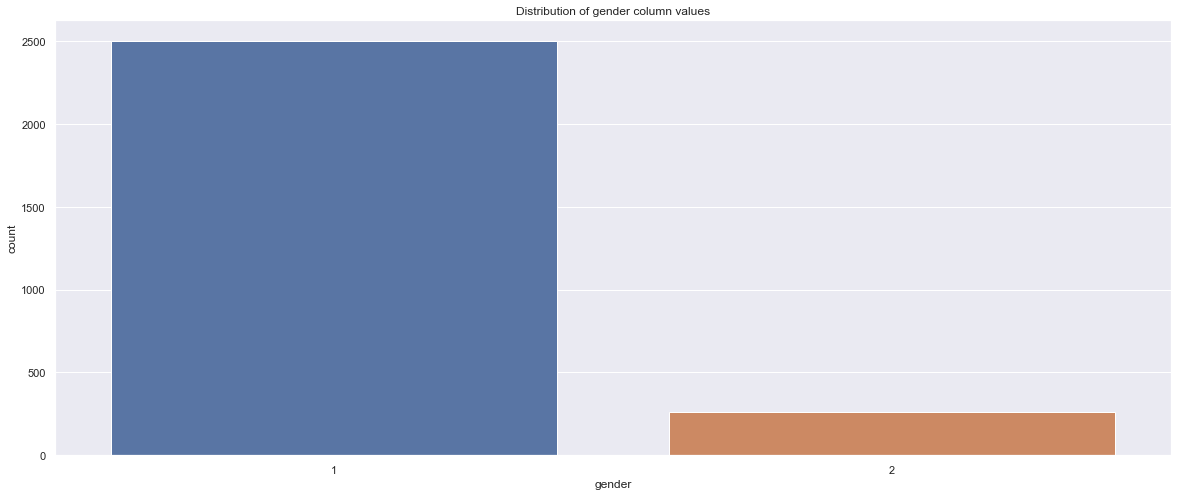

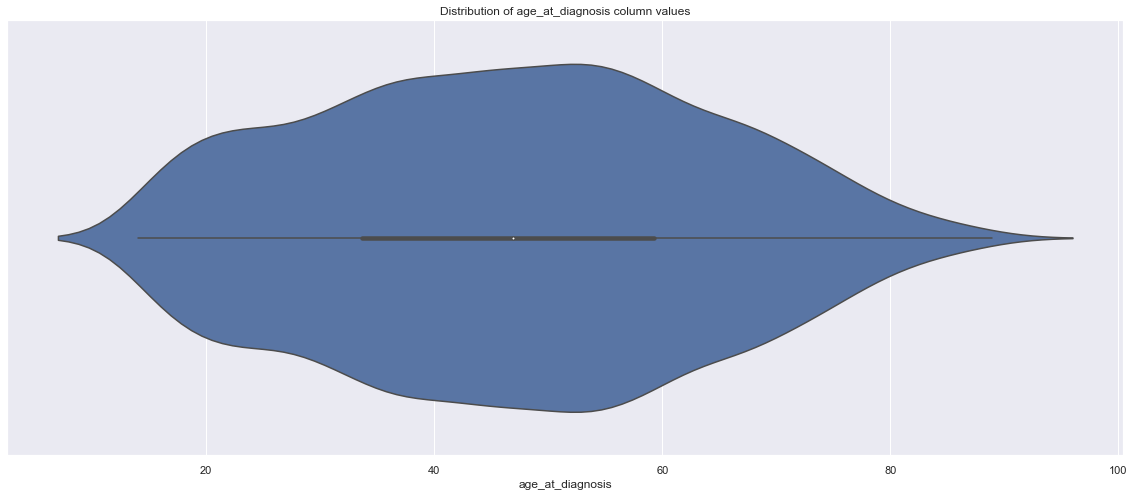

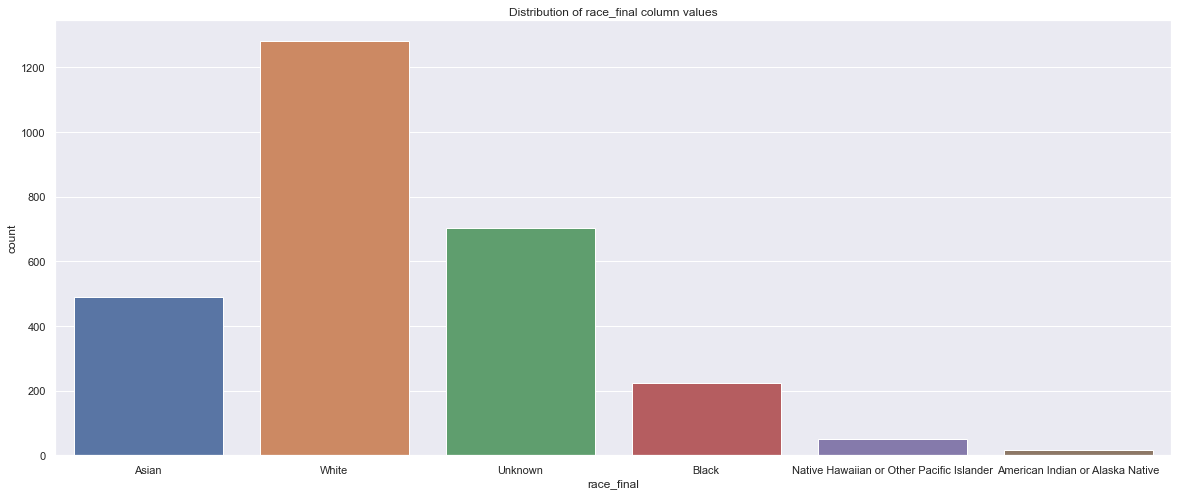

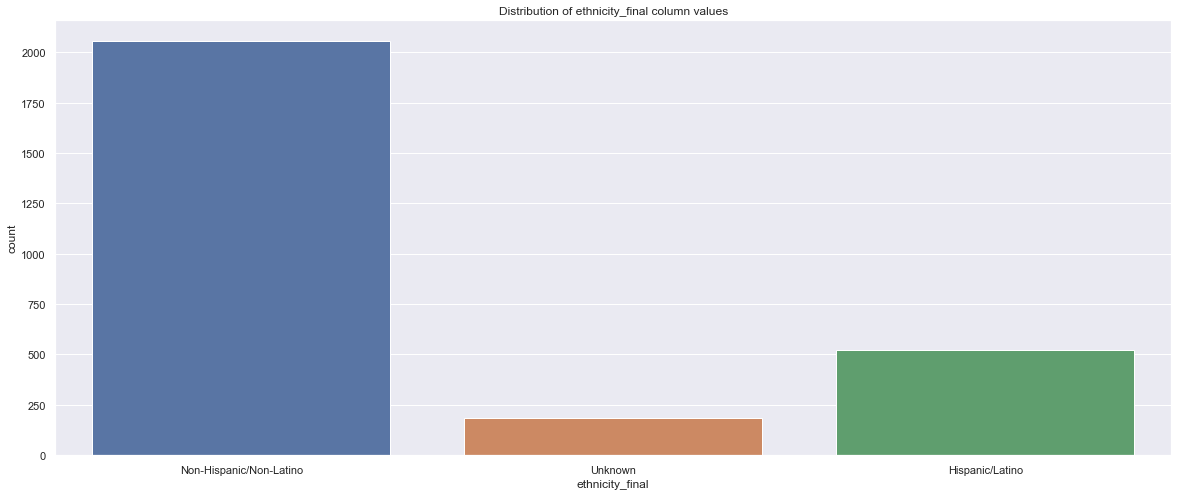

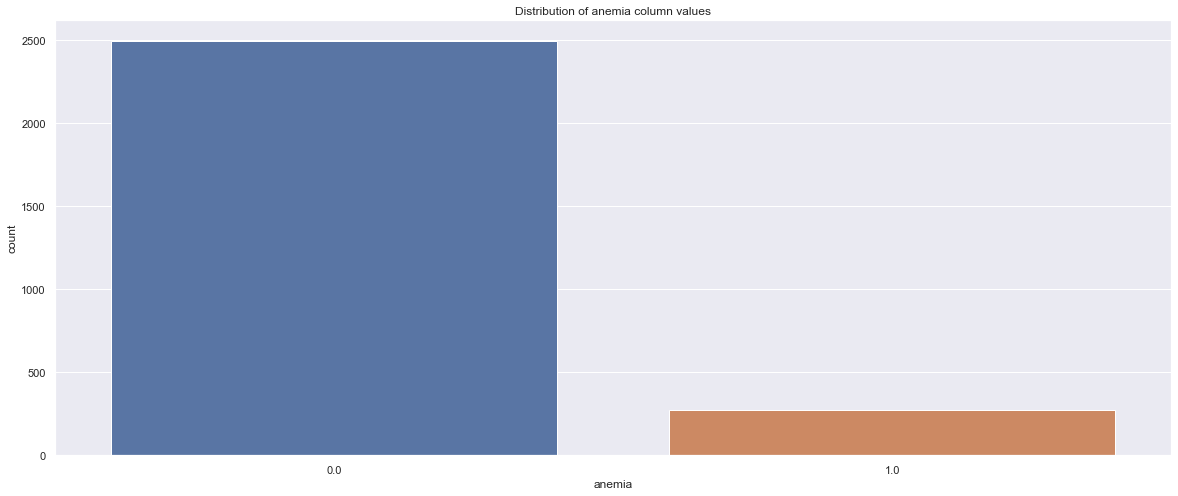

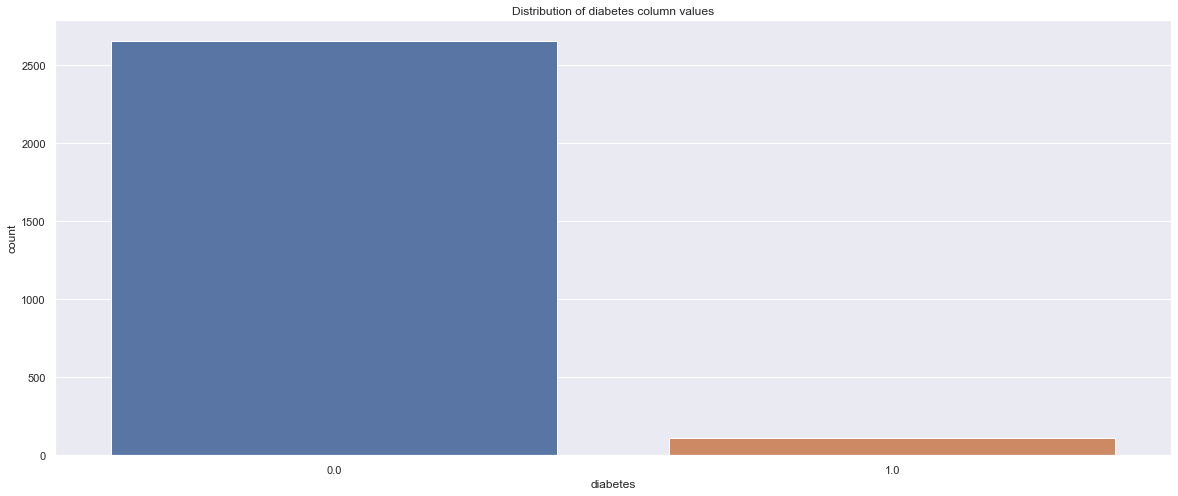

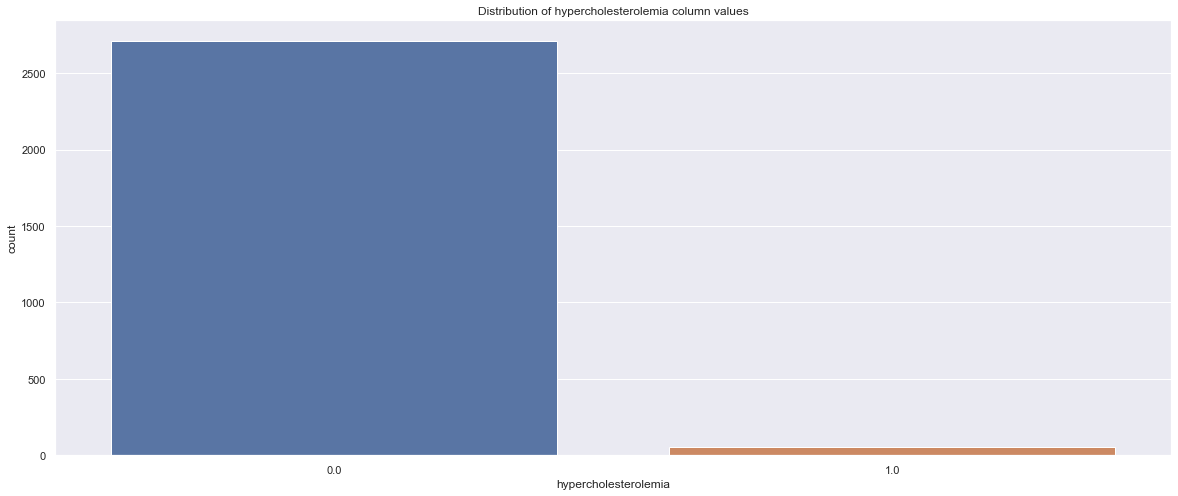

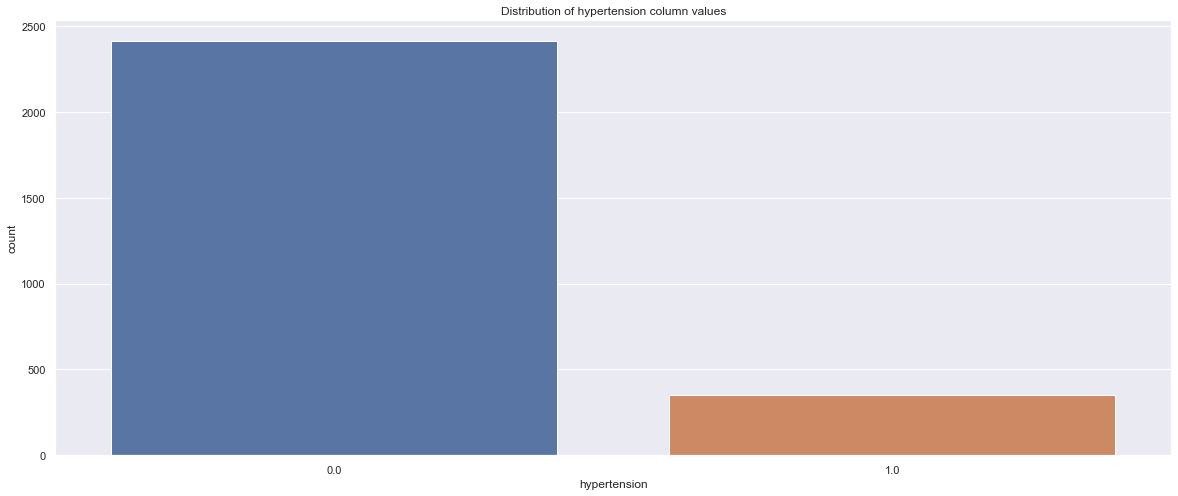

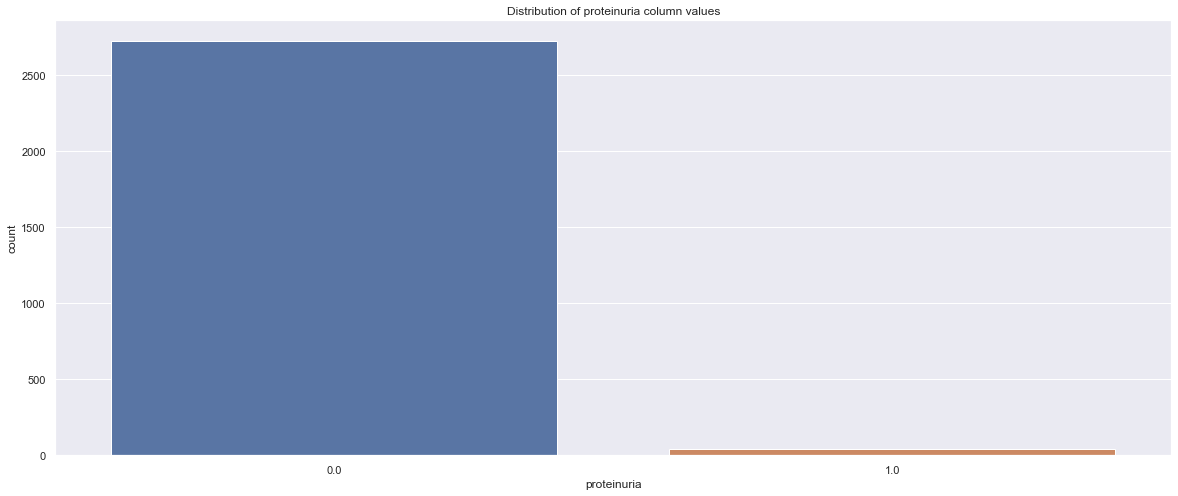

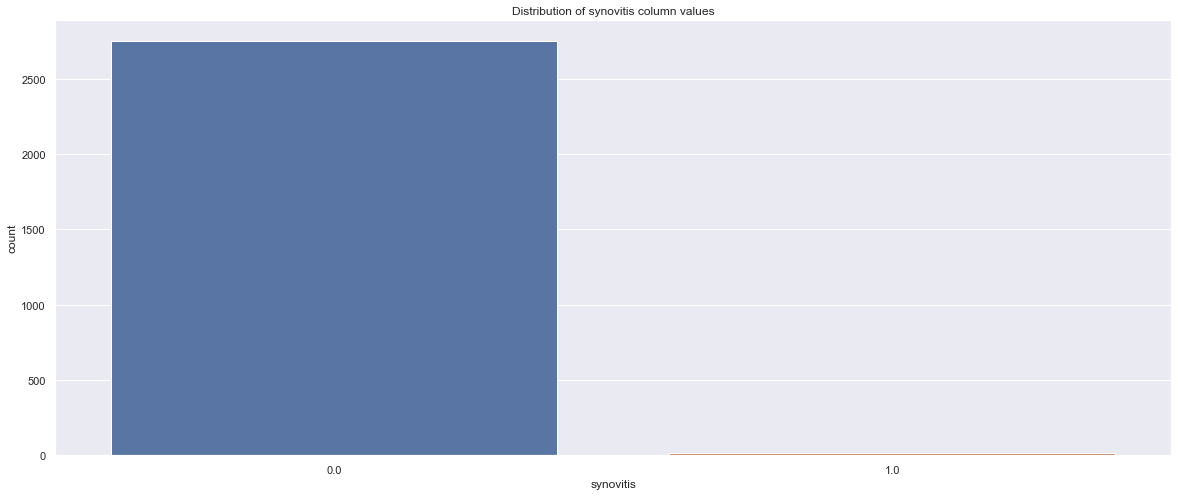

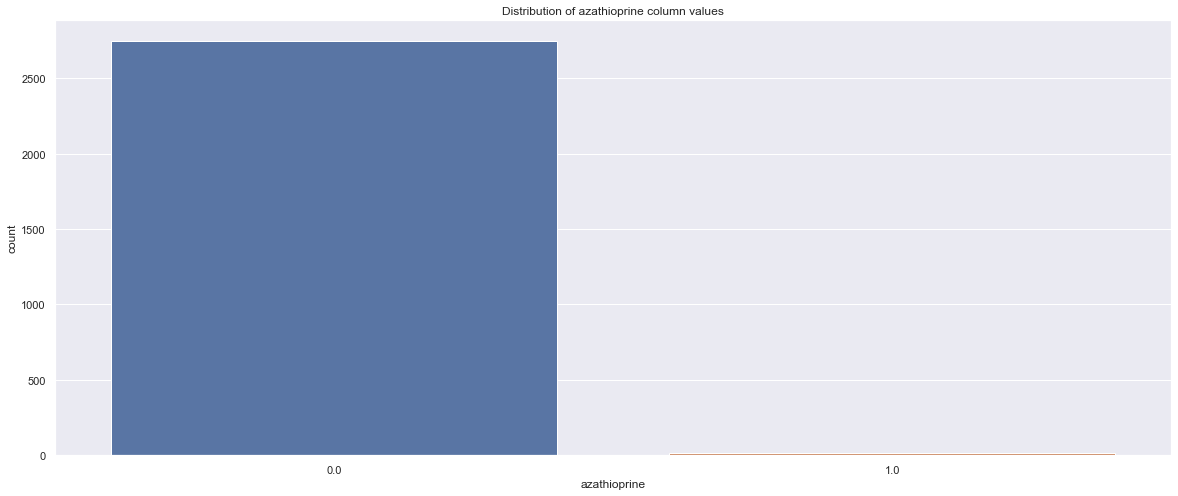

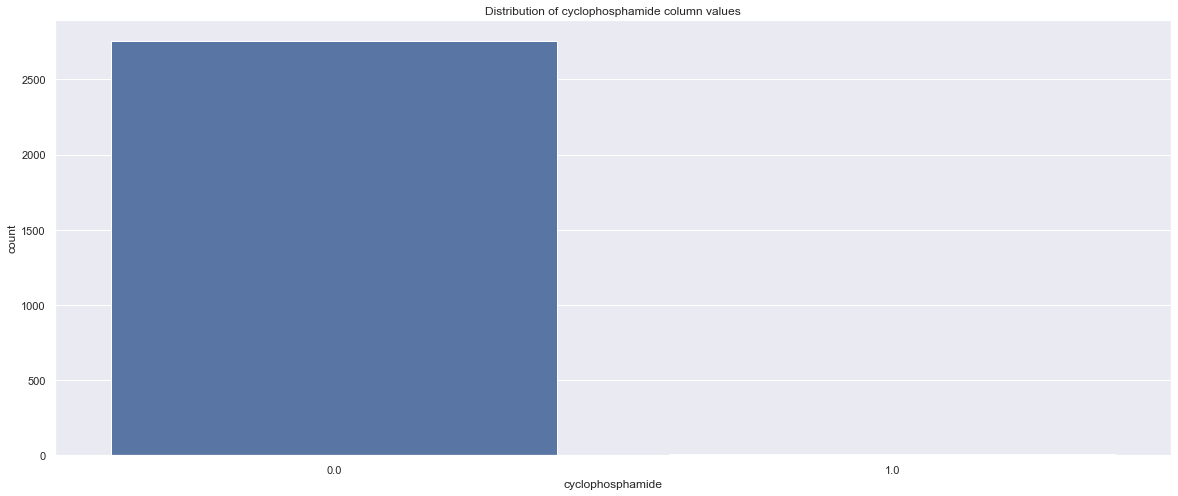

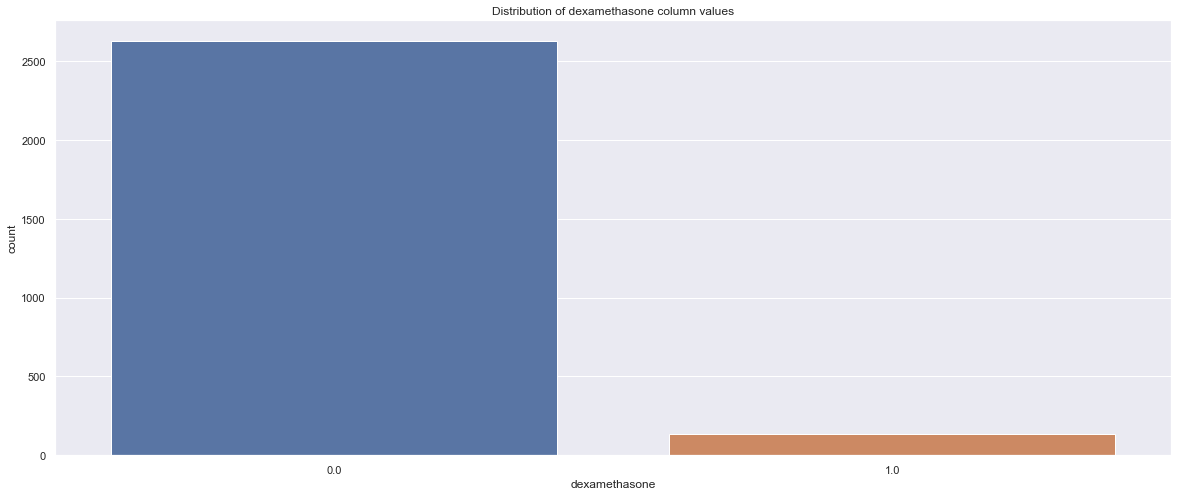

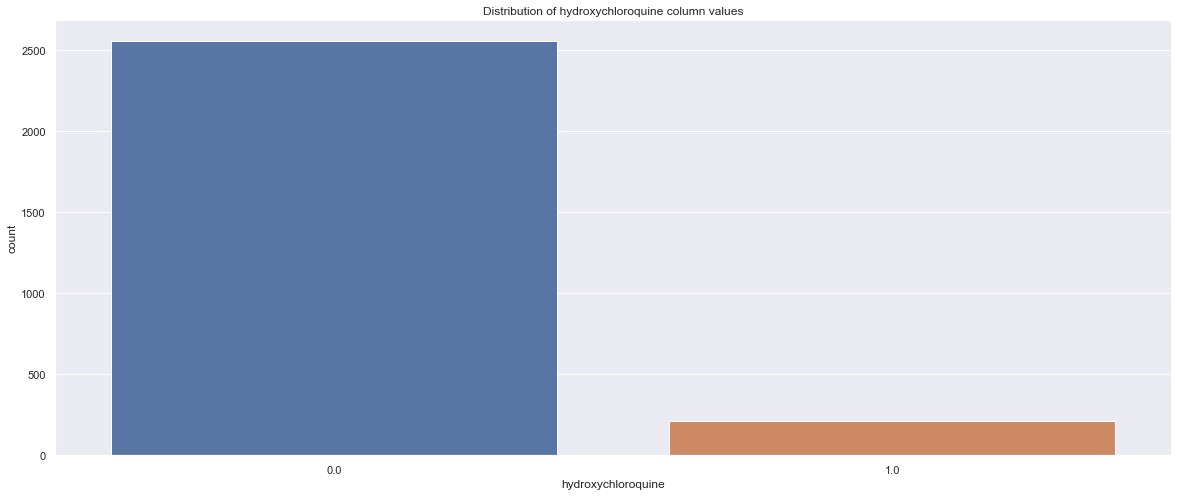

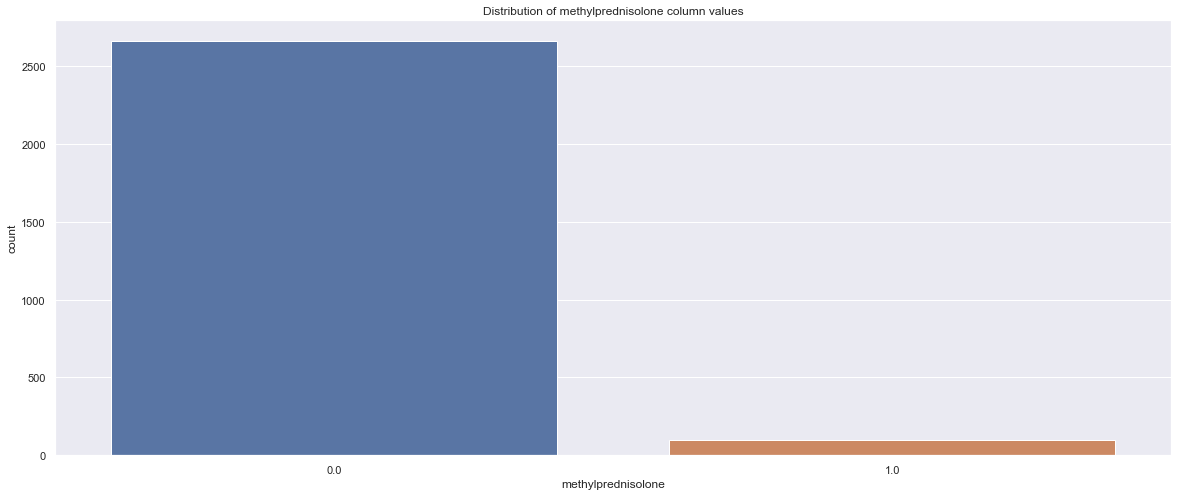

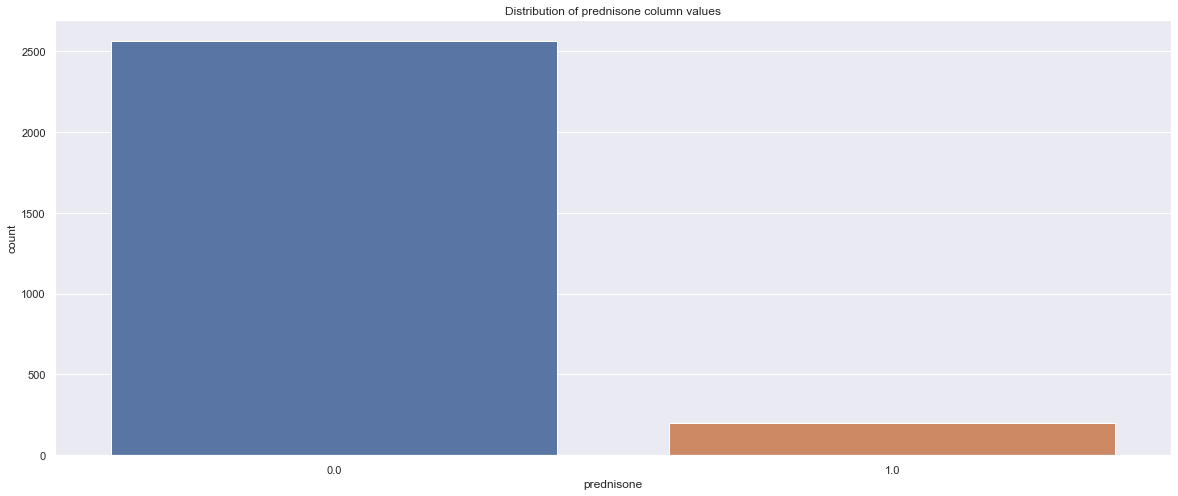

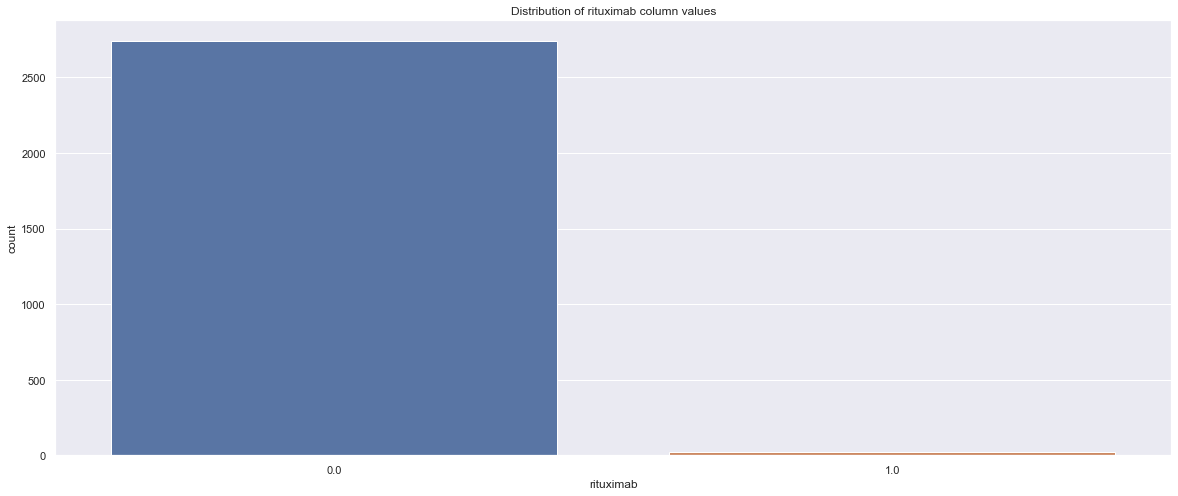

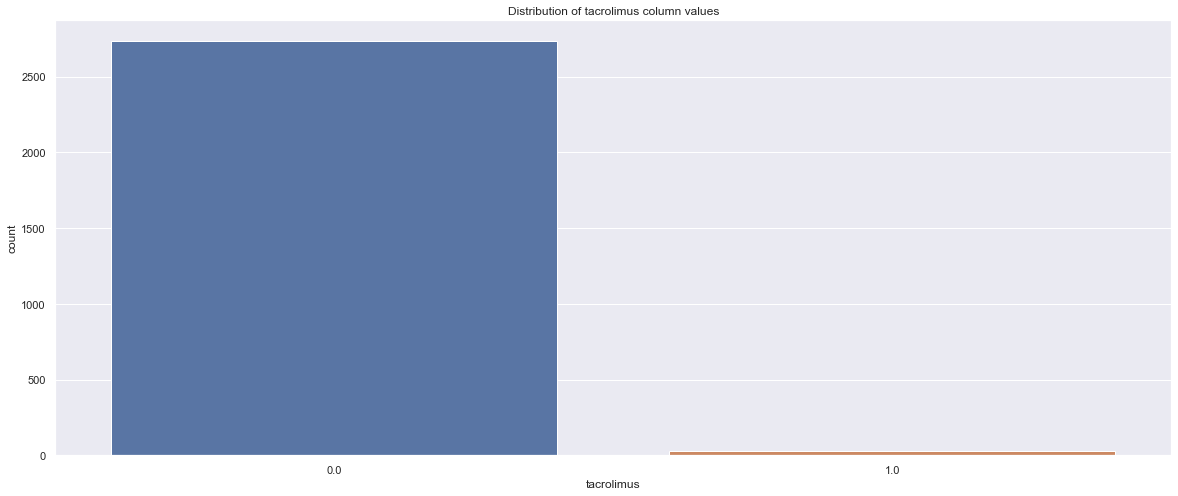

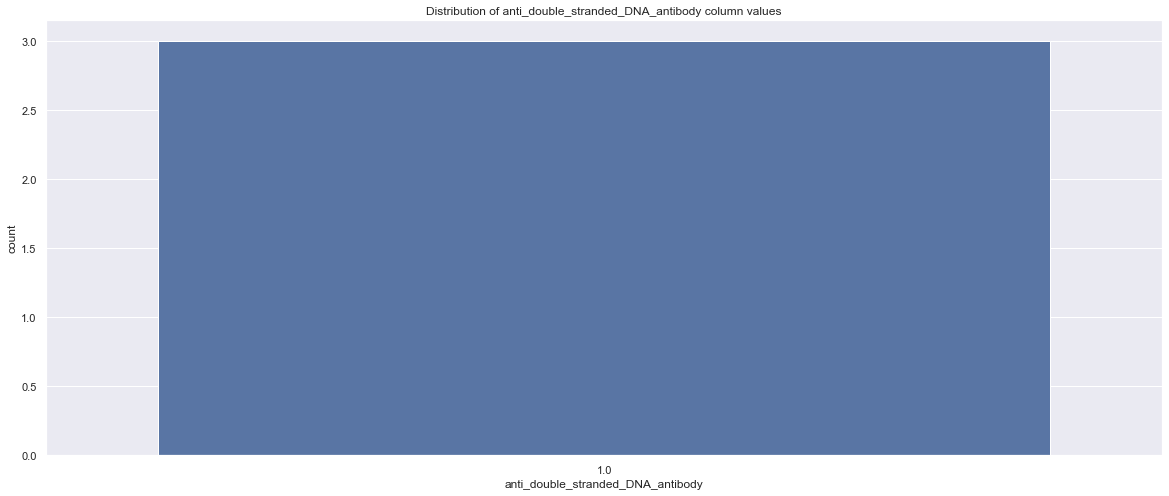

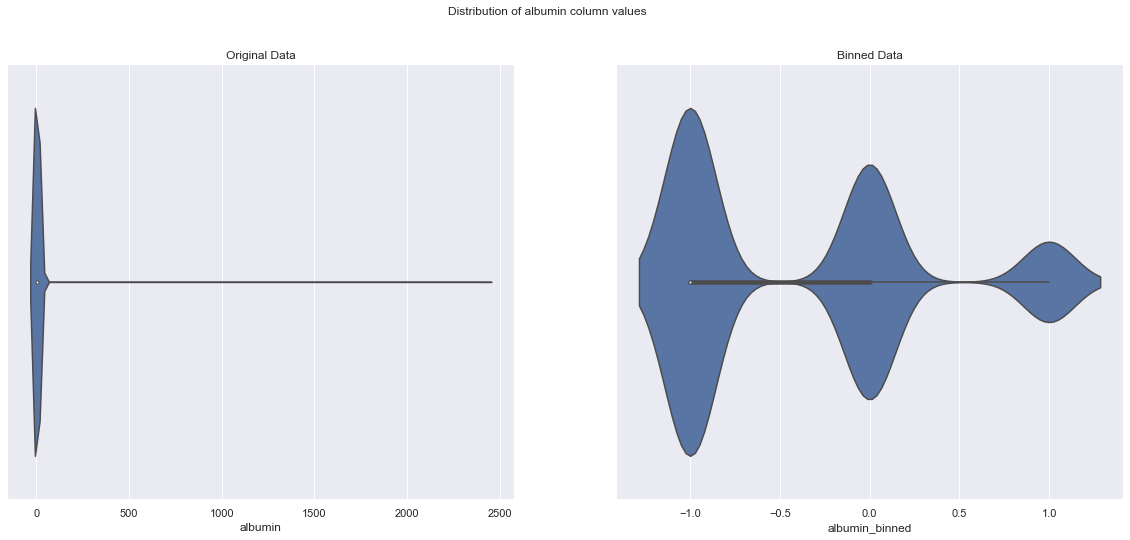

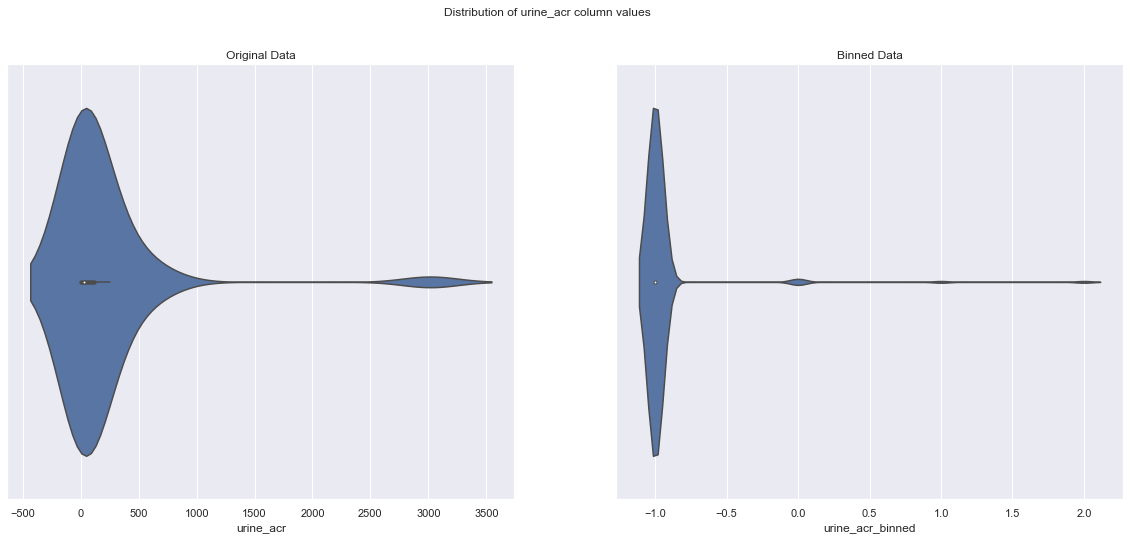

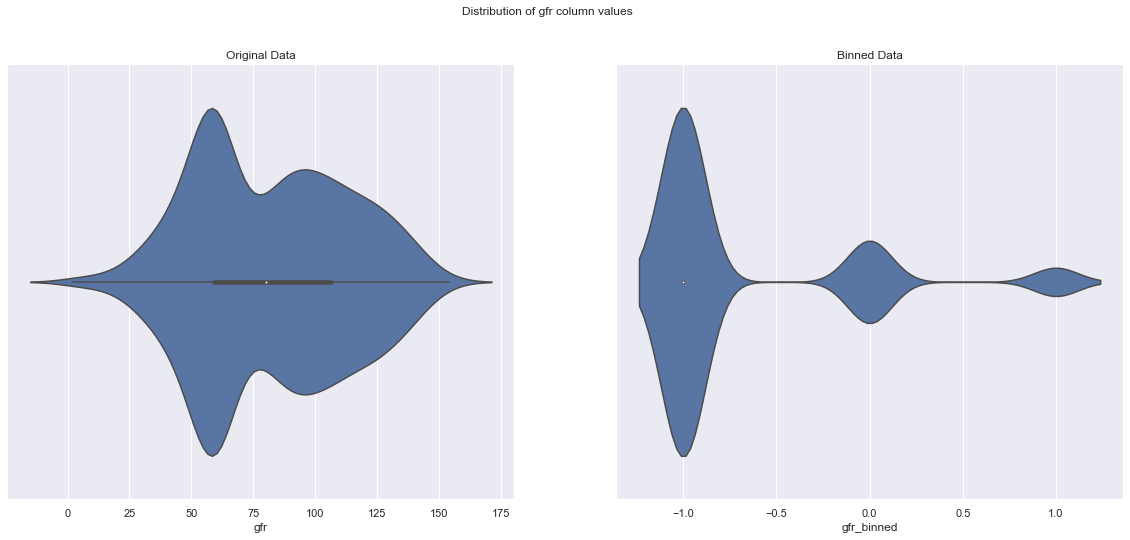

In [325]:
plot_feature_distributions(plot_type, df3)

### 11. Finalize dataset 

In [326]:
df3.head()

,cohort_definition_id,person_id,cohort_start_date,cohort_end_date,gender,birth_date,age_at_diagnosis,race_final,race_binned,ethnicity_final,ethnicity_binned,anemia,diabetes,hypercholesterolemia,hypertension,proteinuria,synovitis,azathioprine,cyclophosphamide,dexamethasone,hydroxychloroquine,methylprednisolone,mycophenolate mofetil,prednisone,rituximab,tacrolimus,anti_double_stranded_DNA_antibody,c3_final,c4_final,esr_final,c_reactive_final,creatinine_final,urine_pcr,albumin,urine_acr,gfr,bp_final,DNA_antibody_binary,c3_binned,c4_binned,esr_binned,c_reactive_binned,creatinine_binned,urine_pcr_binned,albumin_binned,urine_acr_binned,gfr_binned,bp_binned
0,21,32209409,2011-08-12,2015-07-24,1,1982-10-28,28.808219,Asian,1,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,21,30924418,2011-09-27,2017-08-30,1,1954-12-23,56.800000,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,21,31008811,2010-09-16,2019-01-24,1,1995-01-31,15.635616,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,21,30742058,2011-11-29,2019-10-07,1,1968-05-01,43.608219,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.8,NaN,NaN,NaN,0,-1,-1,-1,-1,-1,-1,0,-1,-1,-1
4,21,32400899,2012-08-06,2021-03-02,1,1948-01-11,64.613699,White,2,Unknown,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.13,NaN,NaN,NaN,NaN,NaN,NaN,0,-1,-1,-1,0,-1,-1,-1,-1,-1,-1


In [327]:
# Drop irrelevant/duplicate features
df3.drop(['cohort_definition_id', 'birth_date', 
          'albumin', 'c3_final', 'c4_final', 'c_reactive_final', 'creatinine_final', 'esr_final', 
         'gfr', 'urine_acr', 'urine_pcr', 'anti_double_stranded_DNA_antibody', 'bp_final',
         'cohort_end_date', 'cohort_start_date'], axis = 1, inplace = True)

In [328]:
df3.head()

,person_id,gender,age_at_diagnosis,race_final,race_binned,ethnicity_final,ethnicity_binned,anemia,diabetes,hypercholesterolemia,hypertension,proteinuria,synovitis,azathioprine,cyclophosphamide,dexamethasone,hydroxychloroquine,methylprednisolone,mycophenolate mofetil,prednisone,rituximab,tacrolimus,DNA_antibody_binary,c3_binned,c4_binned,esr_binned,c_reactive_binned,creatinine_binned,urine_pcr_binned,albumin_binned,urine_acr_binned,gfr_binned,bp_binned
0,32209409,1,28.808219,Asian,1,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,30924418,1,56.800000,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,31008811,1,15.635616,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,30742058,1,43.608219,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-1,-1,-1,-1,-1,-1,0,-1,-1,-1
4,32400899,1,64.613699,White,2,Unknown,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-1,-1,-1,0,-1,-1,-1,-1,-1,-1


In [329]:
# Bring in labels
labels = pd.read_csv('patient_df_labels_2022.csv')

In [330]:
df3 = pd.merge(df3, labels[['subject_id', 'ln_5years']], left_on = 'person_id', right_on = 'subject_id', how = 'left')

In [331]:
df3.head()

,person_id,gender,age_at_diagnosis,race_final,race_binned,ethnicity_final,ethnicity_binned,anemia,diabetes,hypercholesterolemia,hypertension,proteinuria,synovitis,azathioprine,cyclophosphamide,dexamethasone,hydroxychloroquine,methylprednisolone,mycophenolate mofetil,prednisone,rituximab,tacrolimus,DNA_antibody_binary,c3_binned,c4_binned,esr_binned,c_reactive_binned,creatinine_binned,urine_pcr_binned,albumin_binned,urine_acr_binned,gfr_binned,bp_binned,subject_id,ln_5years
0,32209409,1,28.808219,Asian,1,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,32209409,0
1,30924418,1,56.800000,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,30924418,0
2,31008811,1,15.635616,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,31008811,0
3,30742058,1,43.608219,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-1,-1,-1,-1,-1,-1,0,-1,-1,-1,30742058,0
4,32400899,1,64.613699,White,2,Unknown,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-1,-1,-1,0,-1,-1,-1,-1,-1,-1,32400899,0


### Additional QA

In [332]:
print("Number of patients less than 14:", sum(df3.age_at_diagnosis <14))
print("Number of patients greater than 14:", sum(df3.age_at_diagnosis >=14))

Number of patients less than 14: 0
Number of patients greater than 14: 2763


In [333]:
# How many of those patient have outcome
print("Number of patients less than 14 with LN:", sum((df3.age_at_diagnosis <14) &(df3.ln_5years ==1)))
print("Number of patients greater than 14 with LN:", sum((df3.age_at_diagnosis >=14) &(df3.ln_5years ==1)))

Number of patients less than 14 with LN: 0
Number of patients greater than 14 with LN: 155


### 12. Create test train split 

In [334]:
# Remove held out test set
test_set = pd.read_csv('test_set.csv')

In [335]:
held_out_patients = list(test_set.patient_id.unique())

In [336]:
print(len(held_out_patients))

571


##### Convert to one hot encoding 

In [337]:
df3.head()

,person_id,gender,age_at_diagnosis,race_final,race_binned,ethnicity_final,ethnicity_binned,anemia,diabetes,hypercholesterolemia,hypertension,proteinuria,synovitis,azathioprine,cyclophosphamide,dexamethasone,hydroxychloroquine,methylprednisolone,mycophenolate mofetil,prednisone,rituximab,tacrolimus,DNA_antibody_binary,c3_binned,c4_binned,esr_binned,c_reactive_binned,creatinine_binned,urine_pcr_binned,albumin_binned,urine_acr_binned,gfr_binned,bp_binned,subject_id,ln_5years
0,32209409,1,28.808219,Asian,1,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,32209409,0
1,30924418,1,56.800000,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,30924418,0
2,31008811,1,15.635616,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,31008811,0
3,30742058,1,43.608219,White,2,Non-Hispanic/Non-Latino,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-1,-1,-1,-1,-1,-1,0,-1,-1,-1,30742058,0
4,32400899,1,64.613699,White,2,Unknown,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-1,-1,-1,0,-1,-1,-1,-1,-1,-1,32400899,0


In [338]:
df3.gender.unique()

array([1, 2])

In [339]:
df4 = df3

In [340]:
# df4[['gender']] = df4[['gender']].replace([1, 2], ['female', 'male'])

In [341]:
df4.drop(['race_binned', 'ethnicity_binned'], axis = 1, inplace = True)

In [342]:
# df4[['anemia', 'proteinuria', 'synovitis', 'azathioprine','cyclophosphamide', 'dexamethasone', 'hydroxychloroquine',
#     'methylprednisolone', 'mycophenolate mofetil', 'prednisone', 'rituximab', 'tacrolimus', 
#      'DNA_antibody_binary']] = df4[['anemia', 'proteinuria', 'synovitis', 'azathioprine','cyclophosphamide', 
#     'dexamethasone', 'hydroxychloroquine','methylprednisolone', 'mycophenolate mofetil', 'prednisone', 'rituximab', 
#             'tacrolimus', 'DNA_antibody_binary']].replace([0,1], ['not_present', 'present'])

df4[['c3_binned', 'c4_binned', 'esr_binned', 'c_reactive_binned', 'creatinine_binned', 'albumin_binned', 
     'gfr_binned', 'bp_binned']] = df4[['c3_binned', 'c4_binned', 'esr_binned', 'c_reactive_binned', 'creatinine_binned', 
         'albumin_binned', 'gfr_binned', 'bp_binned']].replace([-1, 0, 1], ['unknown', 'normal', 'abnormal'])

df4[['urine_pcr_binned', 'urine_acr_binned']] = df4[['urine_pcr_binned', 'urine_acr_binned']].replace([-1, 0, 1, 2], 
                    ['unknown', 'normal', 'abnormal', 'v_abnormal'])

In [343]:
df4.head()

,person_id,gender,age_at_diagnosis,race_final,ethnicity_final,anemia,diabetes,hypercholesterolemia,hypertension,proteinuria,synovitis,azathioprine,cyclophosphamide,dexamethasone,hydroxychloroquine,methylprednisolone,mycophenolate mofetil,prednisone,rituximab,tacrolimus,DNA_antibody_binary,c3_binned,c4_binned,esr_binned,c_reactive_binned,creatinine_binned,urine_pcr_binned,albumin_binned,urine_acr_binned,gfr_binned,bp_binned,subject_id,ln_5years
0,32209409,1,28.808219,Asian,Non-Hispanic/Non-Latino,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,32209409,0
1,30924418,1,56.800000,White,Non-Hispanic/Non-Latino,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,30924418,0
2,31008811,1,15.635616,White,Non-Hispanic/Non-Latino,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,31008811,0
3,30742058,1,43.608219,White,Non-Hispanic/Non-Latino,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,unknown,unknown,unknown,unknown,unknown,unknown,normal,unknown,unknown,unknown,30742058,0
4,32400899,1,64.613699,White,Unknown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,unknown,unknown,unknown,normal,unknown,unknown,unknown,unknown,unknown,unknown,32400899,0


In [344]:
df4.describe()

,person_id,gender,age_at_diagnosis,anemia,diabetes,hypercholesterolemia,hypertension,proteinuria,synovitis,azathioprine,cyclophosphamide,dexamethasone,hydroxychloroquine,methylprednisolone,mycophenolate mofetil,prednisone,rituximab,tacrolimus,DNA_antibody_binary,subject_id,ln_5years
count,2.763000e+03,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2.763000e+03,2763.000000
mean,3.271325e+07,1.095186,46.748336,0.098082,0.039088,0.019182,0.127036,0.014115,0.004705,0.005791,0.002895,0.049584,0.076004,0.036554,0.015563,0.073109,0.008324,0.010134,0.001086,3.271325e+07,0.056098
std,5.778925e+06,0.293525,17.161492,0.297479,0.193839,0.137189,0.333073,0.117987,0.068444,0.075890,0.053741,0.217123,0.265053,0.187699,0.123799,0.260362,0.090873,0.100174,0.032939,5.778925e+06,0.230153
min,2.992701e+07,1.000000,14.024658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.992701e+07,0.000000
25%,3.064456e+07,1.000000,33.656164,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.064456e+07,0.000000
50%,3.140060e+07,1.000000,46.876712,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.140060e+07,0.000000
75%,3.212615e+07,1.000000,59.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.212615e+07,0.000000
max,7.581955e+07,2.000000,88.942466,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.581955e+07,1.000000


In [345]:
df4.drop(['person_id'], axis = 1, inplace = True)

In [346]:
df4.head()

,gender,age_at_diagnosis,race_final,ethnicity_final,anemia,diabetes,hypercholesterolemia,hypertension,proteinuria,synovitis,azathioprine,cyclophosphamide,dexamethasone,hydroxychloroquine,methylprednisolone,mycophenolate mofetil,prednisone,rituximab,tacrolimus,DNA_antibody_binary,c3_binned,c4_binned,esr_binned,c_reactive_binned,creatinine_binned,urine_pcr_binned,albumin_binned,urine_acr_binned,gfr_binned,bp_binned,subject_id,ln_5years
0,1,28.808219,Asian,Non-Hispanic/Non-Latino,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,32209409,0
1,1,56.800000,White,Non-Hispanic/Non-Latino,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,30924418,0
2,1,15.635616,White,Non-Hispanic/Non-Latino,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,31008811,0
3,1,43.608219,White,Non-Hispanic/Non-Latino,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,unknown,unknown,unknown,unknown,unknown,unknown,normal,unknown,unknown,unknown,30742058,0
4,1,64.613699,White,Unknown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,unknown,unknown,unknown,normal,unknown,unknown,unknown,unknown,unknown,unknown,32400899,0


In [347]:
# Run one hot encode
df_one_hot = df4
cat_columns = ['race_final', 'ethnicity_final','c3_binned', 'c4_binned', 'esr_binned',
       'c_reactive_binned', 'creatinine_binned', 'urine_pcr_binned',
       'albumin_binned', 'urine_acr_binned', 'gfr_binned', 'bp_binned']
for col in cat_columns:
    col_one_hot = pd.get_dummies(df4[col], prefix = col)
    df_one_hot = pd.concat((df_one_hot, col_one_hot), axis = 1).drop(col, axis = 1)

In [348]:
df_one_hot.head()

,gender,age_at_diagnosis,anemia,diabetes,hypercholesterolemia,hypertension,proteinuria,synovitis,azathioprine,cyclophosphamide,dexamethasone,hydroxychloroquine,methylprednisolone,mycophenolate mofetil,prednisone,rituximab,tacrolimus,DNA_antibody_binary,subject_id,ln_5years,race_final_American Indian or Alaska Native,race_final_Asian,race_final_Black,race_final_Native Hawaiian or Other Pacific Islander,race_final_Unknown,race_final_White,ethnicity_final_Hispanic/Latino,ethnicity_final_Non-Hispanic/Non-Latino,ethnicity_final_Unknown,c3_binned_abnormal,c3_binned_normal,c3_binned_unknown,c4_binned_abnormal,c4_binned_unknown,esr_binned_abnormal,esr_binned_normal,esr_binned_unknown,c_reactive_binned_abnormal,c_reactive_binned_normal,c_reactive_binned_unknown,creatinine_binned_abnormal,creatinine_binned_normal,creatinine_binned_unknown,urine_pcr_binned_abnormal,urine_pcr_binned_normal,urine_pcr_binned_unknown,urine_pcr_binned_v_abnormal,albumin_binned_abnormal,albumin_binned_normal,albumin_binned_unknown,urine_acr_binned_abnormal,urine_acr_binned_normal,urine_acr_binned_unknown,urine_acr_binned_v_abnormal,gfr_binned_abnormal,gfr_binned_normal,gfr_binned_unknown,bp_binned_2,bp_binned_abnormal,bp_binned_normal,bp_binned_unknown
0,1,28.808219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,32209409,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
1,1,56.800000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,30924418,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
2,1,15.635616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,31008811,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,1,43.608219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,30742058,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
4,1,64.613699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,32400899,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1


In [349]:
df_one_hot.isna().sum().sum()

0

In [350]:
df_final = df_one_hot[~df_one_hot.subject_id.isin(held_out_patients)]

In [351]:
print(len(df_final))

2203


In [352]:
df_final.drop(['subject_id'], axis = 1, inplace = True)

In [353]:
print(len(df_one_hot))
print(df_one_hot.head())
print(df_one_hot.shape)

2763
   gender  age_at_diagnosis  anemia  diabetes  hypercholesterolemia  \
0       1         28.808219     0.0       0.0                   0.0   
1       1         56.800000     0.0       0.0                   0.0   
2       1         15.635616     0.0       0.0                   0.0   
3       1         43.608219     0.0       0.0                   0.0   
4       1         64.613699     0.0       0.0                   0.0   

   hypertension  proteinuria  synovitis  azathioprine  cyclophosphamide  \
0           0.0          0.0        0.0           0.0               0.0   
1           0.0          0.0        0.0           0.0               0.0   
2           0.0          0.0        0.0           0.0               0.0   
3           0.0          0.0        0.0           0.0               0.0   
4           0.0          0.0        0.0           0.0               0.0   

   dexamethasone  hydroxychloroquine  methylprednisolone  \
0            0.0                 0.0                 0.0 

##### Split into train test split 

In [354]:
# Set random seed and validation and train percentages
val = 0.25
train = 0.75
seed = 123

In [355]:
y = df_final['ln_5years']

In [356]:
X = df_final.loc[:, df_final.columns != 'ln_5years']

In [357]:
X.head()

,gender,age_at_diagnosis,anemia,diabetes,hypercholesterolemia,hypertension,proteinuria,synovitis,azathioprine,cyclophosphamide,dexamethasone,hydroxychloroquine,methylprednisolone,mycophenolate mofetil,prednisone,rituximab,tacrolimus,DNA_antibody_binary,race_final_American Indian or Alaska Native,race_final_Asian,race_final_Black,race_final_Native Hawaiian or Other Pacific Islander,race_final_Unknown,race_final_White,ethnicity_final_Hispanic/Latino,ethnicity_final_Non-Hispanic/Non-Latino,ethnicity_final_Unknown,c3_binned_abnormal,c3_binned_normal,c3_binned_unknown,c4_binned_abnormal,c4_binned_unknown,esr_binned_abnormal,esr_binned_normal,esr_binned_unknown,c_reactive_binned_abnormal,c_reactive_binned_normal,c_reactive_binned_unknown,creatinine_binned_abnormal,creatinine_binned_normal,creatinine_binned_unknown,urine_pcr_binned_abnormal,urine_pcr_binned_normal,urine_pcr_binned_unknown,urine_pcr_binned_v_abnormal,albumin_binned_abnormal,albumin_binned_normal,albumin_binned_unknown,urine_acr_binned_abnormal,urine_acr_binned_normal,urine_acr_binned_unknown,urine_acr_binned_v_abnormal,gfr_binned_abnormal,gfr_binned_normal,gfr_binned_unknown,bp_binned_2,bp_binned_abnormal,bp_binned_normal,bp_binned_unknown
0,1,28.808219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
1,1,56.800000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
2,1,15.635616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,1,43.608219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
5,1,49.553425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1


In [358]:
# Split into train test set
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify = y, test_size = val, 
                                                          random_state = seed)

In [359]:
print(X.shape)
print(y.shape)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(2203, 59)
(2203,)
(1652, 59)
(1652,)
(551, 59)
(551,)


### 13. Model Development and Validation

In [360]:
from sklearn.linear_model import LogisticRegressionCV

In [361]:
all_results = {}
all_models = {}
k = 5
# Metrics to score
metric = ['accuracy', 'balanced_accuracy', 'roc_auc', 'average_precision', 'f1', 'precision', 'recall']

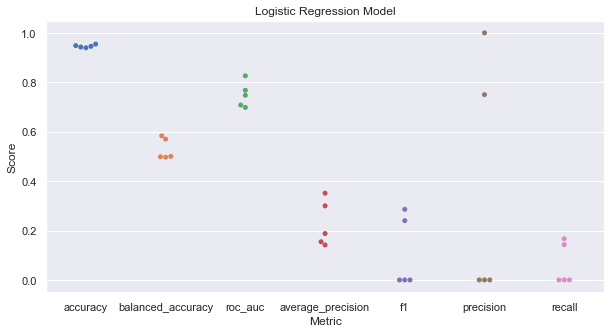

<Figure size 432x288 with 0 Axes>

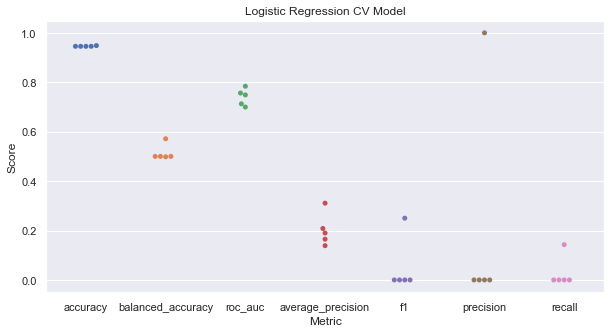

<Figure size 432x288 with 0 Axes>

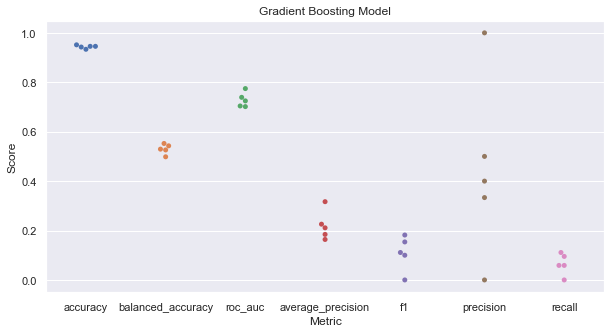

<Figure size 432x288 with 0 Axes>

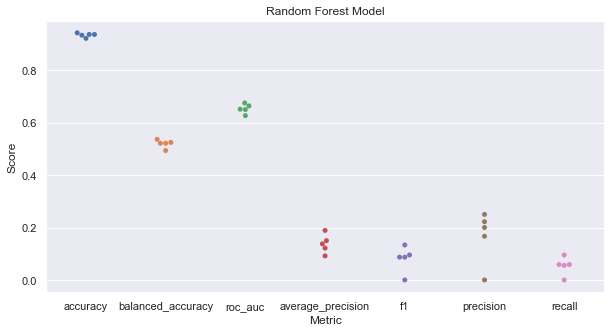

<Figure size 432x288 with 0 Axes>

In [362]:
models = [("Logistic Regression Model", LogisticRegression()),
          ("Logistic Regression CV Model", LogisticRegressionCV()), 
          ("Gradient Boosting Model", GradientBoostingClassifier()),
          ("Random Forest Model",  RandomForestClassifier())]
results = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=k, shuffle=True, random_state=seed)
    scores = model_selection.cross_validate(model, X_train, y_train, scoring=metric, cv=kfold)
    results.append((name, scores))

fig_size = (10, 5)
for name, scores in results:
    scores_df = pd.DataFrame.from_dict(scores).drop(columns=["fit_time", "score_time"])
    scores_df.columns = [col[5:] for col in scores_df.columns]
    scores_df = pd.melt(scores_df, var_name="Metric", value_name="Score")
    plt.figure(figsize=fig_size)
    ax = sns.swarmplot(data=scores_df, x="Metric", y="Score")
    ax.set_title(name)
    plt.show()
    plt.savefig('/Users/katelyn/Documents/Research/plots2/models_plots.png')
    print("\n\n")

In [363]:
results

[('Logistic Regression Model',
  {'fit_time': array([0.04671216, 0.0379312 , 0.06450891, 0.04432321, 0.03602695]),
   'score_time': array([0.00923276, 0.00919294, 0.00977707, 0.01119494, 0.00761294]),
   'test_accuracy': array([0.93957704, 0.94259819, 0.95454545, 0.94848485, 0.94545455]),
   'test_balanced_accuracy': array([0.49680511, 0.56981567, 0.58333333, 0.5       , 0.49840256]),
   'test_roc_auc': array([0.74724885, 0.69815668, 0.82621083, 0.76771284, 0.7077617 ]),
   'test_average_precision': array([0.18784624, 0.29980484, 0.35123725, 0.15447619, 0.14155799]),
   'test_f1': array([0.        , 0.24      , 0.28571429, 0.        , 0.        ]),
   'test_precision': array([0.  , 0.75, 1.  , 0.  , 0.  ]),
   'test_recall': array([0.        , 0.14285714, 0.16666667, 0.        , 0.        ])}),
 ('Logistic Regression CV Model',
  {'fit_time': array([1.07004714, 1.05477571, 1.12168407, 1.08314395, 1.16209793]),
   'score_time': array([0.01070714, 0.00701523, 0.00983906, 0.01101422, 0.00

In [364]:
def validation_results(clf, X_val, y_val, name, results):
    y_pred = clf.predict(X_val)
    y_score = clf.predict_proba(X_val)[:, 1]
    
    acc = metrics.accuracy_score(y_val, y_pred)
    bal_acc = metrics.balanced_accuracy_score(y_val, y_pred)
    roc_auc = metrics.roc_auc_score(y_val, y_score)
    avg_prec = metrics.average_precision_score(y_val, y_score)
    f1 = metrics.f1_score(y_val, y_pred)
    precision = metrics.precision_score(y_val, y_pred)
    recall = metrics.recall_score(y_val, y_pred)     
    results[name] = {"accuracy": acc,
                     "balanced_accuracy": bal_acc,
                     "roc_auc": roc_auc,
                     "average_precision": avg_prec,
                     "f1": f1,
                     "precision": precision,
                     "recall": recall}
    
    return results

In [365]:
solvers = ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
penalties = ["l1"]
C_values = [100, 10, 1.0, 0.1, 0.01] # smaller values = stronger regularization

i = 0
results = {}
models = []
for solver, penalty, C in it.product(solvers, penalties, C_values):
    if solver in ["newton-cg", "sag", "lbfgs"] and penalty != "l2":
        # skip parameter configurations not supported by scikit-learn
        continue
        
    print("Model #{i} Hyperparameters => Solver: {s}, Penalty: {p}, C: {c}".format(i=i, s=solver, p=penalty, c=C))
    if solver in ["sag", "saga", "liblinear"]:
        # these solvers first shuffle the data, so include random seed
        model = LogisticRegression(solver=solver, penalty=penalty, random_state=seed)
    else:
        model = LogisticRegression(solver=solver, penalty=penalty, random_state = seed)
    model.fit(X_train, y_train)
    models.append(model)
    results = validation_results(model, X_val, y_val, "Model #%d" % i, results)
    i += 1

Model #0 Hyperparameters => Solver: liblinear, Penalty: l1, C: 100
Model #1 Hyperparameters => Solver: liblinear, Penalty: l1, C: 10
Model #2 Hyperparameters => Solver: liblinear, Penalty: l1, C: 1.0
Model #3 Hyperparameters => Solver: liblinear, Penalty: l1, C: 0.1
Model #4 Hyperparameters => Solver: liblinear, Penalty: l1, C: 0.01
Model #5 Hyperparameters => Solver: saga, Penalty: l1, C: 100
Model #6 Hyperparameters => Solver: saga, Penalty: l1, C: 10
Model #7 Hyperparameters => Solver: saga, Penalty: l1, C: 1.0
Model #8 Hyperparameters => Solver: saga, Penalty: l1, C: 0.1
Model #9 Hyperparameters => Solver: saga, Penalty: l1, C: 0.01


In [366]:
solvers = ["lbfgs"]
penalties = ["l2"]

i = 10
for solver, penalty in it.product(solvers, penalties):
    if solver in ["newton-cg", "sag", "lbfgs"] and penalty != "l2":
        # skip parameter configurations not supported by scikit-learn
        continue
        
    print("Model #{i} Hyperparameters => Solver: {s}, Penalty: {p},".format(i=i, s=solver, p=penalty))
    if solver in ["sag", "saga", "liblinear"]:
        # these solvers first shuffle the data, so include random seed
        model = LogisticRegressionCV(solver=solver, cv = 5, penalty=penalty, random_state=seed)
    else:
        model = LogisticRegressionCV(solver=solver, cv = 5, penalty=penalty, random_state = seed)
    model.fit(X_train, y_train)
    models.append(model)
    results = validation_results(model, X_val, y_val, "Model #%d" % i, results)
    i += 1

Model #10 Hyperparameters => Solver: lbfgs, Penalty: l2,


In [367]:
results

{'Model #0': {'accuracy': 0.9455535390199638,
  'balanced_accuracy': 0.5161290322580645,
  'roc_auc': 0.7313275434243176,
  'average_precision': 0.19256552551905137,
  'f1': 0.0625,
  'precision': 1.0,
  'recall': 0.03225806451612903},
 'Model #1': {'accuracy': 0.9455535390199638,
  'balanced_accuracy': 0.5161290322580645,
  'roc_auc': 0.7313275434243176,
  'average_precision': 0.19256552551905137,
  'f1': 0.0625,
  'precision': 1.0,
  'recall': 0.03225806451612903},
 'Model #2': {'accuracy': 0.9455535390199638,
  'balanced_accuracy': 0.5161290322580645,
  'roc_auc': 0.7313275434243176,
  'average_precision': 0.19256552551905137,
  'f1': 0.0625,
  'precision': 1.0,
  'recall': 0.03225806451612903},
 'Model #3': {'accuracy': 0.9455535390199638,
  'balanced_accuracy': 0.5161290322580645,
  'roc_auc': 0.7313275434243176,
  'average_precision': 0.19256552551905137,
  'f1': 0.0625,
  'precision': 1.0,
  'recall': 0.03225806451612903},
 'Model #4': {'accuracy': 0.9455535390199638,
  'balance

In [368]:
def plot_validation_results(results, model_name, fig_size=(10, 8)):
    results_df = pd.DataFrame()
    for name, result in results.items():
        results_df = results_df.append(result, ignore_index=True)

    results_df = pd.melt(results_df, var_name="Metric", value_name="Score")
    results_df["Name"] = list(results.keys()) * len(metric)

    ncol = (len(results.keys()) // 20) + 1
    plt.figure(figsize=fig_size)
    ax = sns.swarmplot(data=results_df, x="Metric", y="Score", hue="Name")
    ax.set_title("Performance of%s Models with Varied Hyperparameters" % model_name)
    plt.legend(bbox_to_anchor=(1.5, 1), loc="upper right", ncol=ncol)
    plt.savefig('/Users/katelyn/Documents/Research/plots2/'+ str(model_name)+ '_validation_results.png')
    plt.show()
    
    
    print("\n\n")

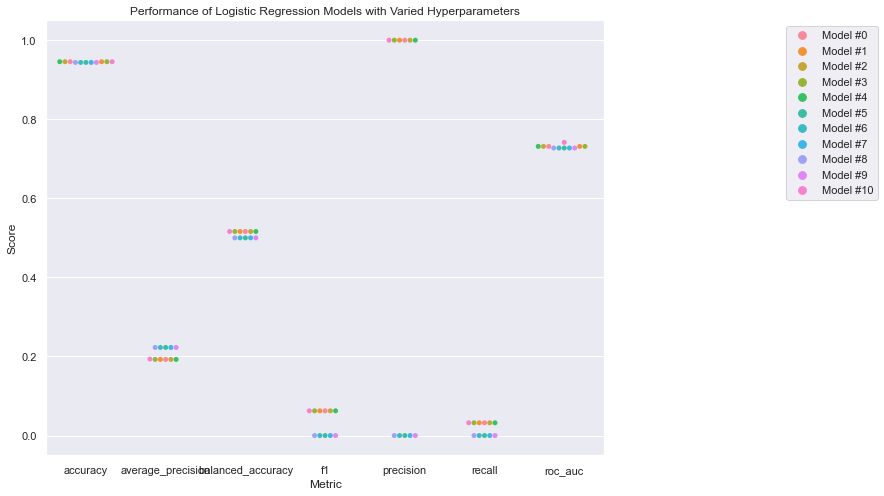

In [369]:
plot_validation_results(results, " Logistic Regression")

In [370]:
def filter_validation_results(results, metric_name, threshold):
    filtered_models = []
    for name, result in results.items():
        if result[metric_name] > threshold:
            print(name)
            filtered_models.append(name)
            
    return filtered_models

def find_models(filtered_results):
    for model_name in filtered_results:
        print(model_name)
        print(results[model_name])
        print()

In [371]:
f = filter_validation_results(results, "roc_auc", 0.73)

Model #0
Model #1
Model #2
Model #3
Model #4
Model #10


In [372]:
r = filter_validation_results(results, "f1", 0.06)

Model #0
Model #1
Model #2
Model #3
Model #4
Model #10


In [373]:
find_models(f)

Model #0
{'accuracy': 0.9455535390199638, 'balanced_accuracy': 0.5161290322580645, 'roc_auc': 0.7313275434243176, 'average_precision': 0.19256552551905137, 'f1': 0.0625, 'precision': 1.0, 'recall': 0.03225806451612903}

Model #1
{'accuracy': 0.9455535390199638, 'balanced_accuracy': 0.5161290322580645, 'roc_auc': 0.7313275434243176, 'average_precision': 0.19256552551905137, 'f1': 0.0625, 'precision': 1.0, 'recall': 0.03225806451612903}

Model #2
{'accuracy': 0.9455535390199638, 'balanced_accuracy': 0.5161290322580645, 'roc_auc': 0.7313275434243176, 'average_precision': 0.19256552551905137, 'f1': 0.0625, 'precision': 1.0, 'recall': 0.03225806451612903}

Model #3
{'accuracy': 0.9455535390199638, 'balanced_accuracy': 0.5161290322580645, 'roc_auc': 0.7313275434243176, 'average_precision': 0.19256552551905137, 'f1': 0.0625, 'precision': 1.0, 'recall': 0.03225806451612903}

Model #4
{'accuracy': 0.9455535390199638, 'balanced_accuracy': 0.5161290322580645, 'roc_auc': 0.7313275434243176, 'avera

In [374]:
def plot_roc_pr_curves(name, X_val, y_val, clf, fig_size=(10, 8)):
    fig, ax = plt.subplots(1,1,figsize=fig_size)
    roc_disp = metrics.plot_roc_curve(clf, X_val, y_val, ax=ax)
    ax.set_xlabel("False Positive Rate", fontsize = 18)
    ax.set_ylabel("True Positive Rate", fontsize = 18)
    ax.set_title("Receiver Operating Characteristic (ROC) Curve", fontsize = 18)
    plt.savefig('/Users/katelyn/Documents/Research/plots2/' + str(name) + '_val_roc.png')

    plt.show()

    # PR Curve and AP (average precision)
    fig, ax = plt.subplots(1,1,figsize=fig_size)
    pr_disp = metrics.plot_precision_recall_curve(clf, X_val, y_val, ax=ax)
    ax.set_xlabel("Recall", fontsize = 18)
    ax.set_ylabel("Precision", fontsize = 18)
    ax.set_title("Precision-Recall (PR) Curve", fontsize = 18)
    plt.savefig('/Users/katelyn/Documents/Research/plots2' + str(name) + '_val_pr.png')
    plt.show()

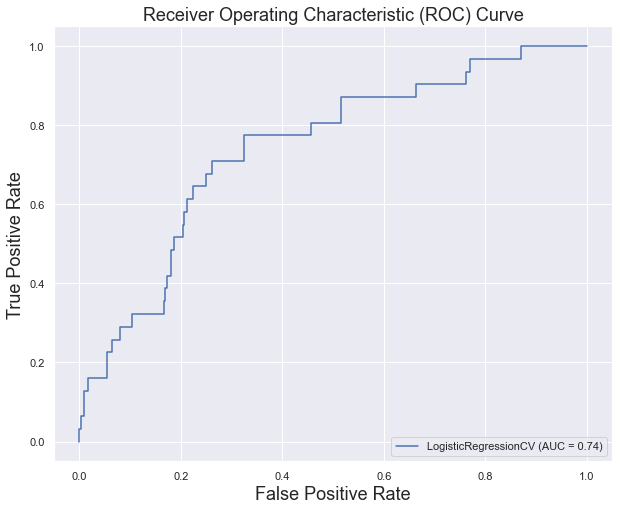

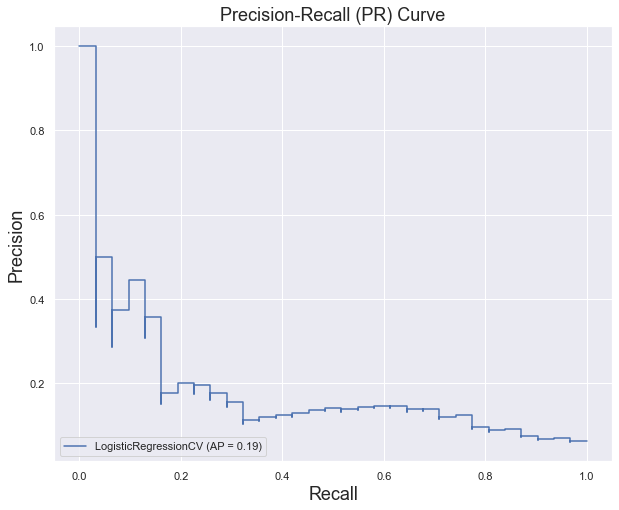

In [375]:
cv_model = 10
lr_cv_model = models[cv_model]
plot_roc_pr_curves("Logistic Regression CV", X_val, y_val, lr_cv_model)
all_results = validation_results(lr_cv_model, X_val, y_val, "Logistic Regression CV", all_results)
all_models['Logistic Regression CV'] = lr_cv_model

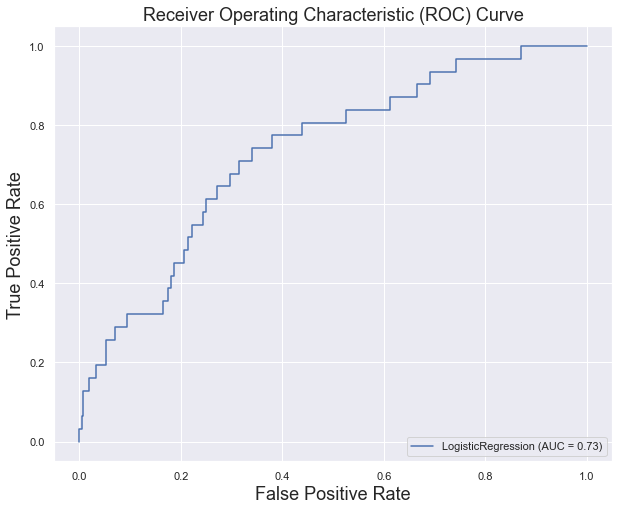

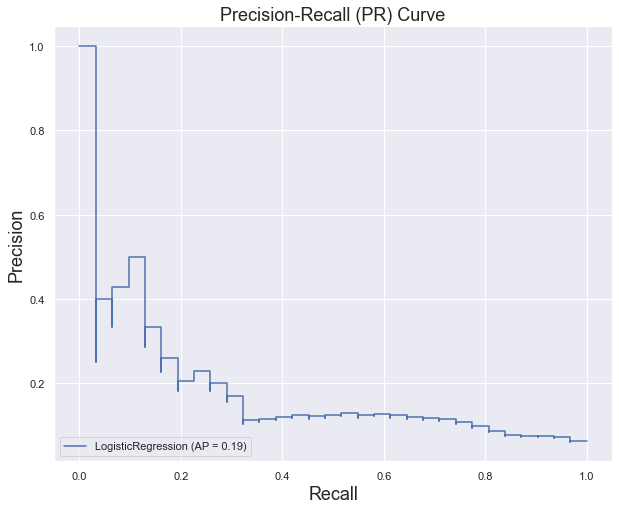

In [376]:
best_model_num = 4
lr_best_model = models[best_model_num]
plot_roc_pr_curves("Logistic Regression L1", X_val, y_val, lr_best_model)
all_results = validation_results(lr_best_model, X_val, y_val, "Logistic Regression L1", all_results)
all_models["Logistic Regression L1"] = lr_best_model

##### Ensemble Models: Gradient Boosting and Random Forest

In [377]:
# Baseline model
gb_baseline = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100, max_depth = 3, min_samples_split = 2, 
                                     min_samples_leaf = 1, subsample = 1, max_features = "sqrt", random_state = seed)
gb_baseline.fit(X_train, y_train)

all_results = validation_results(gb_baseline, X_val, y_val, "Gradient Boosting Basline", all_results)
all_models["Gradient Boosting Baseline"] = gb_baseline

In [378]:
param_1 = {'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, .25, .5, .75, 1]}
param_2 = {'learning_rate':  [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, .25, .5, .75, 1], 'n_estimators': [100, 250, 500, 750, 1000, 1250, 1500, 1750]}
param_3 = {'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, .25, .5, .75, 1], 'n_estimators': [100, 250, 500, 750, 1000, 1250, 1500, 1750], 'max_depth': [2, 3, 4]}
param_4 = {'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, .25, .5, .75, 1], 
              'n_estimators': [100, 250, 500, 750, 1000, 1250, 1500, 1750], 
             'max_depth': [2, 3, 4], 
             'max_features': [3, 4, 5]}

In [379]:
# GBM with param_1
tuning = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(subsample = 1, max_features= 'sqrt',
                                                                             n_estimators = 100,
                                                             max_depth = 3, min_samples_split = 2, min_samples_leaf = 1,
                                                             random_state = seed), 
                     param_grid = param_1, scoring = 'accuracy', n_jobs = 4, cv = 5)
tuning.fit(X_train, y_train)
tuning.cv_results_, tuning.best_params_, tuning.best_score_

({'mean_fit_time': array([0.11199598, 0.11570706, 0.10330267, 0.08993917, 0.12123237,
         0.10009427, 0.0839695 , 0.09818416, 0.12935238, 0.13787179]),
  'std_fit_time': array([0.0026467 , 0.00714161, 0.01461086, 0.0039113 , 0.0044779 ,
         0.01232793, 0.00533536, 0.00358202, 0.01020759, 0.02031283]),
  'mean_score_time': array([0.00433965, 0.00393896, 0.00404296, 0.00396023, 0.00480437,
         0.00356975, 0.00359979, 0.0038362 , 0.00382366, 0.00488338]),
  'std_score_time': array([3.02927160e-04, 4.36691973e-04, 6.07539194e-05, 6.41199623e-04,
         1.61439839e-03, 5.10879437e-04, 3.05523101e-04, 2.89183492e-04,
         3.14880261e-04, 2.06348160e-03]),
  'param_learning_rate': masked_array(data=[0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.25, 0.5, 0.75,
                     1],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'params': [{'learning_rate': 

In [380]:
# GBM with param_2
tuning = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(subsample = 1, max_features= 'sqrt',
                                                             max_depth = 3, min_samples_split = 2, min_samples_leaf = 1,
                                                             random_state = seed), 
                     param_grid = param_2, scoring = 'accuracy', n_jobs = 4, cv = 5)
tuning.fit(X_train, y_train)
tuning.cv_results_, tuning.best_params_, tuning.best_score_

({'mean_fit_time': array([0.11593161, 0.24348779, 0.54880195, 0.75973721, 1.03618422,
         1.27208242, 1.52131944, 1.77070765, 0.11255226, 0.26337662,
         0.48426852, 0.77023048, 0.90716629, 1.25152283, 1.54713707,
         1.54507604, 0.08989825, 0.21169949, 0.49429941, 0.70781426,
         0.86468749, 1.08290405, 1.29163799, 1.53211727, 0.09222703,
         0.22121029, 0.43339648, 0.64041457, 0.87645102, 1.08633218,
         1.3589128 , 1.67737279, 0.09493237, 0.30306134, 0.59609962,
         0.87916284, 1.09600015, 1.35394044, 1.62303858, 1.78480697,
         0.1058846 , 0.30326934, 0.63208299, 0.85737233, 1.07256899,
         1.29462519, 1.78695765, 1.90553994, 0.09865122, 0.34131646,
         0.5288094 , 0.84973292, 1.04170079, 1.60300813, 1.78945179,
         2.12044783, 0.10714498, 0.28258085, 0.65758948, 1.31528883,
         1.23230953, 1.40567088, 2.01001225, 2.05680385, 0.1004056 ,
         0.26391525, 0.51675344, 0.70403247, 1.04337873, 1.48046007,
         2.305194

In [381]:
# GBM with param_3
tuning = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(subsample = 1, max_features= 'sqrt',
                                                             min_samples_split = 2, min_samples_leaf = 1,
                                                             random_state = seed), 
                     param_grid = param_3, scoring = 'accuracy', n_jobs = 4, cv = 5)
tuning.fit(X_train, y_train)
tuning.cv_results_, tuning.best_params_, tuning.best_score_

({'mean_fit_time': array([0.15514946, 0.31630645, 0.62178421, 1.02129641, 1.34234266,
         1.71243539, 2.16689672, 2.80877767, 0.22419186, 0.53125343,
         1.0473279 , 1.3618216 , 1.63535452, 2.04097495, 2.25380502,
         2.43786259, 0.17776761, 0.51122875, 0.95471482, 1.51106539,
         1.87564797, 2.42637773, 2.33295522, 2.48872242, 0.08301144,
         0.19828696, 0.39341345, 0.66036301, 0.8660677 , 1.03000717,
         1.24085946, 1.48411202, 0.11395946, 0.28066978, 0.57116337,
         0.86519084, 1.11968503, 1.40904856, 1.65125494, 1.85430264,
         0.14810624, 0.36358418, 0.71609869, 1.06305966, 1.46415701,
         1.9027585 , 2.18760886, 2.52938776, 0.08681893, 0.20644627,
         0.41608667, 0.65961909, 0.85295453, 1.0789402 , 1.30191655,
         1.54874649, 0.12932949, 0.30174356, 0.6204227 , 0.92225599,
         1.16889086, 1.45331192, 1.76015463, 2.05225201, 0.16369581,
         0.40166373, 0.90417886, 1.22403159, 1.53502369, 1.7627358 ,
         2.166689

In [382]:
# GBM with param_4
tuning = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(subsample = 1, 
                                                             min_samples_split = 2, min_samples_leaf = 1,
                                                             random_state = seed), 
                     param_grid = param_4, scoring = 'accuracy', n_jobs = 4, cv = 5)

tuning.fit(X_train, y_train)
tuning.cv_results_, tuning.best_params_, tuning.best_score_

({'mean_fit_time': array([0.0861105 , 0.20359845, 0.31991267, 0.4682807 , 0.61789613,
         0.77816501, 0.91476145, 1.1008502 , 0.07062054, 0.16968389,
         0.34449058, 0.52662849, 0.73695059, 0.90862885, 1.12640948,
         1.35684443, 0.09339566, 0.22389617, 0.44212461, 0.69618015,
         0.90786901, 1.05491762, 1.25930138, 1.46838851, 0.11206713,
         0.2510006 , 0.52305002, 0.7658    , 1.04849458, 1.22425928,
         1.41995134, 1.63241386, 0.10156589, 0.24598022, 0.50188785,
         0.74538097, 0.97566438, 1.1952075 , 1.42033362, 1.66618876,
         0.10277948, 0.24693542, 0.4973824 , 0.74639692, 0.99740648,
         1.25473185, 1.54391823, 1.88156133, 0.13547859, 0.32472138,
         0.71018944, 1.04013276, 1.50926681, 2.13425183, 2.52644238,
         2.73453469, 0.17114134, 0.43559337, 0.76481905, 1.07041183,
         1.37471757, 1.63737097, 1.88493047, 2.14003415, 0.13336554,
         0.3292212 , 0.7319685 , 1.200353  , 1.48937955, 1.87862597,
         2.295451

In [383]:
gb_model_param1 = GradientBoostingClassifier(learning_rate = 0.001, random_state = seed)
gb_model_param1.fit(X_train, y_train)
predictions = gb_model_param1.predict(X_val)
print(metrics.classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       520
           1       0.00      0.00      0.00        31

    accuracy                           0.94       551
   macro avg       0.47      0.50      0.49       551
weighted avg       0.89      0.94      0.92       551



In [384]:
gb_model_param2 = GradientBoostingClassifier(learning_rate = 0.005,n_estimators = 500, random_state = seed)
gb_model_param2.fit(X_train, y_train)
predictions = gb_model_param2.predict(X_val)
print(metrics.classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       520
           1       0.00      0.00      0.00        31

    accuracy                           0.94       551
   macro avg       0.47      0.50      0.49       551
weighted avg       0.89      0.94      0.92       551



In [385]:
gb_model_param3 = GradientBoostingClassifier(learning_rate = 0.001, n_estimators = 1500, max_depth = 4, random_state = seed)
gb_model_param3.fit(X_train, y_train)
predictions = gb_model_param3.predict(X_val)
print(metrics.classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       520
           1       0.00      0.00      0.00        31

    accuracy                           0.94       551
   macro avg       0.47      0.50      0.49       551
weighted avg       0.89      0.94      0.92       551



In [386]:
gb_model_param4 = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 3, max_features = 5,
                                             n_estimators = 250, random_state = seed)
gb_model_param4.fit(X_train, y_train)
predictions = gb_model_param4.predict(X_val)
print(metrics.classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       520
           1       0.00      0.00      0.00        31

    accuracy                           0.94       551
   macro avg       0.47      0.50      0.49       551
weighted avg       0.89      0.94      0.92       551



In [387]:
gb_best_model = gb_model_param3
all_results = validation_results(gb_best_model, X_val, y_val, "GB best model", all_results)
all_models["GB best model"] = gb_best_model

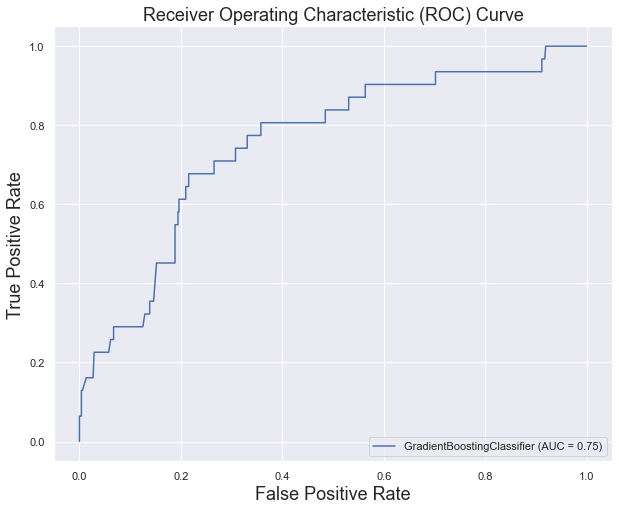

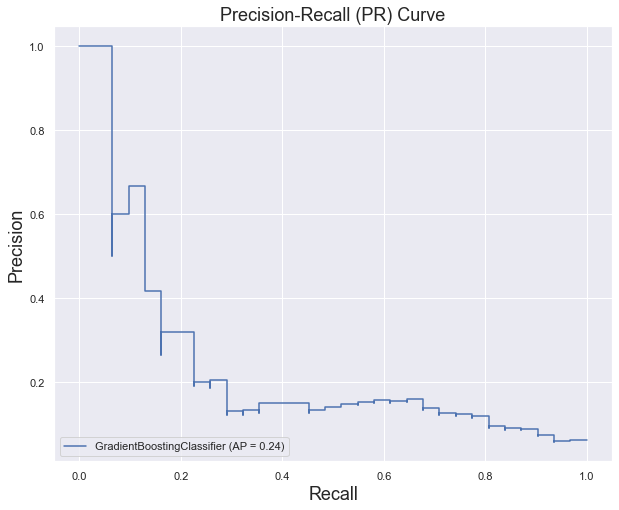

In [388]:
plot_roc_pr_curves("Gradient Boosting Baseline", X_val, y_val, gb_baseline)

In [389]:
rf = RandomForestClassifier(random_state = seed)

# Look at parameters in rf 
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}


In [390]:
rf_baseline = RandomForestClassifier(random_state = seed)
rf_baseline.fit(X_train, y_train)

all_results = validation_results(rf_baseline, X_val, y_val, "Random Forest Baseline", all_results)
all_models["Random Forest Baseline"] = rf_baseline

In [391]:
# Random search grid
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree 
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node 
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

In [392]:
# Create random grid
random_grid = {'n_estimators': n_estimators, 
              'max_features': max_features, 
              'max_depth': max_depth, 
              'min_samples_split': min_samples_split, 
              'min_samples_leaf': min_samples_leaf, 
              'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [393]:
# Random search training
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = seed)
# Random search of parameters, using 3 fold cross validation
# Search across 100 different combinations, and use all available cores
rf_random = model_selection.RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, random_state = seed, 
                              n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
rf_random_model = rf_random.best_estimator_

all_results = validation_results(rf_random_model, X_val, y_val, "Random Forest (Best Random Search)", all_results)
all_models["Random Forest (Best Random Search)"] = rf_random_model

# View best parameters
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': False}

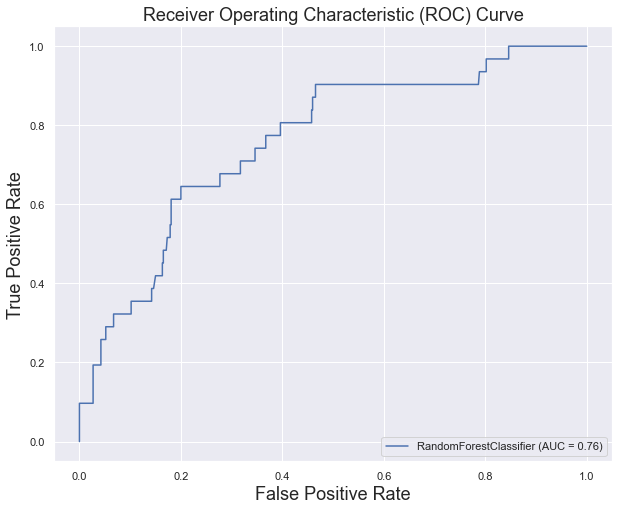

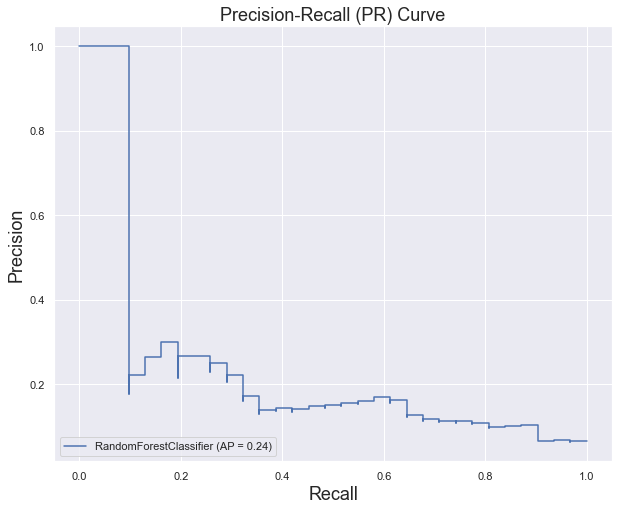

In [394]:
plot_roc_pr_curves("Random Forest (Best Random Search)", X_val, y_val, rf_random_model)

In [395]:
param_grid = {
    'bootstrap':[True],
    'max_depth': [9, 10, 11], 
    'max_features': [3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [1, 2, 3, 4], 
    'n_estimators': [400, 500, 600, 700, 800, 900]
}

In [396]:
# Create a base model
rf = RandomForestClassifier(random_state = seed)

# Instantiate the grid search model
grid_search = model_selection.GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)

In [397]:
# Fit grid to search data
grid_search.fit(X_train, y_train)

# Best model
rf_grid_model = grid_search.best_estimator_

all_results = validation_results(rf_grid_model, X_val, y_val, "RF best model (Grid Search)", all_results)
all_models["Rf best model (Grid Search)"] = rf_grid_model

grid_search.best_params_

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


{'bootstrap': True,
 'max_depth': 9,
 'max_features': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}

In [398]:
all_models

{'Logistic Regression CV': LogisticRegressionCV(cv=5, random_state=123),
 'Logistic Regression L1': LogisticRegression(penalty='l1', random_state=123, solver='liblinear'),
 'Gradient Boosting Baseline': GradientBoostingClassifier(max_features='sqrt', random_state=123, subsample=1),
 'GB best model': GradientBoostingClassifier(learning_rate=0.001, max_depth=4, n_estimators=1500,
                            random_state=123),
 'Random Forest Baseline': RandomForestClassifier(random_state=123),
 'Random Forest (Best Random Search)': RandomForestClassifier(bootstrap=False, max_depth=10, n_estimators=200,
                        random_state=123),
 'Rf best model (Grid Search)': RandomForestClassifier(max_depth=9, max_features=4, n_estimators=400,
                        random_state=123)}

In [399]:
models_df = pd.DataFrame.from_dict(all_results, orient='index', columns = ['accuracy', 'balanced_accuracy',
                                                                               'roc_auc', 'average_precision', 
                                                                               'f1', 'precision', 'recall'])


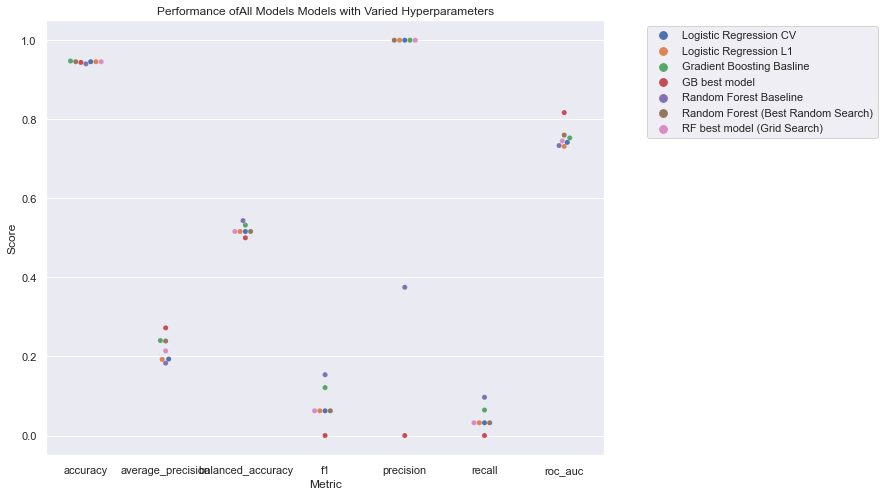

In [400]:
plot_validation_results(all_results, "All Models")

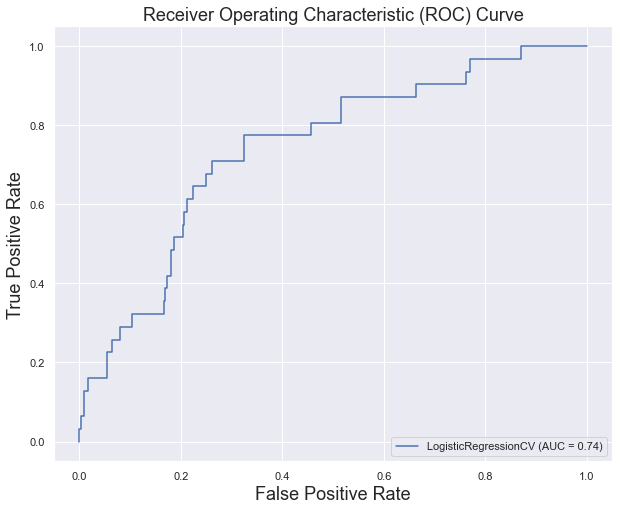

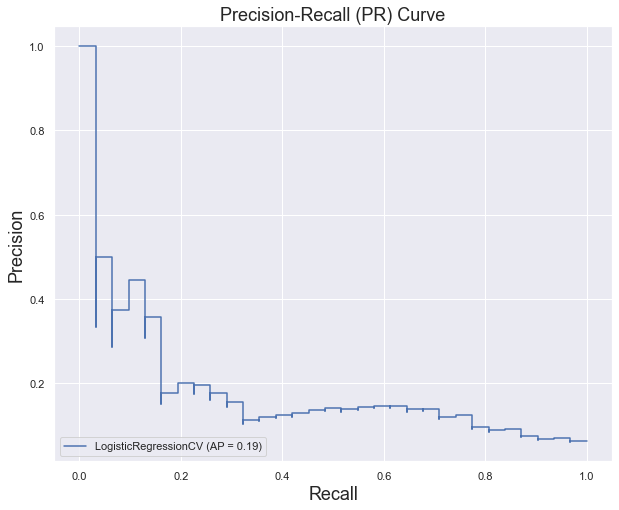

In [401]:
plot_roc_pr_curves("Logistic Regression CV", X_val, y_val, lr_cv_model)

### 14. Addressing Class imbalance

In [402]:
os_models = {}
os_results = {}

https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

In [ ]:
#from sklearn.svm import SVC
#svc_model = SVC(class_weight='balanced', probability=True)
#svc_model.fit(X_train, y_train)
# svc_predict = svc_model.predict(X_val)# check performance
# print('ROCAUC score:',metrics.roc_auc_score(y_val, svc_predict))
# print('Accuracy score:',metrics.accuracy_score(y_val, svc_predict))
# print('F1 score:',metrics.f1_score(y_val, svc_predict))

##### Importance Weighting, Manual Weighting

##### Logistic Regression L1 Penalization 

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


Text(0.5, 1.0, 'Scoring for different class weights')

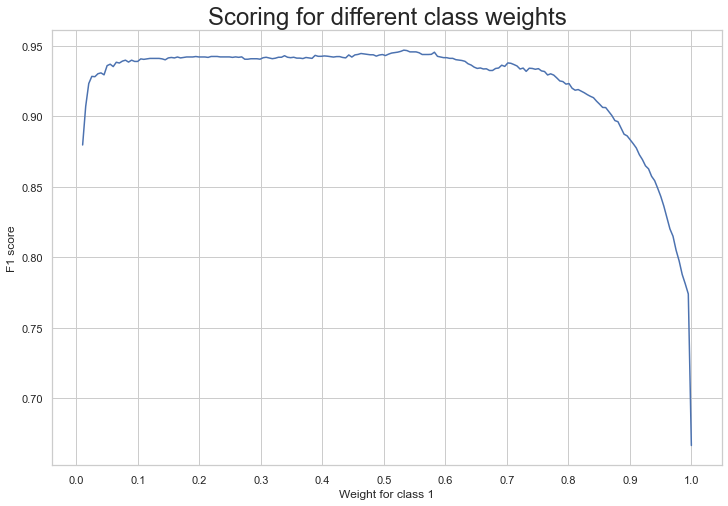

In [502]:
lr_pen_os = LogisticRegressionCV(solver='liblinear', random_state = seed, cv = 5, penalty = 'l1')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr_pen_os, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [503]:
# Get weight of max F1 score
value = max(weigh_data.score)
weigh_data[weigh_data.score == value]

,score,weight
94,0.947009,0.532362


In [505]:
#importing and training the model

lr_pen_os = LogisticRegressionCV(solver='liblinear', penalty = 'l1', cv = 5, random_state = seed, 
                                 class_weight={0: 1-0.53, 1: 0.53})
lr_pen_os.fit(X_train, y_train)

# Predicting on the test data
pred_val = lr_pen_os.predict(X_val)

#Calculating and printing the f1 score 

print('ROCAUC score:',metrics.roc_auc_score(y_val, pred_val))
print('Accuracy score:',metrics.accuracy_score(y_val, pred_val))
print('F1 score:',metrics.f1_score(y_val, pred_val))

os_results = validation_results(lr_pen_os, X_val, y_val, "Logistic Regression L1 (Importance Weighting)",
                                os_results )
os_models['Logistic Regression L1 (Importance Weighting)'] = lr_pen_os

ROCAUC score: 0.5758374689826303
Accuracy score: 0.9437386569872959
F1 score: 0.24390243902439024


##### Logistic Regression CV

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


Text(0.5, 1.0, 'Scoring for different class weights')

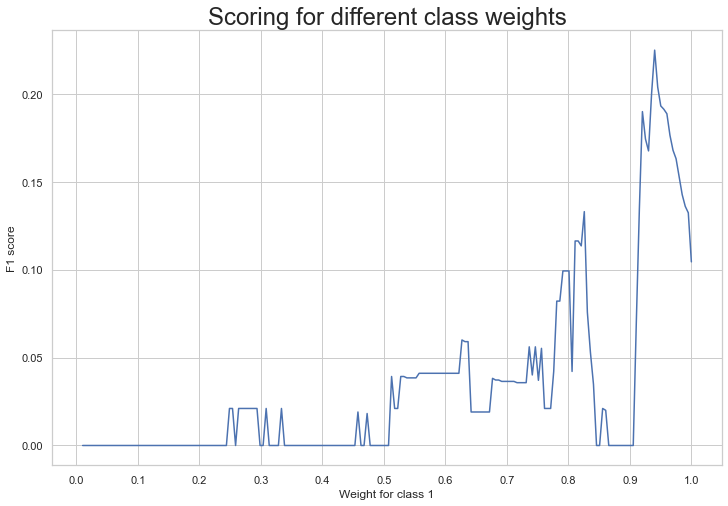

In [403]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
lr_cv_os = LogisticRegressionCV(solver='lbfgs', random_state = seed, cv = 5)

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr_cv_os, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [404]:
# Get weight of max F1 score
value = max(weigh_data.score)
weigh_data[weigh_data.score == value]

,score,weight
12,0.224797,0.940302


In [407]:
#importing and training the model

lr_cv_os = LogisticRegressionCV(solver='lbfgs', cv = 5, random_state = seed, class_weight={0: 1-0.940302, 1: 0.940302})
lr_cv_os.fit(X_train, y_train)

# Predicting on the test data
pred_val = lr_cv_os.predict(X_val)

#Calculating and printing the f1 score 

print('ROCAUC score:',metrics.roc_auc_score(y_val, pred_val))
print('Accuracy score:',metrics.accuracy_score(y_val, pred_val))
print('F1 score:',metrics.f1_score(y_val, pred_val))

os_results = validation_results(lr_cv_os, X_val, y_val, "Logistic Regression CV (Importance Weighting)",
                                os_results )
os_models['Logistic Regression CV (Importance Weighting)'] = lr_cv_os

ROCAUC score: 0.6607320099255584
Accuracy score: 0.7604355716878403
F1 score: 0.20481927710843373


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


Text(0.5, 1.0, 'Scoring for different class weights')

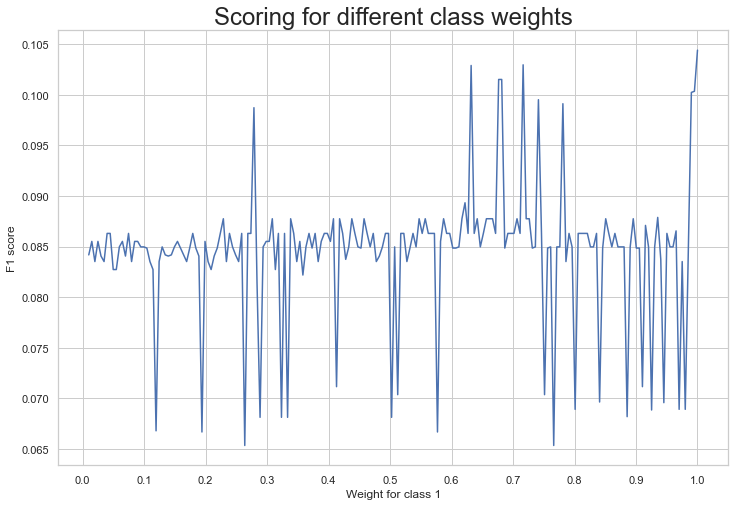

In [409]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
rf_os = RandomForestClassifier(random_state = seed)

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= rf_os, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [410]:
# Get weight of max F1 score
value = max(weigh_data.score)
weigh_data[weigh_data.score == value]

,score,weight
0,0.104414,1.0


In [411]:
#importing and training the model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
rf_os = RandomForestClassifier(random_state = seed, class_weight={0: 1-0.99, 1: 0.99})
rf_os.fit(X_train, y_train)

# Predicting on the test data
pred_val = rf_os.predict(X_val)

#Calculating and printing the f1 score 

print('ROCAUC score:',metrics.roc_auc_score(y_val, pred_val))
print('Accuracy score:',metrics.accuracy_score(y_val, pred_val))
print('F1 score:',metrics.f1_score(y_val, pred_val))

os_results = validation_results(rf_os, X_val, y_val, "Random Forest (Importance Weighting)",
                                os_results )
os_models['Random Forest (Importance Weighting)'] = rf_os

ROCAUC score: 0.5445409429280397
Accuracy score: 0.941923774954628
F1 score: 0.15789473684210525


##### SMOTE for class imbalance 

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [412]:
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))

1652
1652
551
551


In [413]:
from sklearn.datasets import make_classification
from collections import Counter

counter = Counter(y_train)
print("before:", counter)

X, y = make_classification(n_classes=2, class_sep=2,
weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
n_features=59, n_clusters_per_class=1, n_samples=1000, random_state=10)

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=seed, k_neighbors = 3)
X_res, y_res = sm.fit_resample(X_train, y_train)
counter = Counter(y_res)
print("after:", counter)

before: Counter({0: 1561, 1: 91})
after: Counter({0: 1561, 1: 1561})


In [414]:
# Generate Random Forest Model with balanced dataset using SMOTE
rf_rebalanced = RandomForestClassifier(random_state = seed)
rf_rebalanced.fit(X_res, y_res)
os_results = validation_results(rf_rebalanced, X_val, y_val, "Random Forest (SMOTE)",os_results )
os_models['Random Forest (SMOTE)'] = rf_rebalanced

In [415]:
lr_rebalanced = LogisticRegression(random_state = seed)
lr_rebalanced.fit(X_res, y_res)
os_results = validation_results(lr_rebalanced, X_val, y_val, "Logistic Regression (SMOTE)", os_results)
os_models['Logistic Regression (SMOTE)'] = lr_rebalanced

In [416]:
gb_rebalanced = GradientBoostingClassifier(random_state = seed)
gb_rebalanced.fit(X_res,y_res)
os_results = validation_results(gb_rebalanced, X_val, y_val, "Gradient Boosting (SMOTE)", os_results)
os_models['Gradient Boosting (SMOTE)'] = gb_rebalanced

In [417]:
os_results

{'Logistic Regression CV (Importance Weighting)': {'accuracy': 0.7604355716878403,
  'balanced_accuracy': 0.6607320099255583,
  'roc_auc': 0.7175558312655087,
  'average_precision': 0.18146263448887348,
  'f1': 0.20481927710843373,
  'precision': 0.1259259259259259,
  'recall': 0.5483870967741935},
 'Random Forest (Importance Weighting)': {'accuracy': 0.941923774954628,
  'balanced_accuracy': 0.5445409429280397,
  'roc_auc': 0.6983870967741936,
  'average_precision': 0.19675332877455462,
  'f1': 0.15789473684210525,
  'precision': 0.42857142857142855,
  'recall': 0.0967741935483871},
 'Random Forest (SMOTE)': {'accuracy': 0.9364791288566243,
  'balanced_accuracy': 0.5568238213399503,
  'roc_auc': 0.7042493796526055,
  'average_precision': 0.1956988655247124,
  'f1': 0.18604651162790697,
  'precision': 0.3333333333333333,
  'recall': 0.12903225806451613},
 'Logistic Regression (SMOTE)': {'accuracy': 0.9219600725952813,
  'balanced_accuracy': 0.5946339950372208,
  'roc_auc': 0.6744416873

In [418]:
X_train = X_res
y_train = y_res

##### TomekLinks 

In [ ]:
# from imblearn.under_sampling import TomekLinks

# tl = TomekLinks()
# X_resampled, y_resampled = tl.fit_resample(X_train, y_train)

# y_resampled.value_counts()

In [ ]:
# clf = LogisticRegression(random_state = seed)
# clf.fit(X_resampled, y_resampled)
# test = validation_results(clf, X_val, y_val, "TomekLinks", test)

##### Using kmeans 

In [ ]:
# from imblearn.under_sampling import ClusterCentroids

# cc = ClusterCentroids(random_state=seed)
# X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

# y_resampled.value_counts()

In [ ]:
# clf = LogisticRegression(random_state = seed)
# clf.fit(X_resampled, y_resampled)
# test = validation_results(clf, X_val, y_val, "ClusterCentroids", test)

##### Use near miss

In [ ]:
# from imblearn.under_sampling import NearMiss 
# nr = NearMiss() 
# X_near, y_near= nr.fit_resample(X_train, y_train.ravel()) 
# c=Counter(y_near)

In [ ]:
# print(c)

In [ ]:
# lr = LogisticRegression()
# lr.fit(X_near, y_near)

In [ ]:
# rf = RandomForestClassifier()
# rf.fit(X_near, y_near)
# test = validation_results(rf, X_val, y_val, "RF near miss", test)

##### Tune hyperparameters 

In [419]:
# Metrics to score
metric = ['accuracy', 'balanced_accuracy', 'roc_auc', 'average_precision', 'f1', 'precision', 'recall']
k = 5

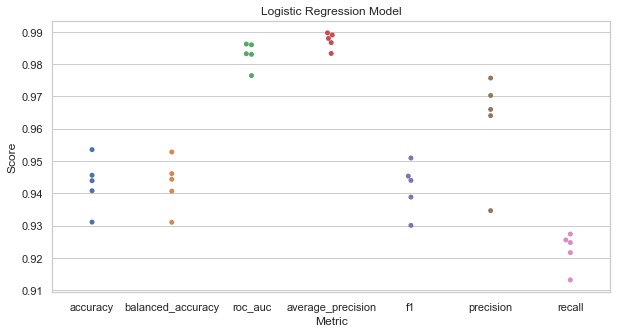

<Figure size 432x288 with 0 Axes>

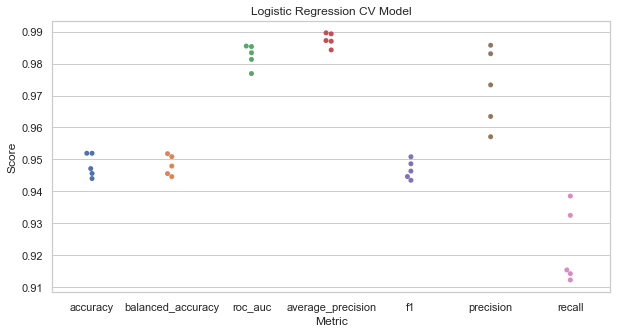

<Figure size 432x288 with 0 Axes>

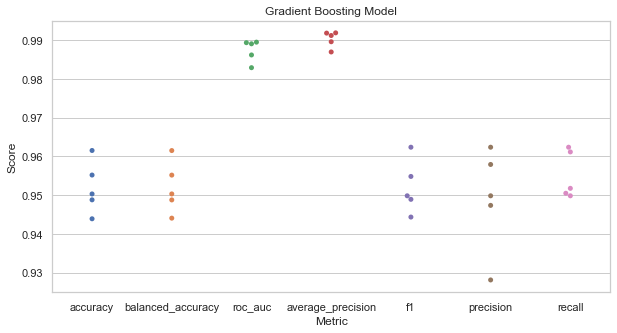

<Figure size 432x288 with 0 Axes>

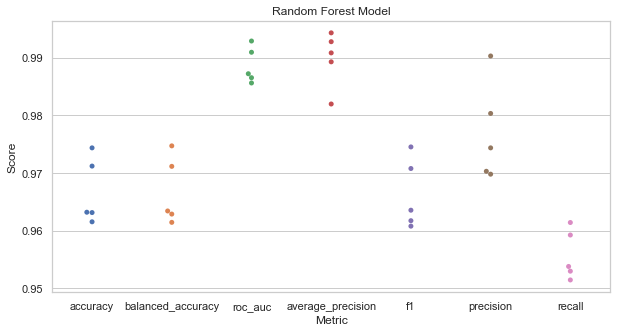

<Figure size 432x288 with 0 Axes>

In [422]:
models = [("Logistic Regression Model", LogisticRegression()),
          ("Logistic Regression CV Model", LogisticRegressionCV()), 
          ("Gradient Boosting Model", GradientBoostingClassifier()),
          ("Random Forest Model",  RandomForestClassifier())]
results = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=k, shuffle=True, random_state=seed)
    scores = model_selection.cross_validate(model, X_train, y_train, scoring=metric, cv=kfold)
    results.append((name, scores))

fig_size = (10, 5)
for name, scores in results:
    scores_df = pd.DataFrame.from_dict(scores).drop(columns=["fit_time", "score_time"])
    scores_df.columns = [col[5:] for col in scores_df.columns]
    scores_df = pd.melt(scores_df, var_name="Metric", value_name="Score")
    plt.figure(figsize=fig_size)
    ax = sns.swarmplot(data=scores_df, x="Metric", y="Score")
    ax.set_title(name)
    plt.show()
    plt.savefig('/Users/katelyn/Documents/Research/plots2/models_plots.png')
    print("\n\n")

In [423]:
results

[('Logistic Regression Model',
  {'fit_time': array([0.04962707, 0.06059909, 0.05591297, 0.03494287, 0.03710222]),
   'score_time': array([0.00824809, 0.01321697, 0.008564  , 0.00718832, 0.00813007]),
   'test_accuracy': array([0.9456    , 0.9408    , 0.95352564, 0.94391026, 0.93108974]),
   'test_balanced_accuracy': array([0.94610916, 0.94066807, 0.95279294, 0.94434966, 0.93103714]),
   'test_roc_auc': array([0.98598562, 0.98621664, 0.98321047, 0.98304127, 0.97645246]),
   'test_average_precision': array([0.9896858 , 0.98903572, 0.98665183, 0.98796867, 0.98330694]),
   'test_f1': array([0.94533762, 0.93884298, 0.95093063, 0.944     , 0.9300813 ]),
   'test_precision': array([0.97029703, 0.96598639, 0.97569444, 0.96405229, 0.93464052]),
   'test_recall': array([0.92163009, 0.91318328, 0.92739274, 0.92476489, 0.92556634])}),
 ('Logistic Regression CV Model',
  {'fit_time': array([1.35165882, 1.727844  , 1.31928205, 1.32428503, 1.32456899]),
   'score_time': array([0.00944591, 0.01032281

In [439]:
solvers = ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
penalties = ["l1"]
C_values = [100, 10, 1.0, 0.1, 0.01] # smaller values = stronger regularization

results = {}
models = []
i = 0

for solver, penalty, C in it.product(solvers, penalties, C_values):
    if solver in ["newton-cg", "sag", "lbfgs"] and penalty != "l2":
        # skip parameter configurations not supported by scikit-learn
        continue
        
    print("Model #{i} Hyperparameters => Solver: {s}, Penalty: {p}, C: {c}".format(i=i, s=solver, p=penalty, c=C))
    if solver in ["sag", "saga", "liblinear"]:
        # these solvers first shuffle the data, so include random seed
        model = LogisticRegression(solver=solver, penalty=penalty, random_state=seed)
    else:
        model = LogisticRegression(solver=solver, penalty=penalty, random_state = seed)
    model.fit(X_train, y_train)
    models.append(model)
    results = validation_results(model, X_val, y_val, "Model #%d" % i, results)
    i += 1

Model #0 Hyperparameters => Solver: liblinear, Penalty: l1, C: 100
Model #1 Hyperparameters => Solver: liblinear, Penalty: l1, C: 10
Model #2 Hyperparameters => Solver: liblinear, Penalty: l1, C: 1.0
Model #3 Hyperparameters => Solver: liblinear, Penalty: l1, C: 0.1
Model #4 Hyperparameters => Solver: liblinear, Penalty: l1, C: 0.01
Model #5 Hyperparameters => Solver: saga, Penalty: l1, C: 100
Model #6 Hyperparameters => Solver: saga, Penalty: l1, C: 10
Model #7 Hyperparameters => Solver: saga, Penalty: l1, C: 1.0
Model #8 Hyperparameters => Solver: saga, Penalty: l1, C: 0.1
Model #9 Hyperparameters => Solver: saga, Penalty: l1, C: 0.01


In [440]:
solvers = ["lbfgs"]
penalties = ["l2"]

i = 10
for solver, penalty in it.product(solvers, penalties):
    if solver in ["newton-cg", "sag", "lbfgs"] and penalty != "l2":
        # skip parameter configurations not supported by scikit-learn
        continue
        
    print("Model #{i} Hyperparameters => Solver: {s}, Penalty: {p},".format(i=i, s=solver, p=penalty))
    if solver in ["sag", "saga", "liblinear"]:
        # these solvers first shuffle the data, so include random seed
        model = LogisticRegressionCV(solver=solver, penalty=penalty, random_state=seed)
    else:
        model = LogisticRegressionCV(solver=solver, penalty=penalty, random_state = seed)
    model.fit(X_train, y_train)
    models.append(model)
    results = validation_results(model, X_val, y_val, "Model #%d" % i, results)
    i += 1

Model #10 Hyperparameters => Solver: lbfgs, Penalty: l2,


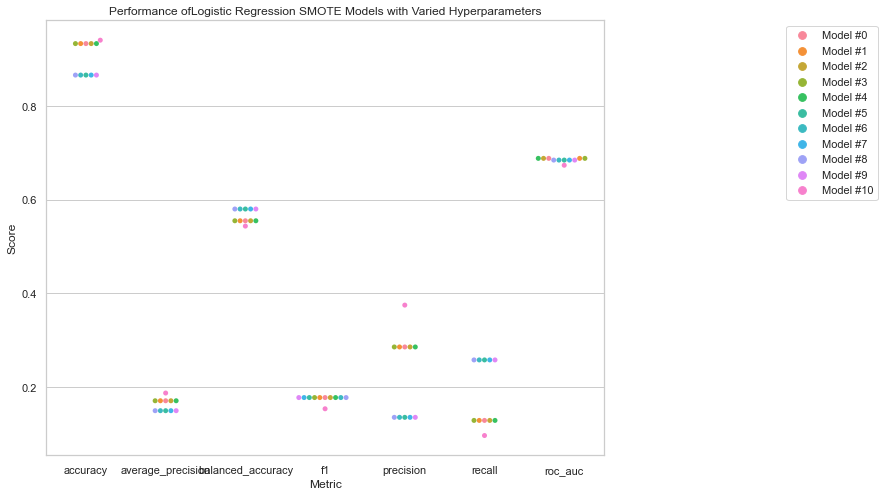

In [443]:
plot_validation_results(results, "Logistic Regression SMOTE")

In [448]:
f = filter_validation_results(results, "f1", 0.17)

Model #0
Model #1
Model #2
Model #3
Model #4
Model #5
Model #6
Model #7
Model #8
Model #9


In [450]:
r = filter_validation_results(results, "roc_auc", 0.68)

Model #0
Model #1
Model #2
Model #3
Model #4
Model #5
Model #6
Model #7
Model #8
Model #9


In [451]:
find_models(r)

Model #0
{'accuracy': 0.9328493647912885, 'balanced_accuracy': 0.5549007444168734, 'roc_auc': 0.6880272952853599, 'average_precision': 0.1709623434146461, 'f1': 0.17777777777777778, 'precision': 0.2857142857142857, 'recall': 0.12903225806451613}

Model #1
{'accuracy': 0.9328493647912885, 'balanced_accuracy': 0.5549007444168734, 'roc_auc': 0.6880272952853599, 'average_precision': 0.1709623434146461, 'f1': 0.17777777777777778, 'precision': 0.2857142857142857, 'recall': 0.12903225806451613}

Model #2
{'accuracy': 0.9328493647912885, 'balanced_accuracy': 0.5549007444168734, 'roc_auc': 0.6880272952853599, 'average_precision': 0.1709623434146461, 'f1': 0.17777777777777778, 'precision': 0.2857142857142857, 'recall': 0.12903225806451613}

Model #3
{'accuracy': 0.9328493647912885, 'balanced_accuracy': 0.5549007444168734, 'roc_auc': 0.6880272952853599, 'average_precision': 0.1709623434146461, 'f1': 0.17777777777777778, 'precision': 0.2857142857142857, 'recall': 0.12903225806451613}

Model #4
{'a

In [435]:
models

[LogisticRegression(penalty='l1', random_state=123, solver='liblinear'),
 LogisticRegression(penalty='l1', random_state=123, solver='liblinear'),
 LogisticRegression(penalty='l1', random_state=123, solver='liblinear'),
 LogisticRegression(penalty='l1', random_state=123, solver='liblinear'),
 LogisticRegression(penalty='l1', random_state=123, solver='liblinear'),
 LogisticRegression(penalty='l1', random_state=123, solver='saga'),
 LogisticRegression(penalty='l1', random_state=123, solver='saga'),
 LogisticRegression(penalty='l1', random_state=123, solver='saga'),
 LogisticRegression(penalty='l1', random_state=123, solver='saga'),
 LogisticRegression(penalty='l1', random_state=123, solver='saga'),
 LogisticRegressionCV(random_state=123)]

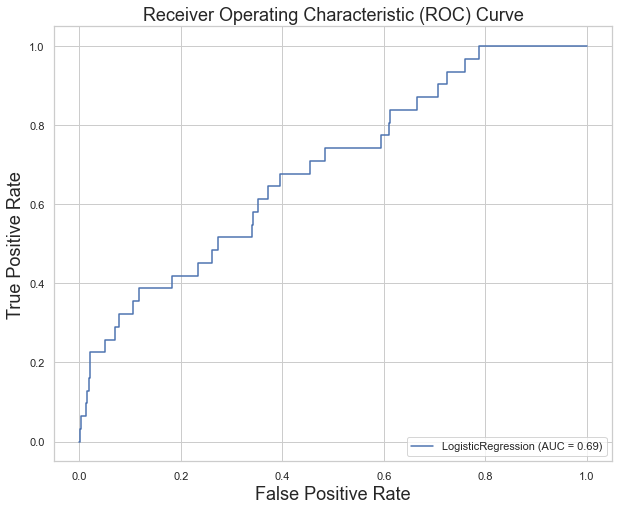

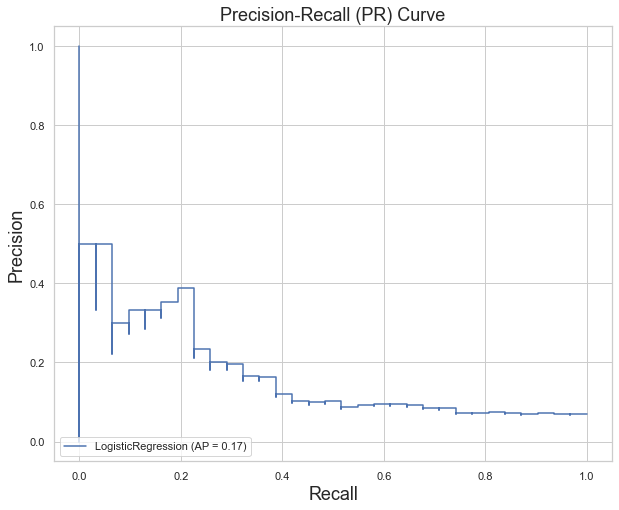

In [452]:
best_model_num = 0
lr_smote = models[best_model_num]
plot_roc_pr_curves("Logistic Regression (SMOTE)", X_val, y_val, lr_smote)
os_results = validation_results(lr_smote, X_val, y_val, "Logistic Regression (SMOTE)", os_results)
os_models["Logistic Regression (SMOTE)"] = lr_smote

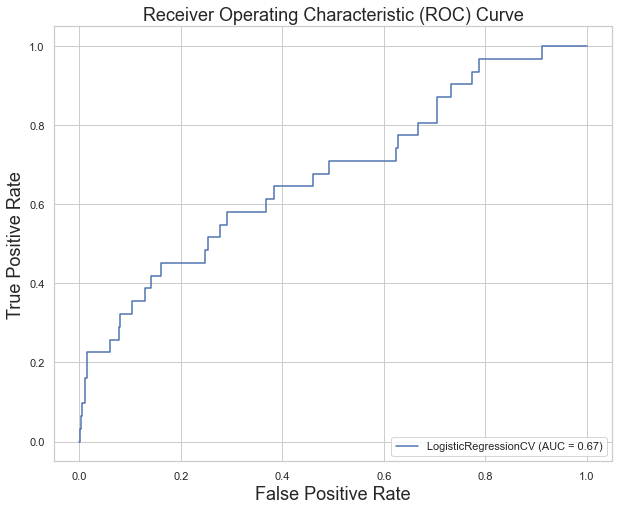

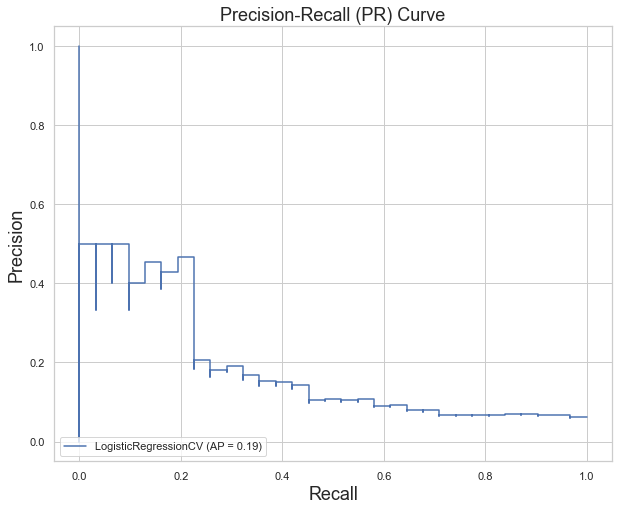

In [454]:
best_model_num = 10
lr_cv_smote = models[best_model_num]
plot_roc_pr_curves("Logistic Regression CV (SMOTE)", X_val, y_val, lr_cv_smote)
os_results = validation_results(lr_cv_smote, X_val, y_val, "Logistic Regression CV (SMOTE)", os_results)
os_models["Logistic Regression CV (SMOTE)"] = lr_cv_smote

##### Ensemble Models: Gradient Boosting and Random Forest

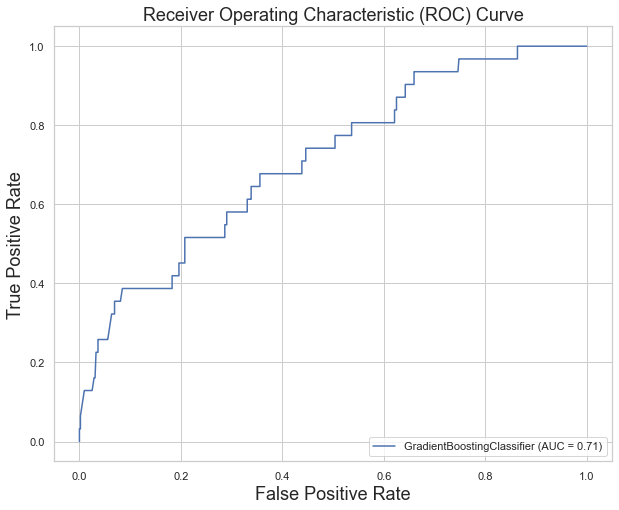

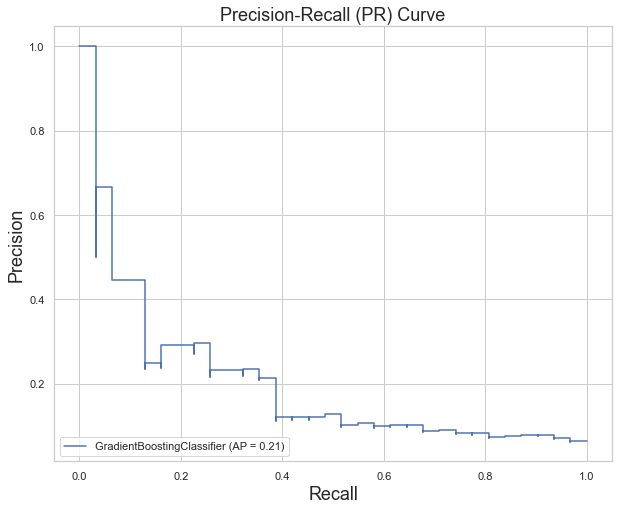

In [456]:
# Baseline model
gb_os_baseline = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100, max_depth = 3, min_samples_split = 2, 
                                     min_samples_leaf = 1, subsample = 1, max_features = "sqrt", random_state = seed)
gb_os_baseline.fit(X_train, y_train)

os_results = validation_results(gb_os_baseline, X_val, y_val, "Gradient Boosting (SMOTE)", os_results)
os_models["Gradient Boosting (SMOTE)"] = gb_os_baseline
plot_roc_pr_curves("Gradient Boosting (SMOTE)", X_val, y_val, gb_os_baseline)

In [457]:
param_1 = {'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, .25, .5, .75, 1]}
param_2 = {'learning_rate':  [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, .25, .5, .75, 1], 'n_estimators': [100, 250, 500, 750, 1000, 1250, 1500, 1750]}
param_3 = {'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, .25, .5, .75, 1], 'n_estimators': [100, 250, 500, 750, 1000, 1250, 1500, 1750], 'max_depth': [2, 3, 4]}
param_4 = {'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, .25, .5, .75, 1], 
              'n_estimators': [100, 250, 500, 750, 1000, 1250, 1500, 1750], 
           
           'max_depth': [2, 3, 4], 
             'max_features': [3, 4, 5]}

In [458]:
# GBM with param_1
tuning = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(subsample = 1, max_features= 'sqrt',
                                                                             n_estimators = 100,
                                                             max_depth = 3, min_samples_split = 2, min_samples_leaf = 1,
                                                             random_state = seed), 
                     param_grid = param_1, scoring = 'accuracy', n_jobs = 4, cv = 5)
tuning.fit(X_train, y_train)
tuning.cv_results_, tuning.best_params_, tuning.best_score_

({'mean_fit_time': array([0.18409238, 0.17202449, 0.16015806, 0.17823367, 0.18321443,
         0.15768805, 0.18713093, 0.17300305, 0.20626817, 0.1854198 ]),
  'std_fit_time': array([0.00844014, 0.00732639, 0.01365679, 0.01402747, 0.01719895,
         0.0147331 , 0.00983969, 0.00757852, 0.00891052, 0.02541619]),
  'mean_score_time': array([0.00716538, 0.00542526, 0.00461822, 0.00629902, 0.00417485,
         0.00538692, 0.00575838, 0.0056232 , 0.00464797, 0.00579662]),
  'std_score_time': array([0.00137528, 0.00072857, 0.00083654, 0.00179044, 0.00053785,
         0.00158895, 0.00029197, 0.00023869, 0.00102395, 0.00108632]),
  'param_learning_rate': masked_array(data=[0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.25, 0.5, 0.75,
                     1],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'params': [{'learning_rate': 0.001},
   {'learning_rate': 0.005},
   {'learnin

In [459]:
# GBM with param_2
tuning = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(subsample = 1, max_features= 'sqrt',
                                                             max_depth = 3, min_samples_split = 2, min_samples_leaf = 1,
                                                             random_state = seed), 
                     param_grid = param_2, scoring = 'accuracy', n_jobs = 4, cv = 5)
tuning.fit(X_train, y_train)
tuning.cv_results_, tuning.best_params_, tuning.best_score_

({'mean_fit_time': array([0.21136765, 0.46582594, 0.8040031 , 1.48650928, 1.98420844,
         2.20113163, 2.81411376, 3.55789728, 0.17925954, 0.68790674,
         1.05405259, 1.41702352, 1.74363518, 2.41972857, 2.87639127,
         2.81017761, 0.14512558, 0.35345917, 0.69348431, 1.01889753,
         1.45247908, 1.80587931, 1.99817953, 2.28892999, 0.13845029,
         0.32660928, 0.78043694, 1.15640512, 1.61921816, 1.97916198,
         2.19410348, 2.45151296, 0.14600015, 0.4228188 , 0.82735844,
         1.2418807 , 1.86623025, 2.21576128, 2.4054821 , 3.04603491,
         0.21991558, 0.41107693, 0.61903486, 0.92508488, 1.21118565,
         1.57642045, 2.21147151, 2.36411805, 0.12604098, 0.3031476 ,
         0.66110353, 0.92173643, 1.34849501, 1.68051581, 1.82626576,
         2.02972655, 0.12260542, 0.28908687, 0.59839625, 0.88762279,
         1.23063941, 1.59843926, 2.05559959, 2.23053226, 0.12369204,
         0.32557921, 0.60933461, 0.91856689, 1.1603344 , 1.5013073 ,
         2.147453

In [460]:
# GBM with param_3
tuning = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(subsample = 1, max_features= 'sqrt',
                                                             min_samples_split = 2, min_samples_leaf = 1,
                                                             random_state = seed), 
                     param_grid = param_3, scoring = 'accuracy', n_jobs = 4, cv = 5)
tuning.fit(X_train, y_train)
tuning.cv_results_, tuning.best_params_, tuning.best_score_

({'mean_fit_time': array([0.13626075, 0.23652935, 0.45825114, 0.68660221, 0.92215481,
         1.2663702 , 1.39926887, 1.62117648, 0.12810163, 0.30984955,
         0.59753876, 0.90427284, 1.1967207 , 1.50740085, 1.79323521,
         2.13240147, 0.17035737, 0.4203712 , 0.81504288, 1.22925696,
         1.60791006, 1.98029346, 2.43535085, 2.90525069, 0.09947195,
         0.23922491, 0.47493525, 0.69337263, 1.10475373, 1.26874313,
         1.44001822, 1.65964723, 0.12387762, 0.30024157, 0.60084882,
         0.92200575, 1.24442291, 1.55126357, 1.82211561, 2.26044793,
         0.17996788, 0.41848459, 0.87108483, 1.23634429, 1.59975538,
         2.05199184, 2.54512362, 2.86758528, 0.09544859, 0.23594861,
         0.45669303, 0.71214228, 0.94754362, 1.18528895, 1.38715487,
         1.62530785, 0.12872019, 0.30590649, 0.62199883, 0.94456296,
         1.25042782, 1.52058277, 1.79238224, 2.1540648 , 0.17268553,
         0.42464075, 0.83274202, 1.2459559 , 1.61179528, 2.03360834,
         2.548226

In [461]:
# GBM with param_4
tuning = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(subsample = 1, 
                                                             min_samples_split = 2, min_samples_leaf = 1,
                                                             random_state = seed), 
                     param_grid = param_4, scoring = 'accuracy', n_jobs = 4, cv = 5)

tuning.fit(X_train, y_train)
tuning.cv_results_, tuning.best_params_, tuning.best_score_

({'mean_fit_time': array([0.10973358, 0.21833658, 0.3655499 , 0.54131279, 0.70526285,
         0.92456951, 1.24463534, 1.73317509, 0.09254026, 0.31491518,
         0.56595082, 0.9013886 , 0.91817889, 1.04404316, 1.11295238,
         1.28620944, 0.08294182, 0.19564619, 0.3841784 , 0.58614178,
         0.78529558, 1.01046982, 1.21393266, 1.39959955, 0.09413753,
         0.24155884, 0.47138505, 0.69719009, 0.93199816, 1.16488509,
         1.40095706, 1.63396411, 0.10600014, 0.24505577, 0.49038363,
         0.74630027, 0.97509437, 1.19013295, 1.44007659, 1.67753372,
         0.10763764, 0.25737309, 0.510674  , 0.77162828, 1.0396378 ,
         1.28742404, 1.50855842, 1.78485465, 0.12550578, 0.29648027,
         0.59807248, 0.91998191, 1.25465426, 1.54727588, 1.80208688,
         2.07958136, 0.13368492, 0.31965575, 0.65527611, 0.9753994 ,
         1.2983511 , 1.62511663, 1.91997857, 2.40914426, 0.15913229,
         0.42989697, 0.69464159, 1.06868348, 1.35959663, 1.69779882,
         2.052388

In [462]:
gb_model_param1 = GradientBoostingClassifier(learning_rate = 0.001, random_state = seed)
gb_model_param1.fit(X_train, y_train)
predictions = gb_model_param1.predict(X_val)
print(metrics.classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.97      0.68      0.80       520
           1       0.12      0.71      0.20        31

    accuracy                           0.68       551
   macro avg       0.55      0.69      0.50       551
weighted avg       0.93      0.68      0.76       551



In [463]:
gb_model_param2 = GradientBoostingClassifier(learning_rate = 0.005,n_estimators = 500, random_state = seed)
gb_model_param2.fit(X_train, y_train)
predictions = gb_model_param2.predict(X_val)
print(metrics.classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90       520
           1       0.14      0.42      0.21        31

    accuracy                           0.82       551
   macro avg       0.55      0.63      0.55       551
weighted avg       0.91      0.82      0.86       551



In [464]:
gb_model_param3 = GradientBoostingClassifier(learning_rate = 0.001, n_estimators = 1500, max_depth = 4, random_state = seed)
gb_model_param3.fit(X_train, y_train)
predictions = gb_model_param3.predict(X_val)
print(metrics.classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90       520
           1       0.14      0.39      0.20        31

    accuracy                           0.83       551
   macro avg       0.55      0.62      0.55       551
weighted avg       0.91      0.83      0.86       551



In [465]:
gb_model_param4 = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 3, max_features = 5,
                                             n_estimators = 250, random_state = seed)
gb_model_param4.fit(X_train, y_train)
predictions = gb_model_param4.predict(X_val)
print(metrics.classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.96      0.86      0.91       520
           1       0.13      0.35      0.19        31

    accuracy                           0.83       551
   macro avg       0.55      0.61      0.55       551
weighted avg       0.91      0.83      0.87       551



In [466]:
gb_os_best_model = gb_model_param2
os_results = validation_results(gb_os_best_model, X_val, y_val, "Gradient Boosting Best (SMOTE)", os_results)
os_models["Gradient Boosting Best (SMOTE)"] = gb_os_best_model

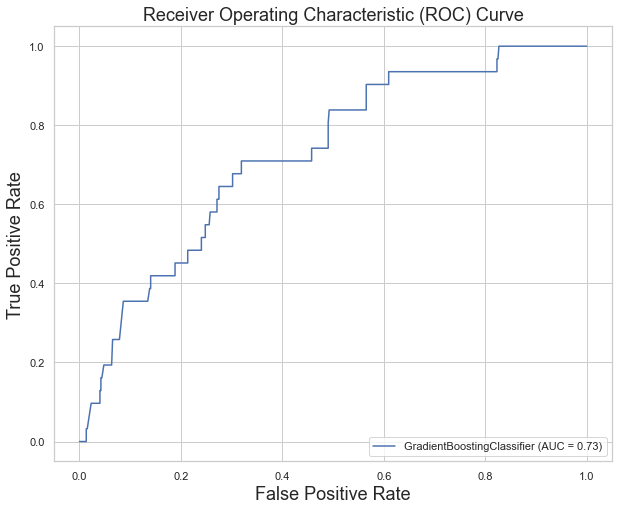

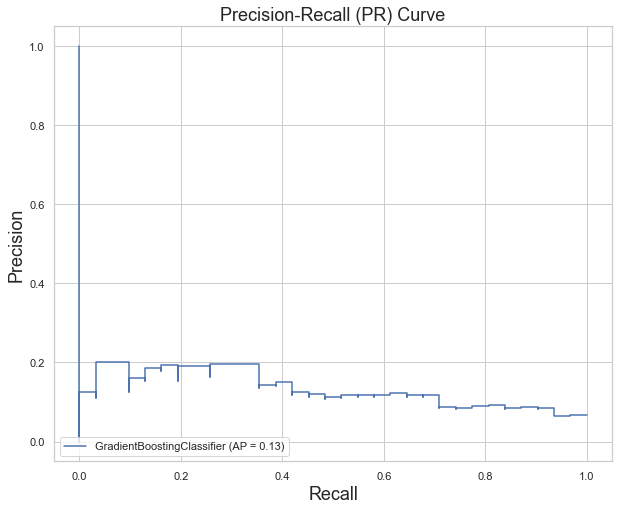

In [467]:
plot_roc_pr_curves("Gradient Boosting Best (SMOTE)", X_val, y_val, gb_os_best_model)

In [468]:
rf = RandomForestClassifier(random_state = seed)

# Look at parameters in rf 
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}


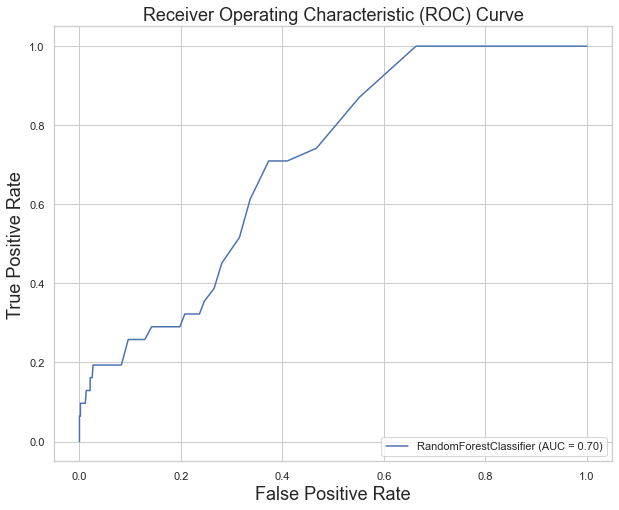

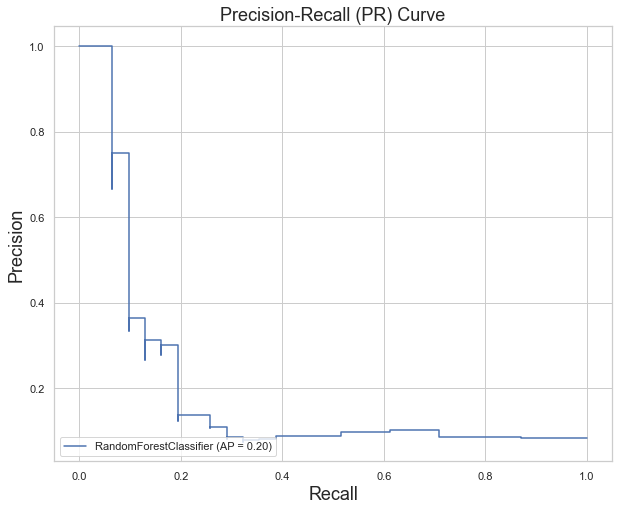

In [472]:
rf_os_baseline = RandomForestClassifier(random_state = seed)
rf_os_baseline.fit(X_train, y_train)

os_results = validation_results(rf_os_baseline, X_val, y_val, "Random Forest (SMOTE)", os_results)
os_models["Random Forest (SMOTE)"] = rf_os_baseline
plot_roc_pr_curves("Random Forest (SMOTE)", X_val, y_val, rf_os_baseline)

In [473]:
# Random search grid
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree 
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node 
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

In [474]:
# Create random grid
random_grid = {'n_estimators': n_estimators, 
              'max_features': max_features, 
              'max_depth': max_depth, 
              'min_samples_split': min_samples_split, 
              'min_samples_leaf': min_samples_leaf, 
              'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [476]:
# Random search training
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = seed)
# Random search of parameters, using 3 fold cross validation
# Search across 100 different combinations, and use all available cores
rf_random = model_selection.RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, random_state = seed, 
                              n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
rf_os_random_model = rf_random.best_estimator_

os_results = validation_results(rf_os_random_model, X_val, y_val, "Random Forest Random (SMOTE)", os_results)
os_models["Random Forest Random (SMOTE)"] = rf_os_random_model

# View best parameters
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': True}

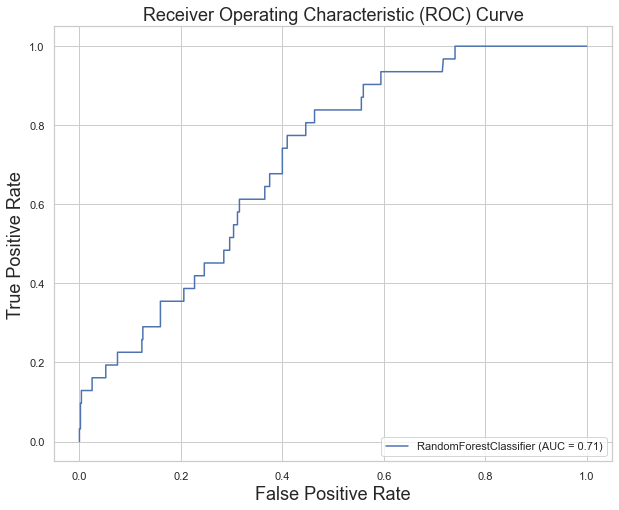

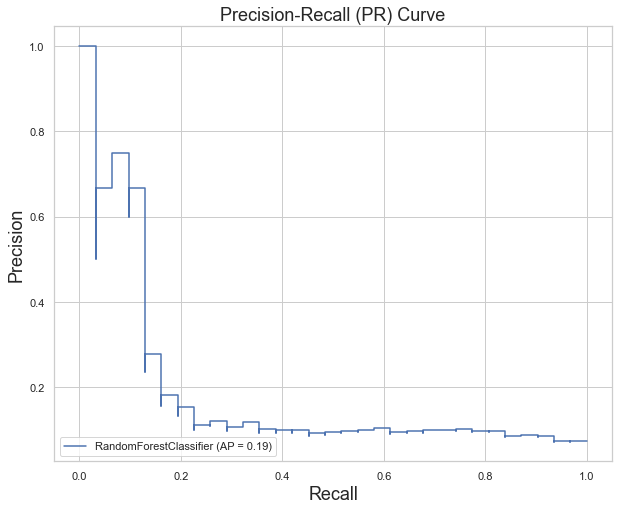

In [477]:
plot_roc_pr_curves("Random Forest Random (SMOTE)",X_val, y_val, rf_os_random_model)

In [478]:
param_grid = {
    'bootstrap':[True],
    'max_depth': [9, 10, 11], 
    'max_features': [3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [1, 2, 3, 4], 
    'n_estimators': [400, 500, 600, 700, 800, 900]
}

In [480]:
# Create a base model
rf = RandomForestClassifier(random_state = seed)

# Instantiate the grid search model
grid_search = model_selection.GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

Fitting 3 folds for each of 1152 candidates, totalling 3456 fits


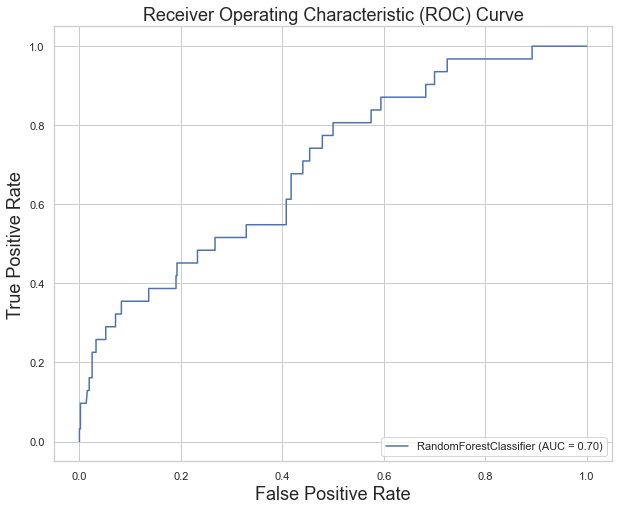

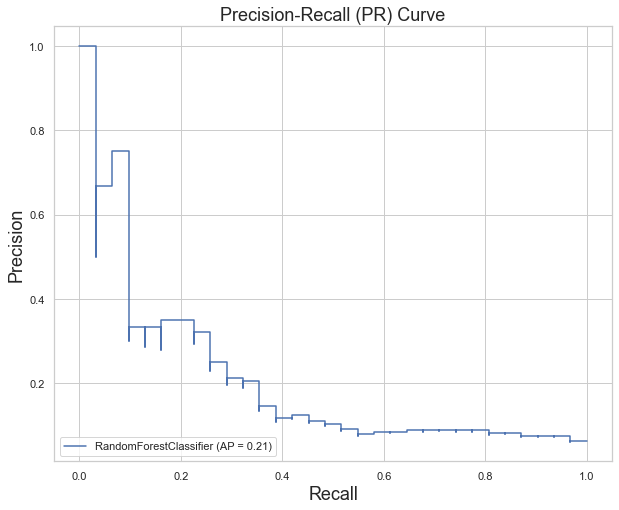

{'bootstrap': True,
 'max_depth': 11,
 'max_features': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 400}

In [481]:
# Fit grid to search data
grid_search.fit(X_train, y_train)

# Best model
rf_os_grid_model = grid_search.best_estimator_

os_results = validation_results(rf_os_grid_model, X_val, y_val, "Random Forest Grid (SMOTE)", os_results)
os_models["Random Forest Grid (SMOTE)"] = rf_os_grid_model
plot_roc_pr_curves("Random Forest Grid (SMOTE)", X_val, y_val, rf_os_grid_model)

grid_search.best_params_

In [488]:
os_results

{'Logistic Regression CV (Importance Weighting)': {'accuracy': 0.7604355716878403,
  'balanced_accuracy': 0.6607320099255583,
  'roc_auc': 0.7175558312655087,
  'average_precision': 0.18146263448887348,
  'f1': 0.20481927710843373,
  'precision': 0.1259259259259259,
  'recall': 0.5483870967741935},
 'Random Forest (Importance Weighting)': {'accuracy': 0.941923774954628,
  'balanced_accuracy': 0.5445409429280397,
  'roc_auc': 0.6983870967741936,
  'average_precision': 0.19675332877455462,
  'f1': 0.15789473684210525,
  'precision': 0.42857142857142855,
  'recall': 0.0967741935483871},
 'Random Forest (SMOTE)': {'accuracy': 0.9364791288566243,
  'balanced_accuracy': 0.5568238213399503,
  'roc_auc': 0.7042493796526055,
  'average_precision': 0.1956988655247124,
  'f1': 0.18604651162790697,
  'precision': 0.3333333333333333,
  'recall': 0.12903225806451613},
 'Logistic Regression (SMOTE)': {'accuracy': 0.9328493647912885,
  'balanced_accuracy': 0.5549007444168734,
  'roc_auc': 0.6880272952

In [483]:
os_models_df = pd.DataFrame.from_dict(os_results, orient='index', columns = ['accuracy', 'balanced_accuracy',
                                                                               'roc_auc', 'average_precision', 
                                                                               'f1', 'precision', 'recall'])


In [497]:
models_df

,accuracy,balanced_accuracy,roc_auc,average_precision,f1,precision,recall
Logistic Regression CV,0.945554,0.516129,0.741563,0.193539,0.062500,1.000,0.032258
Logistic Regression L1,0.945554,0.516129,0.731328,0.192566,0.062500,1.000,0.032258
Gradient Boosting Basline,0.947368,0.532258,0.752730,0.240271,0.121212,1.000,0.064516
GB best model,0.943739,0.500000,0.816780,0.272294,0.000000,0.000,0.000000
Random Forest Baseline,0.940109,0.543579,0.733437,0.183124,0.153846,0.375,0.096774
Random Forest (Best Random Search),0.945554,0.516129,0.759988,0.239081,0.062500,1.000,0.032258
RF best model (Grid Search),0.945554,0.516129,0.745161,0.213903,0.062500,1.000,0.032258


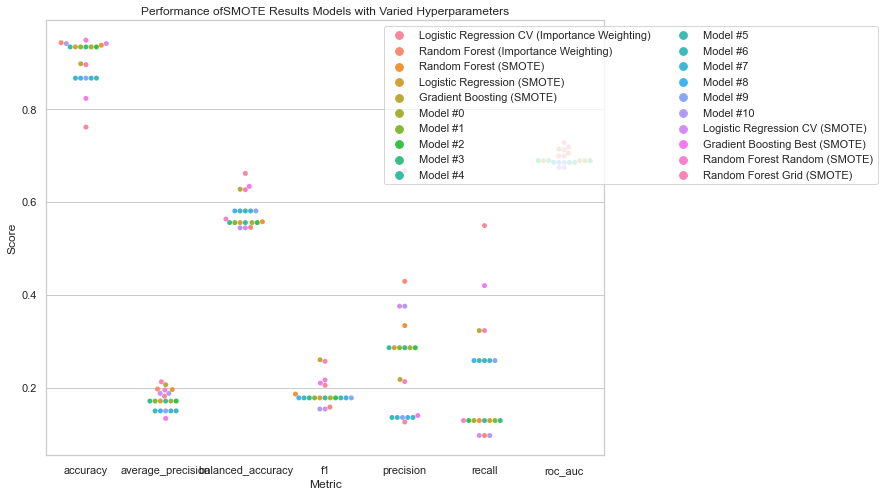

In [486]:
plot_validation_results(os_results, "SMOTE Results")

In [487]:
# Write ensemble models to csv
models_df.to_csv("models_df.csv")
os_models_df.to_csv("os_models_df.csv")

### 15. Model Evaluation - Held Out Test Set

In [491]:
# Generate held out dataset
held_out_df = df_one_hot[df_one_hot.subject_id.isin(held_out_patients)]
y_heldout = held_out_df['ln_5years']
X_heldout = held_out_df.loc[:, held_out_df.columns != 'ln_5years']
X_heldout.drop([ 'subject_id'], inplace = True, axis = 1)

In [492]:
print(len(X_heldout))
print(len(y_heldout))

560
560


In [493]:
def test_model(name, clf, X_test, y_test, fig_size=(10,8)):
    # clf: trained classifier (i.e. after using fit function)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)

    # print out stats
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("Model accuracy: %.3f\n" % accuracy)

    # precision, recall, and f1-score is usually reported for class 1 (in binary case)
    # recall of positive class (1) = sensitivity
    # recall of negative class (0) = specificity
    # precision of positive class (1) = PPV
    # precision of negative class (0) = NPV
    print(metrics.classification_report(y_test,y_pred))

    # confusion matrix
    cm_disp = metrics.plot_confusion_matrix(clf, X_test, y_test)  
    plt.savefig('/Users/katelyn/Documents/Research/plots2/' + str(name) + '_cm_test.png')
    plt.show()

    # ROC Curve and AUC
    auroc = metrics.roc_auc_score(y_test, y_pred_proba[:, 1])
    fig_roc, ax_roc = plt.subplots(1,1,figsize=fig_size)
    roc_disp = metrics.plot_roc_curve(clf, X_test, y_test, ax=ax_roc)
    ax_roc.set_xlabel("False Positive Rate", fontsize = 18)
    ax_roc.set_ylabel("True Positive Rate", fontsize = 18)
    ax_roc.set_title("Receiver Operating Characteristic (ROC) Curve", fontsize = 18)
    plt.savefig('/Users/katelyn/Documents/Research/plots2/' + str(name) + '_roc_test.png')
    plt.show()

    # PR Curve and AP (average precision)
    fig, ax_pr = plt.subplots(1,1,figsize=fig_size)
    pr_disp = metrics.plot_precision_recall_curve(clf, X_test, y_test, ax=ax_pr)
    ax_pr.set_xlabel("Recall", fontsize = 18)
    ax_pr.set_ylabel("Precision", fontsize = 18)
    ax_pr.set_title("Precision-Recall (PR) Curve", fontsize = 18)
    plt.savefig('/Users/katelyn/Documents/Research/plots2/' + str(name) + '_pr_test.png')
    plt.show()

In [ ]:
test_model("lr", lr, X_heldout, y_heldout)

In [ ]:
# Plot both validation and test roc on same plot

def plot_both(name, clf, X_val, y_val, X_test, y_test, fig_size=(10,8)):
    # clf: trained classifier (i.e. after using fit function)
    y_pred = clf.predict(X_val)
    y_pred_proba = clf.predict_proba(X_val)


    # ROC Curve and AUC
    auroc = metrics.roc_auc_score(y_val, y_pred_proba[:, 1])
    fig_roc, ax_roc = plt.subplots(1,1,figsize=fig_size)
    roc_disp = metrics.plot_roc_curve(clf, X_val, y_val, ax=ax_roc, name = "Internal Validation")
    ax_roc.set_xlabel("False Positive Rate", fontsize = 18)
    ax_roc.set_ylabel("True Positive Rate", fontsize = 18)
    ax_roc.set_title("Receiver Operating Characteristic (ROC) Curve " + str(name), fontsize = 20)
    
    y_pred_test = clf.predict(X_test)
    y_pred_proba_test = clf.predict_proba(X_test)


    auroc_test = metrics.roc_auc_score(y_test, y_pred_proba_test[:, 1])

    roc_disp = metrics.plot_roc_curve(clf, X_test, y_test, ax=ax_roc, name = "Internal Evaluation on Held-Out Test Set")
    plt.savefig('/Users/katelyn/Documents/Research/plots1/' + str(name) + '_both_roc.png')
    
    plt.show()

In [ ]:
plot_both("lr_best_model", lr_best_model, X_val, y_val, X_heldout, y_heldout)

In [553]:
test_results = {}
test_results = validation_results(lr_best_model, X_heldout, y_heldout,"lr_best_model", test_results)

In [555]:
test_results = validation_results(lr_cv_model, X_heldout, y_heldout,"lr_cv_model", test_results)

In [ ]:
test_results = validation_results(rf_baseline, X_heldout, y_heldout,"rf_baseline", test_results)

In [559]:
test_results = validation_results(rf_os_random_model, X_heldout, y_heldout, "rf_os_random_model", test_results)

In [ ]:
test_results = validation_results(gb_baseline, X_heldout, y_heldout, "gb_baseline", test_results)

In [ ]:
# Cohort demographics

In [ ]:
print("Num female:", sum(outcome_yes.gender == 1))
print("% female:", sum(outcome_yes.gender == 1)/len(outcome_yes))
print("Num female outcome no:", sum(outcome_no.gender == 1))
print("% female outcome no:", sum(outcome_no.gender == 1)/len(outcome_no))

In [ ]:
2608-2367

In [ ]:
155-133

In [ ]:
outcome_yes.head()

In [ ]:
race = outcome_yes.groupby(['race_final'],as_index = False).agg({
    'subject_id': 'nunique'
})

In [ ]:
race['total'] = 155
race['percent'] = race.subject_id/race.total
race

In [ ]:
race1 = outcome_no.groupby(['race_final'],as_index = False).agg({
    'subject_id': 'nunique'
})
race1['total'] = 2608
race1['percent'] = race1.subject_id/race1.total
race1

In [ ]:
eth = outcome_no.groupby(['ethnicity_final'],as_index = False).agg({
    'subject_id': 'nunique'
})
eth['total'] = 2608
eth['percent'] = eth.subject_id/eth.total
eth

In [ ]:
eth1 = outcome_yes.groupby(['ethnicity_final'],as_index = False).agg({
    'subject_id': 'nunique'
})
eth1['total'] = 155
eth1['percent'] = eth1.subject_id/eth1.total
eth1

In [ ]:
outcome_no.age_at_diagnosis.mean()

In [ ]:
outcome_yes.age_at_diagnosis.mean()